In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [5]:
data_dir = Path('input')
feature_dir = Path('input')
val_dir = Path('input')
tst_dir = Path('input')
sub_dir = Path('input')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [6]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [7]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 21)


,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_rg,d_dered_ig,d_dered_zg,d_dered_ri,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,
0,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,23.1941,20.2973,18.9823,17.6523,16.9243,-1.3027,-2.6257,-3.3488,1.3230,2.0462,0.7232,-15.0556
1,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,15.0093,14.0332,13.4319,13.2523,13.1518,-0.5931,-0.7683,-0.8698,0.1751,0.2767,0.1016,-0.3069
2,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,16.6970,15.7560,15.4882,15.3576,15.3231,-0.2466,-0.3649,-0.3905,0.1183,0.1440,0.0257,-0.9014
3,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,25.5071,21.0917,20.1542,19.8448,19.5949,-0.9074,-1.2000,-1.4395,0.2926,0.5321,0.2395,-1.3906
4,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,24.1124,20.5665,18.9527,18.2572,17.9293,-1.5709,-2.2436,-2.5579,0.6727,0.9871,0.3144,-9.3609


In [8]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 20) (80000, 20)


In [9]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [10]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=10000,
                             num_leaves=512,
                             learning_rate=0.001,
                             min_child_samples=10,
                             subsample=0.7,
                             subsample_freq=1,
                             colsample_bytree=0.7,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.984903
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.983904
[3]	valid_0's multi_logloss: 0.982758
[4]	valid_0's multi_logloss: 0.981647
[5]	valid_0's multi_logloss: 0.980494
[6]	valid_0's multi_logloss: 0.979428
[7]	valid_0's multi_logloss: 0.978285
[8]	valid_0's multi_logloss: 0.977221
[9]	valid_0's multi_logloss: 0.976174
[10]	valid_0's multi_logloss: 0.97511
[11]	valid_0's multi_logloss: 0.974028
[12]	valid_0's multi_logloss: 0.972953
[13]	valid_0's multi_logloss: 0.971853
[14]	valid_0's multi_logloss: 0.970735
[15]	valid_0's multi_logloss: 0.969606
[16]	valid_0's multi_logloss: 0.968577
[17]	valid_0's multi_logloss: 0.967563
[18]	valid_0's multi_logloss: 0.96649
[19]	valid_0's multi_logloss: 0.965446
[20]	valid_0's multi_logloss: 0.964438
[21]	valid_0's multi_logloss: 0.96337
[22]	valid_0's multi_logloss: 0.96231
[23]	valid_0's multi_logloss: 0.961225
[24]	valid_0's multi_logloss: 

[208]	valid_0's multi_logloss: 0.794896
[209]	valid_0's multi_logloss: 0.794098
[210]	valid_0's multi_logloss: 0.79333
[211]	valid_0's multi_logloss: 0.792558
[212]	valid_0's multi_logloss: 0.791795
[213]	valid_0's multi_logloss: 0.791078
[214]	valid_0's multi_logloss: 0.790373
[215]	valid_0's multi_logloss: 0.789588
[216]	valid_0's multi_logloss: 0.788826
[217]	valid_0's multi_logloss: 0.788048
[218]	valid_0's multi_logloss: 0.787287
[219]	valid_0's multi_logloss: 0.786506
[220]	valid_0's multi_logloss: 0.785754
[221]	valid_0's multi_logloss: 0.785012
[222]	valid_0's multi_logloss: 0.784232
[223]	valid_0's multi_logloss: 0.783498
[224]	valid_0's multi_logloss: 0.782721
[225]	valid_0's multi_logloss: 0.782005
[226]	valid_0's multi_logloss: 0.781228
[227]	valid_0's multi_logloss: 0.780509
[228]	valid_0's multi_logloss: 0.779831
[229]	valid_0's multi_logloss: 0.779057
[230]	valid_0's multi_logloss: 0.778331
[231]	valid_0's multi_logloss: 0.777562
[232]	valid_0's multi_logloss: 0.77687
[2

[415]	valid_0's multi_logloss: 0.659374
[416]	valid_0's multi_logloss: 0.658865
[417]	valid_0's multi_logloss: 0.658312
[418]	valid_0's multi_logloss: 0.657729
[419]	valid_0's multi_logloss: 0.657144
[420]	valid_0's multi_logloss: 0.656581
[421]	valid_0's multi_logloss: 0.656015
[422]	valid_0's multi_logloss: 0.655456
[423]	valid_0's multi_logloss: 0.654877
[424]	valid_0's multi_logloss: 0.654339
[425]	valid_0's multi_logloss: 0.653764
[426]	valid_0's multi_logloss: 0.653209
[427]	valid_0's multi_logloss: 0.652705
[428]	valid_0's multi_logloss: 0.652148
[429]	valid_0's multi_logloss: 0.651596
[430]	valid_0's multi_logloss: 0.65102
[431]	valid_0's multi_logloss: 0.650484
[432]	valid_0's multi_logloss: 0.649969
[433]	valid_0's multi_logloss: 0.649417
[434]	valid_0's multi_logloss: 0.648855
[435]	valid_0's multi_logloss: 0.64832
[436]	valid_0's multi_logloss: 0.647775
[437]	valid_0's multi_logloss: 0.64723
[438]	valid_0's multi_logloss: 0.646664
[439]	valid_0's multi_logloss: 0.646129
[44

[621]	valid_0's multi_logloss: 0.558717
[622]	valid_0's multi_logloss: 0.558297
[623]	valid_0's multi_logloss: 0.557848
[624]	valid_0's multi_logloss: 0.557447
[625]	valid_0's multi_logloss: 0.557037
[626]	valid_0's multi_logloss: 0.556594
[627]	valid_0's multi_logloss: 0.556154
[628]	valid_0's multi_logloss: 0.555779
[629]	valid_0's multi_logloss: 0.555335
[630]	valid_0's multi_logloss: 0.554925
[631]	valid_0's multi_logloss: 0.554527
[632]	valid_0's multi_logloss: 0.554102
[633]	valid_0's multi_logloss: 0.553677
[634]	valid_0's multi_logloss: 0.553266
[635]	valid_0's multi_logloss: 0.552842
[636]	valid_0's multi_logloss: 0.552435
[637]	valid_0's multi_logloss: 0.552023
[638]	valid_0's multi_logloss: 0.551588
[639]	valid_0's multi_logloss: 0.551204
[640]	valid_0's multi_logloss: 0.55079
[641]	valid_0's multi_logloss: 0.550355
[642]	valid_0's multi_logloss: 0.54992
[643]	valid_0's multi_logloss: 0.549497
[644]	valid_0's multi_logloss: 0.549114
[645]	valid_0's multi_logloss: 0.548681
[6

[827]	valid_0's multi_logloss: 0.481576
[828]	valid_0's multi_logloss: 0.481233
[829]	valid_0's multi_logloss: 0.480913
[830]	valid_0's multi_logloss: 0.480584
[831]	valid_0's multi_logloss: 0.48024
[832]	valid_0's multi_logloss: 0.479894
[833]	valid_0's multi_logloss: 0.479575
[834]	valid_0's multi_logloss: 0.479255
[835]	valid_0's multi_logloss: 0.478925
[836]	valid_0's multi_logloss: 0.478583
[837]	valid_0's multi_logloss: 0.478242
[838]	valid_0's multi_logloss: 0.477901
[839]	valid_0's multi_logloss: 0.47757
[840]	valid_0's multi_logloss: 0.477278
[841]	valid_0's multi_logloss: 0.476945
[842]	valid_0's multi_logloss: 0.476605
[843]	valid_0's multi_logloss: 0.47629
[844]	valid_0's multi_logloss: 0.475975
[845]	valid_0's multi_logloss: 0.475646
[846]	valid_0's multi_logloss: 0.47531
[847]	valid_0's multi_logloss: 0.474983
[848]	valid_0's multi_logloss: 0.474665
[849]	valid_0's multi_logloss: 0.47433
[850]	valid_0's multi_logloss: 0.474002
[851]	valid_0's multi_logloss: 0.473668
[852]

[1032]	valid_0's multi_logloss: 0.421357
[1033]	valid_0's multi_logloss: 0.421107
[1034]	valid_0's multi_logloss: 0.420834
[1035]	valid_0's multi_logloss: 0.420579
[1036]	valid_0's multi_logloss: 0.420323
[1037]	valid_0's multi_logloss: 0.420091
[1038]	valid_0's multi_logloss: 0.419829
[1039]	valid_0's multi_logloss: 0.419586
[1040]	valid_0's multi_logloss: 0.419315
[1041]	valid_0's multi_logloss: 0.419068
[1042]	valid_0's multi_logloss: 0.4188
[1043]	valid_0's multi_logloss: 0.418551
[1044]	valid_0's multi_logloss: 0.418295
[1045]	valid_0's multi_logloss: 0.418033
[1046]	valid_0's multi_logloss: 0.417763
[1047]	valid_0's multi_logloss: 0.41753
[1048]	valid_0's multi_logloss: 0.41727
[1049]	valid_0's multi_logloss: 0.417045
[1050]	valid_0's multi_logloss: 0.416788
[1051]	valid_0's multi_logloss: 0.416523
[1052]	valid_0's multi_logloss: 0.416279
[1053]	valid_0's multi_logloss: 0.416035
[1054]	valid_0's multi_logloss: 0.415772
[1055]	valid_0's multi_logloss: 0.41553
[1056]	valid_0's mult

[1233]	valid_0's multi_logloss: 0.37473
[1234]	valid_0's multi_logloss: 0.374531
[1235]	valid_0's multi_logloss: 0.374323
[1236]	valid_0's multi_logloss: 0.374125
[1237]	valid_0's multi_logloss: 0.373918
[1238]	valid_0's multi_logloss: 0.373717
[1239]	valid_0's multi_logloss: 0.373516
[1240]	valid_0's multi_logloss: 0.3733
[1241]	valid_0's multi_logloss: 0.373099
[1242]	valid_0's multi_logloss: 0.372893
[1243]	valid_0's multi_logloss: 0.372685
[1244]	valid_0's multi_logloss: 0.372488
[1245]	valid_0's multi_logloss: 0.372289
[1246]	valid_0's multi_logloss: 0.372085
[1247]	valid_0's multi_logloss: 0.371891
[1248]	valid_0's multi_logloss: 0.371698
[1249]	valid_0's multi_logloss: 0.371496
[1250]	valid_0's multi_logloss: 0.371298
[1251]	valid_0's multi_logloss: 0.371101
[1252]	valid_0's multi_logloss: 0.370885
[1253]	valid_0's multi_logloss: 0.370671
[1254]	valid_0's multi_logloss: 0.370473
[1255]	valid_0's multi_logloss: 0.370269
[1256]	valid_0's multi_logloss: 0.370074
[1257]	valid_0's mu

[1434]	valid_0's multi_logloss: 0.337276
[1435]	valid_0's multi_logloss: 0.337116
[1436]	valid_0's multi_logloss: 0.33694
[1437]	valid_0's multi_logloss: 0.336761
[1438]	valid_0's multi_logloss: 0.336601
[1439]	valid_0's multi_logloss: 0.336424
[1440]	valid_0's multi_logloss: 0.336264
[1441]	valid_0's multi_logloss: 0.336115
[1442]	valid_0's multi_logloss: 0.335956
[1443]	valid_0's multi_logloss: 0.335786
[1444]	valid_0's multi_logloss: 0.335617
[1445]	valid_0's multi_logloss: 0.335458
[1446]	valid_0's multi_logloss: 0.335302
[1447]	valid_0's multi_logloss: 0.335159
[1448]	valid_0's multi_logloss: 0.335003
[1449]	valid_0's multi_logloss: 0.334841
[1450]	valid_0's multi_logloss: 0.334666
[1451]	valid_0's multi_logloss: 0.334497
[1452]	valid_0's multi_logloss: 0.334343
[1453]	valid_0's multi_logloss: 0.33418
[1454]	valid_0's multi_logloss: 0.334014
[1455]	valid_0's multi_logloss: 0.333857
[1456]	valid_0's multi_logloss: 0.333686
[1457]	valid_0's multi_logloss: 0.333534
[1458]	valid_0's m

[1637]	valid_0's multi_logloss: 0.306779
[1638]	valid_0's multi_logloss: 0.306652
[1639]	valid_0's multi_logloss: 0.306516
[1640]	valid_0's multi_logloss: 0.306371
[1641]	valid_0's multi_logloss: 0.306236
[1642]	valid_0's multi_logloss: 0.306093
[1643]	valid_0's multi_logloss: 0.305951
[1644]	valid_0's multi_logloss: 0.305805
[1645]	valid_0's multi_logloss: 0.305683
[1646]	valid_0's multi_logloss: 0.305549
[1647]	valid_0's multi_logloss: 0.30542
[1648]	valid_0's multi_logloss: 0.305288
[1649]	valid_0's multi_logloss: 0.305161
[1650]	valid_0's multi_logloss: 0.305019
[1651]	valid_0's multi_logloss: 0.304879
[1652]	valid_0's multi_logloss: 0.30475
[1653]	valid_0's multi_logloss: 0.304613
[1654]	valid_0's multi_logloss: 0.304472
[1655]	valid_0's multi_logloss: 0.304344
[1656]	valid_0's multi_logloss: 0.304209
[1657]	valid_0's multi_logloss: 0.304069
[1658]	valid_0's multi_logloss: 0.30393
[1659]	valid_0's multi_logloss: 0.303793
[1660]	valid_0's multi_logloss: 0.303653
[1661]	valid_0's mu

[1837]	valid_0's multi_logloss: 0.282207
[1838]	valid_0's multi_logloss: 0.282088
[1839]	valid_0's multi_logloss: 0.281984
[1840]	valid_0's multi_logloss: 0.281862
[1841]	valid_0's multi_logloss: 0.281759
[1842]	valid_0's multi_logloss: 0.281648
[1843]	valid_0's multi_logloss: 0.281543
[1844]	valid_0's multi_logloss: 0.281425
[1845]	valid_0's multi_logloss: 0.281308
[1846]	valid_0's multi_logloss: 0.281199
[1847]	valid_0's multi_logloss: 0.28108
[1848]	valid_0's multi_logloss: 0.280986
[1849]	valid_0's multi_logloss: 0.280867
[1850]	valid_0's multi_logloss: 0.280756
[1851]	valid_0's multi_logloss: 0.280645
[1852]	valid_0's multi_logloss: 0.280528
[1853]	valid_0's multi_logloss: 0.280412
[1854]	valid_0's multi_logloss: 0.280294
[1855]	valid_0's multi_logloss: 0.2802
[1856]	valid_0's multi_logloss: 0.280096
[1857]	valid_0's multi_logloss: 0.279995
[1858]	valid_0's multi_logloss: 0.279886
[1859]	valid_0's multi_logloss: 0.279779
[1860]	valid_0's multi_logloss: 0.279667
[1861]	valid_0's mu

[2039]	valid_0's multi_logloss: 0.261829
[2040]	valid_0's multi_logloss: 0.261736
[2041]	valid_0's multi_logloss: 0.26165
[2042]	valid_0's multi_logloss: 0.261559
[2043]	valid_0's multi_logloss: 0.261477
[2044]	valid_0's multi_logloss: 0.261379
[2045]	valid_0's multi_logloss: 0.26129
[2046]	valid_0's multi_logloss: 0.261194
[2047]	valid_0's multi_logloss: 0.261099
[2048]	valid_0's multi_logloss: 0.261008
[2049]	valid_0's multi_logloss: 0.260922
[2050]	valid_0's multi_logloss: 0.26083
[2051]	valid_0's multi_logloss: 0.260746
[2052]	valid_0's multi_logloss: 0.26065
[2053]	valid_0's multi_logloss: 0.260553
[2054]	valid_0's multi_logloss: 0.260471
[2055]	valid_0's multi_logloss: 0.260387
[2056]	valid_0's multi_logloss: 0.260299
[2057]	valid_0's multi_logloss: 0.260215
[2058]	valid_0's multi_logloss: 0.260118
[2059]	valid_0's multi_logloss: 0.260023
[2060]	valid_0's multi_logloss: 0.259939
[2061]	valid_0's multi_logloss: 0.259844
[2062]	valid_0's multi_logloss: 0.259749
[2063]	valid_0's mul

[2240]	valid_0's multi_logloss: 0.245142
[2241]	valid_0's multi_logloss: 0.245065
[2242]	valid_0's multi_logloss: 0.244983
[2243]	valid_0's multi_logloss: 0.244913
[2244]	valid_0's multi_logloss: 0.244841
[2245]	valid_0's multi_logloss: 0.244759
[2246]	valid_0's multi_logloss: 0.244694
[2247]	valid_0's multi_logloss: 0.244622
[2248]	valid_0's multi_logloss: 0.244541
[2249]	valid_0's multi_logloss: 0.244467
[2250]	valid_0's multi_logloss: 0.244394
[2251]	valid_0's multi_logloss: 0.244327
[2252]	valid_0's multi_logloss: 0.244253
[2253]	valid_0's multi_logloss: 0.244172
[2254]	valid_0's multi_logloss: 0.244104
[2255]	valid_0's multi_logloss: 0.244025
[2256]	valid_0's multi_logloss: 0.243946
[2257]	valid_0's multi_logloss: 0.243883
[2258]	valid_0's multi_logloss: 0.243812
[2259]	valid_0's multi_logloss: 0.243738
[2260]	valid_0's multi_logloss: 0.243658
[2261]	valid_0's multi_logloss: 0.243586
[2262]	valid_0's multi_logloss: 0.243514
[2263]	valid_0's multi_logloss: 0.243443
[2264]	valid_0's

[2440]	valid_0's multi_logloss: 0.231475
[2441]	valid_0's multi_logloss: 0.231413
[2442]	valid_0's multi_logloss: 0.231358
[2443]	valid_0's multi_logloss: 0.231291
[2444]	valid_0's multi_logloss: 0.231223
[2445]	valid_0's multi_logloss: 0.231155
[2446]	valid_0's multi_logloss: 0.231088
[2447]	valid_0's multi_logloss: 0.23103
[2448]	valid_0's multi_logloss: 0.230966
[2449]	valid_0's multi_logloss: 0.230904
[2450]	valid_0's multi_logloss: 0.230842
[2451]	valid_0's multi_logloss: 0.230788
[2452]	valid_0's multi_logloss: 0.230732
[2453]	valid_0's multi_logloss: 0.230668
[2454]	valid_0's multi_logloss: 0.230607
[2455]	valid_0's multi_logloss: 0.230541
[2456]	valid_0's multi_logloss: 0.230474
[2457]	valid_0's multi_logloss: 0.230424
[2458]	valid_0's multi_logloss: 0.230359
[2459]	valid_0's multi_logloss: 0.230294
[2460]	valid_0's multi_logloss: 0.230242
[2461]	valid_0's multi_logloss: 0.230182
[2462]	valid_0's multi_logloss: 0.230123
[2463]	valid_0's multi_logloss: 0.230063
[2464]	valid_0's 

[2641]	valid_0's multi_logloss: 0.21995
[2642]	valid_0's multi_logloss: 0.219893
[2643]	valid_0's multi_logloss: 0.219837
[2644]	valid_0's multi_logloss: 0.219791
[2645]	valid_0's multi_logloss: 0.219734
[2646]	valid_0's multi_logloss: 0.219682
[2647]	valid_0's multi_logloss: 0.219628
[2648]	valid_0's multi_logloss: 0.219573
[2649]	valid_0's multi_logloss: 0.219525
[2650]	valid_0's multi_logloss: 0.21948
[2651]	valid_0's multi_logloss: 0.219424
[2652]	valid_0's multi_logloss: 0.219367
[2653]	valid_0's multi_logloss: 0.219319
[2654]	valid_0's multi_logloss: 0.219272
[2655]	valid_0's multi_logloss: 0.219216
[2656]	valid_0's multi_logloss: 0.219172
[2657]	valid_0's multi_logloss: 0.21912
[2658]	valid_0's multi_logloss: 0.219064
[2659]	valid_0's multi_logloss: 0.219009
[2660]	valid_0's multi_logloss: 0.218963
[2661]	valid_0's multi_logloss: 0.218907
[2662]	valid_0's multi_logloss: 0.218867
[2663]	valid_0's multi_logloss: 0.218819
[2664]	valid_0's multi_logloss: 0.218769
[2665]	valid_0's mu

[2841]	valid_0's multi_logloss: 0.210391
[2842]	valid_0's multi_logloss: 0.21035
[2843]	valid_0's multi_logloss: 0.210305
[2844]	valid_0's multi_logloss: 0.210258
[2845]	valid_0's multi_logloss: 0.210215
[2846]	valid_0's multi_logloss: 0.210176
[2847]	valid_0's multi_logloss: 0.210131
[2848]	valid_0's multi_logloss: 0.210092
[2849]	valid_0's multi_logloss: 0.210051
[2850]	valid_0's multi_logloss: 0.210005
[2851]	valid_0's multi_logloss: 0.209964
[2852]	valid_0's multi_logloss: 0.209927
[2853]	valid_0's multi_logloss: 0.209888
[2854]	valid_0's multi_logloss: 0.209845
[2855]	valid_0's multi_logloss: 0.209808
[2856]	valid_0's multi_logloss: 0.20976
[2857]	valid_0's multi_logloss: 0.209715
[2858]	valid_0's multi_logloss: 0.209672
[2859]	valid_0's multi_logloss: 0.209629
[2860]	valid_0's multi_logloss: 0.209585
[2861]	valid_0's multi_logloss: 0.209549
[2862]	valid_0's multi_logloss: 0.209502
[2863]	valid_0's multi_logloss: 0.209461
[2864]	valid_0's multi_logloss: 0.209416
[2865]	valid_0's m

[3041]	valid_0's multi_logloss: 0.202421
[3042]	valid_0's multi_logloss: 0.202381
[3043]	valid_0's multi_logloss: 0.202344
[3044]	valid_0's multi_logloss: 0.202309
[3045]	valid_0's multi_logloss: 0.20227
[3046]	valid_0's multi_logloss: 0.202239
[3047]	valid_0's multi_logloss: 0.202205
[3048]	valid_0's multi_logloss: 0.202166
[3049]	valid_0's multi_logloss: 0.202134
[3050]	valid_0's multi_logloss: 0.202096
[3051]	valid_0's multi_logloss: 0.202059
[3052]	valid_0's multi_logloss: 0.20202
[3053]	valid_0's multi_logloss: 0.201981
[3054]	valid_0's multi_logloss: 0.201941
[3055]	valid_0's multi_logloss: 0.2019
[3056]	valid_0's multi_logloss: 0.201868
[3057]	valid_0's multi_logloss: 0.201828
[3058]	valid_0's multi_logloss: 0.201787
[3059]	valid_0's multi_logloss: 0.201747
[3060]	valid_0's multi_logloss: 0.201713
[3061]	valid_0's multi_logloss: 0.201675
[3062]	valid_0's multi_logloss: 0.201639
[3063]	valid_0's multi_logloss: 0.2016
[3064]	valid_0's multi_logloss: 0.20156
[3065]	valid_0's multi_

[3242]	valid_0's multi_logloss: 0.195621
[3243]	valid_0's multi_logloss: 0.195595
[3244]	valid_0's multi_logloss: 0.195561
[3245]	valid_0's multi_logloss: 0.195532
[3246]	valid_0's multi_logloss: 0.195505
[3247]	valid_0's multi_logloss: 0.195474
[3248]	valid_0's multi_logloss: 0.195448
[3249]	valid_0's multi_logloss: 0.195415
[3250]	valid_0's multi_logloss: 0.195388
[3251]	valid_0's multi_logloss: 0.195362
[3252]	valid_0's multi_logloss: 0.195328
[3253]	valid_0's multi_logloss: 0.195296
[3254]	valid_0's multi_logloss: 0.195263
[3255]	valid_0's multi_logloss: 0.195229
[3256]	valid_0's multi_logloss: 0.195202
[3257]	valid_0's multi_logloss: 0.195171
[3258]	valid_0's multi_logloss: 0.195143
[3259]	valid_0's multi_logloss: 0.195115
[3260]	valid_0's multi_logloss: 0.195084
[3261]	valid_0's multi_logloss: 0.19505
[3262]	valid_0's multi_logloss: 0.195016
[3263]	valid_0's multi_logloss: 0.194987
[3264]	valid_0's multi_logloss: 0.194955
[3265]	valid_0's multi_logloss: 0.194925
[3266]	valid_0's 

[3445]	valid_0's multi_logloss: 0.189928
[3446]	valid_0's multi_logloss: 0.189899
[3447]	valid_0's multi_logloss: 0.189874
[3448]	valid_0's multi_logloss: 0.189847
[3449]	valid_0's multi_logloss: 0.189823
[3450]	valid_0's multi_logloss: 0.1898
[3451]	valid_0's multi_logloss: 0.189772
[3452]	valid_0's multi_logloss: 0.189746
[3453]	valid_0's multi_logloss: 0.189716
[3454]	valid_0's multi_logloss: 0.189693
[3455]	valid_0's multi_logloss: 0.18967
[3456]	valid_0's multi_logloss: 0.189649
[3457]	valid_0's multi_logloss: 0.189622
[3458]	valid_0's multi_logloss: 0.189598
[3459]	valid_0's multi_logloss: 0.189573
[3460]	valid_0's multi_logloss: 0.189553
[3461]	valid_0's multi_logloss: 0.189527
[3462]	valid_0's multi_logloss: 0.189499
[3463]	valid_0's multi_logloss: 0.189475
[3464]	valid_0's multi_logloss: 0.18945
[3465]	valid_0's multi_logloss: 0.189425
[3466]	valid_0's multi_logloss: 0.189401
[3467]	valid_0's multi_logloss: 0.189378
[3468]	valid_0's multi_logloss: 0.189356
[3469]	valid_0's mul

[3648]	valid_0's multi_logloss: 0.185108
[3649]	valid_0's multi_logloss: 0.185087
[3650]	valid_0's multi_logloss: 0.185065
[3651]	valid_0's multi_logloss: 0.18504
[3652]	valid_0's multi_logloss: 0.185015
[3653]	valid_0's multi_logloss: 0.184991
[3654]	valid_0's multi_logloss: 0.184966
[3655]	valid_0's multi_logloss: 0.184946
[3656]	valid_0's multi_logloss: 0.184923
[3657]	valid_0's multi_logloss: 0.184907
[3658]	valid_0's multi_logloss: 0.184882
[3659]	valid_0's multi_logloss: 0.184858
[3660]	valid_0's multi_logloss: 0.184835
[3661]	valid_0's multi_logloss: 0.184813
[3662]	valid_0's multi_logloss: 0.184796
[3663]	valid_0's multi_logloss: 0.184772
[3664]	valid_0's multi_logloss: 0.184748
[3665]	valid_0's multi_logloss: 0.184725
[3666]	valid_0's multi_logloss: 0.184708
[3667]	valid_0's multi_logloss: 0.184686
[3668]	valid_0's multi_logloss: 0.184661
[3669]	valid_0's multi_logloss: 0.18464
[3670]	valid_0's multi_logloss: 0.184622
[3671]	valid_0's multi_logloss: 0.184598
[3672]	valid_0's m

[3849]	valid_0's multi_logloss: 0.181032
[3850]	valid_0's multi_logloss: 0.181013
[3851]	valid_0's multi_logloss: 0.180995
[3852]	valid_0's multi_logloss: 0.180974
[3853]	valid_0's multi_logloss: 0.180953
[3854]	valid_0's multi_logloss: 0.180934
[3855]	valid_0's multi_logloss: 0.180916
[3856]	valid_0's multi_logloss: 0.180903
[3857]	valid_0's multi_logloss: 0.180883
[3858]	valid_0's multi_logloss: 0.180862
[3859]	valid_0's multi_logloss: 0.180844
[3860]	valid_0's multi_logloss: 0.180827
[3861]	valid_0's multi_logloss: 0.180809
[3862]	valid_0's multi_logloss: 0.180787
[3863]	valid_0's multi_logloss: 0.180766
[3864]	valid_0's multi_logloss: 0.180752
[3865]	valid_0's multi_logloss: 0.180732
[3866]	valid_0's multi_logloss: 0.180714
[3867]	valid_0's multi_logloss: 0.180697
[3868]	valid_0's multi_logloss: 0.180676
[3869]	valid_0's multi_logloss: 0.180658
[3870]	valid_0's multi_logloss: 0.180644
[3871]	valid_0's multi_logloss: 0.180623
[3872]	valid_0's multi_logloss: 0.180604
[3873]	valid_0's

[4051]	valid_0's multi_logloss: 0.177519
[4052]	valid_0's multi_logloss: 0.177504
[4053]	valid_0's multi_logloss: 0.177488
[4054]	valid_0's multi_logloss: 0.17747
[4055]	valid_0's multi_logloss: 0.177458
[4056]	valid_0's multi_logloss: 0.177444
[4057]	valid_0's multi_logloss: 0.177428
[4058]	valid_0's multi_logloss: 0.177413
[4059]	valid_0's multi_logloss: 0.177395
[4060]	valid_0's multi_logloss: 0.177379
[4061]	valid_0's multi_logloss: 0.17736
[4062]	valid_0's multi_logloss: 0.177345
[4063]	valid_0's multi_logloss: 0.177331
[4064]	valid_0's multi_logloss: 0.177316
[4065]	valid_0's multi_logloss: 0.177302
[4066]	valid_0's multi_logloss: 0.177284
[4067]	valid_0's multi_logloss: 0.17727
[4068]	valid_0's multi_logloss: 0.177255
[4069]	valid_0's multi_logloss: 0.177239
[4070]	valid_0's multi_logloss: 0.177221
[4071]	valid_0's multi_logloss: 0.177206
[4072]	valid_0's multi_logloss: 0.177191
[4073]	valid_0's multi_logloss: 0.177175
[4074]	valid_0's multi_logloss: 0.17716
[4075]	valid_0's mul

[4253]	valid_0's multi_logloss: 0.174544
[4254]	valid_0's multi_logloss: 0.174532
[4255]	valid_0's multi_logloss: 0.174521
[4256]	valid_0's multi_logloss: 0.174507
[4257]	valid_0's multi_logloss: 0.174494
[4258]	valid_0's multi_logloss: 0.17448
[4259]	valid_0's multi_logloss: 0.174467
[4260]	valid_0's multi_logloss: 0.174452
[4261]	valid_0's multi_logloss: 0.174439
[4262]	valid_0's multi_logloss: 0.174423
[4263]	valid_0's multi_logloss: 0.174411
[4264]	valid_0's multi_logloss: 0.174396
[4265]	valid_0's multi_logloss: 0.174382
[4266]	valid_0's multi_logloss: 0.174372
[4267]	valid_0's multi_logloss: 0.174359
[4268]	valid_0's multi_logloss: 0.174345
[4269]	valid_0's multi_logloss: 0.174329
[4270]	valid_0's multi_logloss: 0.174315
[4271]	valid_0's multi_logloss: 0.174302
[4272]	valid_0's multi_logloss: 0.17429
[4273]	valid_0's multi_logloss: 0.174277
[4274]	valid_0's multi_logloss: 0.174263
[4275]	valid_0's multi_logloss: 0.174249
[4276]	valid_0's multi_logloss: 0.174234
[4277]	valid_0's m

[4454]	valid_0's multi_logloss: 0.172003
[4455]	valid_0's multi_logloss: 0.17199
[4456]	valid_0's multi_logloss: 0.171979
[4457]	valid_0's multi_logloss: 0.171967
[4458]	valid_0's multi_logloss: 0.171956
[4459]	valid_0's multi_logloss: 0.171945
[4460]	valid_0's multi_logloss: 0.171935
[4461]	valid_0's multi_logloss: 0.171926
[4462]	valid_0's multi_logloss: 0.171916
[4463]	valid_0's multi_logloss: 0.171906
[4464]	valid_0's multi_logloss: 0.171894
[4465]	valid_0's multi_logloss: 0.171882
[4466]	valid_0's multi_logloss: 0.171874
[4467]	valid_0's multi_logloss: 0.171863
[4468]	valid_0's multi_logloss: 0.171854
[4469]	valid_0's multi_logloss: 0.171842
[4470]	valid_0's multi_logloss: 0.171834
[4471]	valid_0's multi_logloss: 0.17182
[4472]	valid_0's multi_logloss: 0.171811
[4473]	valid_0's multi_logloss: 0.1718
[4474]	valid_0's multi_logloss: 0.17179
[4475]	valid_0's multi_logloss: 0.171779
[4476]	valid_0's multi_logloss: 0.171769
[4477]	valid_0's multi_logloss: 0.171756
[4478]	valid_0's mult

[4655]	valid_0's multi_logloss: 0.169814
[4656]	valid_0's multi_logloss: 0.169805
[4657]	valid_0's multi_logloss: 0.169796
[4658]	valid_0's multi_logloss: 0.169788
[4659]	valid_0's multi_logloss: 0.169779
[4660]	valid_0's multi_logloss: 0.169768
[4661]	valid_0's multi_logloss: 0.169758
[4662]	valid_0's multi_logloss: 0.169749
[4663]	valid_0's multi_logloss: 0.169739
[4664]	valid_0's multi_logloss: 0.169729
[4665]	valid_0's multi_logloss: 0.16972
[4666]	valid_0's multi_logloss: 0.169711
[4667]	valid_0's multi_logloss: 0.1697
[4668]	valid_0's multi_logloss: 0.169691
[4669]	valid_0's multi_logloss: 0.169683
[4670]	valid_0's multi_logloss: 0.169675
[4671]	valid_0's multi_logloss: 0.169665
[4672]	valid_0's multi_logloss: 0.169654
[4673]	valid_0's multi_logloss: 0.169642
[4674]	valid_0's multi_logloss: 0.169631
[4675]	valid_0's multi_logloss: 0.169622
[4676]	valid_0's multi_logloss: 0.169611
[4677]	valid_0's multi_logloss: 0.169602
[4678]	valid_0's multi_logloss: 0.169591
[4679]	valid_0's mu

[4856]	valid_0's multi_logloss: 0.167917
[4857]	valid_0's multi_logloss: 0.167908
[4858]	valid_0's multi_logloss: 0.167898
[4859]	valid_0's multi_logloss: 0.16789
[4860]	valid_0's multi_logloss: 0.167882
[4861]	valid_0's multi_logloss: 0.167874
[4862]	valid_0's multi_logloss: 0.167864
[4863]	valid_0's multi_logloss: 0.167854
[4864]	valid_0's multi_logloss: 0.167845
[4865]	valid_0's multi_logloss: 0.167836
[4866]	valid_0's multi_logloss: 0.167826
[4867]	valid_0's multi_logloss: 0.167818
[4868]	valid_0's multi_logloss: 0.16781
[4869]	valid_0's multi_logloss: 0.1678
[4870]	valid_0's multi_logloss: 0.167793
[4871]	valid_0's multi_logloss: 0.167784
[4872]	valid_0's multi_logloss: 0.167775
[4873]	valid_0's multi_logloss: 0.167768
[4874]	valid_0's multi_logloss: 0.167758
[4875]	valid_0's multi_logloss: 0.16775
[4876]	valid_0's multi_logloss: 0.167742
[4877]	valid_0's multi_logloss: 0.167734
[4878]	valid_0's multi_logloss: 0.167726
[4879]	valid_0's multi_logloss: 0.167719
[4880]	valid_0's mult

[5058]	valid_0's multi_logloss: 0.166278
[5059]	valid_0's multi_logloss: 0.166271
[5060]	valid_0's multi_logloss: 0.166262
[5061]	valid_0's multi_logloss: 0.166255
[5062]	valid_0's multi_logloss: 0.166247
[5063]	valid_0's multi_logloss: 0.166239
[5064]	valid_0's multi_logloss: 0.166232
[5065]	valid_0's multi_logloss: 0.166224
[5066]	valid_0's multi_logloss: 0.166219
[5067]	valid_0's multi_logloss: 0.166214
[5068]	valid_0's multi_logloss: 0.166206
[5069]	valid_0's multi_logloss: 0.166198
[5070]	valid_0's multi_logloss: 0.16619
[5071]	valid_0's multi_logloss: 0.166182
[5072]	valid_0's multi_logloss: 0.166175
[5073]	valid_0's multi_logloss: 0.166166
[5074]	valid_0's multi_logloss: 0.166161
[5075]	valid_0's multi_logloss: 0.166153
[5076]	valid_0's multi_logloss: 0.166145
[5077]	valid_0's multi_logloss: 0.166138
[5078]	valid_0's multi_logloss: 0.166133
[5079]	valid_0's multi_logloss: 0.166126
[5080]	valid_0's multi_logloss: 0.166119
[5081]	valid_0's multi_logloss: 0.166112
[5082]	valid_0's 

[5259]	valid_0's multi_logloss: 0.164865
[5260]	valid_0's multi_logloss: 0.16486
[5261]	valid_0's multi_logloss: 0.164854
[5262]	valid_0's multi_logloss: 0.164848
[5263]	valid_0's multi_logloss: 0.164843
[5264]	valid_0's multi_logloss: 0.164835
[5265]	valid_0's multi_logloss: 0.164828
[5266]	valid_0's multi_logloss: 0.16482
[5267]	valid_0's multi_logloss: 0.164815
[5268]	valid_0's multi_logloss: 0.164808
[5269]	valid_0's multi_logloss: 0.164801
[5270]	valid_0's multi_logloss: 0.164794
[5271]	valid_0's multi_logloss: 0.164788
[5272]	valid_0's multi_logloss: 0.16478
[5273]	valid_0's multi_logloss: 0.164774
[5274]	valid_0's multi_logloss: 0.164769
[5275]	valid_0's multi_logloss: 0.164763
[5276]	valid_0's multi_logloss: 0.164755
[5277]	valid_0's multi_logloss: 0.164749
[5278]	valid_0's multi_logloss: 0.164744
[5279]	valid_0's multi_logloss: 0.164738
[5280]	valid_0's multi_logloss: 0.164731
[5281]	valid_0's multi_logloss: 0.164724
[5282]	valid_0's multi_logloss: 0.164718
[5283]	valid_0's mu

[5461]	valid_0's multi_logloss: 0.163633
[5462]	valid_0's multi_logloss: 0.163626
[5463]	valid_0's multi_logloss: 0.16362
[5464]	valid_0's multi_logloss: 0.163614
[5465]	valid_0's multi_logloss: 0.16361
[5466]	valid_0's multi_logloss: 0.163606
[5467]	valid_0's multi_logloss: 0.163601
[5468]	valid_0's multi_logloss: 0.163594
[5469]	valid_0's multi_logloss: 0.163591
[5470]	valid_0's multi_logloss: 0.163586
[5471]	valid_0's multi_logloss: 0.163581
[5472]	valid_0's multi_logloss: 0.163574
[5473]	valid_0's multi_logloss: 0.163569
[5474]	valid_0's multi_logloss: 0.163565
[5475]	valid_0's multi_logloss: 0.16356
[5476]	valid_0's multi_logloss: 0.163553
[5477]	valid_0's multi_logloss: 0.163547
[5478]	valid_0's multi_logloss: 0.163541
[5479]	valid_0's multi_logloss: 0.163535
[5480]	valid_0's multi_logloss: 0.163529
[5481]	valid_0's multi_logloss: 0.163522
[5482]	valid_0's multi_logloss: 0.163517
[5483]	valid_0's multi_logloss: 0.163513
[5484]	valid_0's multi_logloss: 0.163508
[5485]	valid_0's mu

[5662]	valid_0's multi_logloss: 0.162549
[5663]	valid_0's multi_logloss: 0.162547
[5664]	valid_0's multi_logloss: 0.16254
[5665]	valid_0's multi_logloss: 0.162535
[5666]	valid_0's multi_logloss: 0.162529
[5667]	valid_0's multi_logloss: 0.162523
[5668]	valid_0's multi_logloss: 0.162518
[5669]	valid_0's multi_logloss: 0.162512
[5670]	valid_0's multi_logloss: 0.162507
[5671]	valid_0's multi_logloss: 0.162502
[5672]	valid_0's multi_logloss: 0.162497
[5673]	valid_0's multi_logloss: 0.162493
[5674]	valid_0's multi_logloss: 0.162489
[5675]	valid_0's multi_logloss: 0.162483
[5676]	valid_0's multi_logloss: 0.162478
[5677]	valid_0's multi_logloss: 0.162473
[5678]	valid_0's multi_logloss: 0.162468
[5679]	valid_0's multi_logloss: 0.162463
[5680]	valid_0's multi_logloss: 0.162457
[5681]	valid_0's multi_logloss: 0.162453
[5682]	valid_0's multi_logloss: 0.162448
[5683]	valid_0's multi_logloss: 0.162443
[5684]	valid_0's multi_logloss: 0.162439
[5685]	valid_0's multi_logloss: 0.162433
[5686]	valid_0's 

[5864]	valid_0's multi_logloss: 0.161592
[5865]	valid_0's multi_logloss: 0.161588
[5866]	valid_0's multi_logloss: 0.161583
[5867]	valid_0's multi_logloss: 0.161578
[5868]	valid_0's multi_logloss: 0.161574
[5869]	valid_0's multi_logloss: 0.16157
[5870]	valid_0's multi_logloss: 0.161566
[5871]	valid_0's multi_logloss: 0.161563
[5872]	valid_0's multi_logloss: 0.161559
[5873]	valid_0's multi_logloss: 0.161554
[5874]	valid_0's multi_logloss: 0.161549
[5875]	valid_0's multi_logloss: 0.161544
[5876]	valid_0's multi_logloss: 0.161541
[5877]	valid_0's multi_logloss: 0.161536
[5878]	valid_0's multi_logloss: 0.161533
[5879]	valid_0's multi_logloss: 0.161529
[5880]	valid_0's multi_logloss: 0.161524
[5881]	valid_0's multi_logloss: 0.16152
[5882]	valid_0's multi_logloss: 0.161515
[5883]	valid_0's multi_logloss: 0.16151
[5884]	valid_0's multi_logloss: 0.161505
[5885]	valid_0's multi_logloss: 0.161501
[5886]	valid_0's multi_logloss: 0.161497
[5887]	valid_0's multi_logloss: 0.161493
[5888]	valid_0's mu

[6065]	valid_0's multi_logloss: 0.160771
[6066]	valid_0's multi_logloss: 0.160767
[6067]	valid_0's multi_logloss: 0.160764
[6068]	valid_0's multi_logloss: 0.16076
[6069]	valid_0's multi_logloss: 0.160756
[6070]	valid_0's multi_logloss: 0.160752
[6071]	valid_0's multi_logloss: 0.160748
[6072]	valid_0's multi_logloss: 0.160744
[6073]	valid_0's multi_logloss: 0.160741
[6074]	valid_0's multi_logloss: 0.160737
[6075]	valid_0's multi_logloss: 0.160734
[6076]	valid_0's multi_logloss: 0.16073
[6077]	valid_0's multi_logloss: 0.160725
[6078]	valid_0's multi_logloss: 0.160721
[6079]	valid_0's multi_logloss: 0.160718
[6080]	valid_0's multi_logloss: 0.160715
[6081]	valid_0's multi_logloss: 0.160711
[6082]	valid_0's multi_logloss: 0.160706
[6083]	valid_0's multi_logloss: 0.160702
[6084]	valid_0's multi_logloss: 0.160698
[6085]	valid_0's multi_logloss: 0.160694
[6086]	valid_0's multi_logloss: 0.16069
[6087]	valid_0's multi_logloss: 0.160687
[6088]	valid_0's multi_logloss: 0.160682
[6089]	valid_0's mu

[6266]	valid_0's multi_logloss: 0.160055
[6267]	valid_0's multi_logloss: 0.160051
[6268]	valid_0's multi_logloss: 0.160048
[6269]	valid_0's multi_logloss: 0.160045
[6270]	valid_0's multi_logloss: 0.160042
[6271]	valid_0's multi_logloss: 0.160039
[6272]	valid_0's multi_logloss: 0.160035
[6273]	valid_0's multi_logloss: 0.160031
[6274]	valid_0's multi_logloss: 0.160028
[6275]	valid_0's multi_logloss: 0.160025
[6276]	valid_0's multi_logloss: 0.160022
[6277]	valid_0's multi_logloss: 0.160019
[6278]	valid_0's multi_logloss: 0.160016
[6279]	valid_0's multi_logloss: 0.160012
[6280]	valid_0's multi_logloss: 0.160008
[6281]	valid_0's multi_logloss: 0.160006
[6282]	valid_0's multi_logloss: 0.160002
[6283]	valid_0's multi_logloss: 0.159999
[6284]	valid_0's multi_logloss: 0.159995
[6285]	valid_0's multi_logloss: 0.159991
[6286]	valid_0's multi_logloss: 0.159988
[6287]	valid_0's multi_logloss: 0.159984
[6288]	valid_0's multi_logloss: 0.159981
[6289]	valid_0's multi_logloss: 0.159978
[6290]	valid_0's

[6469]	valid_0's multi_logloss: 0.159414
[6470]	valid_0's multi_logloss: 0.159412
[6471]	valid_0's multi_logloss: 0.15941
[6472]	valid_0's multi_logloss: 0.159407
[6473]	valid_0's multi_logloss: 0.159405
[6474]	valid_0's multi_logloss: 0.159402
[6475]	valid_0's multi_logloss: 0.159399
[6476]	valid_0's multi_logloss: 0.159395
[6477]	valid_0's multi_logloss: 0.159392
[6478]	valid_0's multi_logloss: 0.159391
[6479]	valid_0's multi_logloss: 0.159388
[6480]	valid_0's multi_logloss: 0.159385
[6481]	valid_0's multi_logloss: 0.159383
[6482]	valid_0's multi_logloss: 0.15938
[6483]	valid_0's multi_logloss: 0.159377
[6484]	valid_0's multi_logloss: 0.159375
[6485]	valid_0's multi_logloss: 0.159372
[6486]	valid_0's multi_logloss: 0.159369
[6487]	valid_0's multi_logloss: 0.159367
[6488]	valid_0's multi_logloss: 0.159364
[6489]	valid_0's multi_logloss: 0.159361
[6490]	valid_0's multi_logloss: 0.159358
[6491]	valid_0's multi_logloss: 0.159354
[6492]	valid_0's multi_logloss: 0.159351
[6493]	valid_0's m

[6669]	valid_0's multi_logloss: 0.158859
[6670]	valid_0's multi_logloss: 0.158857
[6671]	valid_0's multi_logloss: 0.158854
[6672]	valid_0's multi_logloss: 0.158851
[6673]	valid_0's multi_logloss: 0.158848
[6674]	valid_0's multi_logloss: 0.158845
[6675]	valid_0's multi_logloss: 0.158842
[6676]	valid_0's multi_logloss: 0.15884
[6677]	valid_0's multi_logloss: 0.158837
[6678]	valid_0's multi_logloss: 0.158834
[6679]	valid_0's multi_logloss: 0.158832
[6680]	valid_0's multi_logloss: 0.158829
[6681]	valid_0's multi_logloss: 0.158827
[6682]	valid_0's multi_logloss: 0.158825
[6683]	valid_0's multi_logloss: 0.158823
[6684]	valid_0's multi_logloss: 0.15882
[6685]	valid_0's multi_logloss: 0.158818
[6686]	valid_0's multi_logloss: 0.158815
[6687]	valid_0's multi_logloss: 0.158812
[6688]	valid_0's multi_logloss: 0.158809
[6689]	valid_0's multi_logloss: 0.158807
[6690]	valid_0's multi_logloss: 0.158805
[6691]	valid_0's multi_logloss: 0.158803
[6692]	valid_0's multi_logloss: 0.1588
[6693]	valid_0's mul

[6870]	valid_0's multi_logloss: 0.158365
[6871]	valid_0's multi_logloss: 0.158363
[6872]	valid_0's multi_logloss: 0.15836
[6873]	valid_0's multi_logloss: 0.158358
[6874]	valid_0's multi_logloss: 0.158356
[6875]	valid_0's multi_logloss: 0.158354
[6876]	valid_0's multi_logloss: 0.158352
[6877]	valid_0's multi_logloss: 0.15835
[6878]	valid_0's multi_logloss: 0.158348
[6879]	valid_0's multi_logloss: 0.158346
[6880]	valid_0's multi_logloss: 0.158343
[6881]	valid_0's multi_logloss: 0.15834
[6882]	valid_0's multi_logloss: 0.158338
[6883]	valid_0's multi_logloss: 0.158335
[6884]	valid_0's multi_logloss: 0.158332
[6885]	valid_0's multi_logloss: 0.15833
[6886]	valid_0's multi_logloss: 0.158328
[6887]	valid_0's multi_logloss: 0.158325
[6888]	valid_0's multi_logloss: 0.158322
[6889]	valid_0's multi_logloss: 0.15832
[6890]	valid_0's multi_logloss: 0.158318
[6891]	valid_0's multi_logloss: 0.158315
[6892]	valid_0's multi_logloss: 0.158313
[6893]	valid_0's multi_logloss: 0.158312
[6894]	valid_0's mult

[7070]	valid_0's multi_logloss: 0.157925
[7071]	valid_0's multi_logloss: 0.157923
[7072]	valid_0's multi_logloss: 0.157921
[7073]	valid_0's multi_logloss: 0.15792
[7074]	valid_0's multi_logloss: 0.157917
[7075]	valid_0's multi_logloss: 0.157915
[7076]	valid_0's multi_logloss: 0.157914
[7077]	valid_0's multi_logloss: 0.157911
[7078]	valid_0's multi_logloss: 0.157909
[7079]	valid_0's multi_logloss: 0.157907
[7080]	valid_0's multi_logloss: 0.157905
[7081]	valid_0's multi_logloss: 0.157903
[7082]	valid_0's multi_logloss: 0.1579
[7083]	valid_0's multi_logloss: 0.157898
[7084]	valid_0's multi_logloss: 0.157896
[7085]	valid_0's multi_logloss: 0.157894
[7086]	valid_0's multi_logloss: 0.157891
[7087]	valid_0's multi_logloss: 0.157889
[7088]	valid_0's multi_logloss: 0.157887
[7089]	valid_0's multi_logloss: 0.157885
[7090]	valid_0's multi_logloss: 0.157883
[7091]	valid_0's multi_logloss: 0.15788
[7092]	valid_0's multi_logloss: 0.157878
[7093]	valid_0's multi_logloss: 0.157876
[7094]	valid_0's mul

[7270]	valid_0's multi_logloss: 0.15754
[7271]	valid_0's multi_logloss: 0.157539
[7272]	valid_0's multi_logloss: 0.157536
[7273]	valid_0's multi_logloss: 0.157535
[7274]	valid_0's multi_logloss: 0.157534
[7275]	valid_0's multi_logloss: 0.157532
[7276]	valid_0's multi_logloss: 0.15753
[7277]	valid_0's multi_logloss: 0.157529
[7278]	valid_0's multi_logloss: 0.157528
[7279]	valid_0's multi_logloss: 0.157526
[7280]	valid_0's multi_logloss: 0.157524
[7281]	valid_0's multi_logloss: 0.157522
[7282]	valid_0's multi_logloss: 0.157521
[7283]	valid_0's multi_logloss: 0.157519
[7284]	valid_0's multi_logloss: 0.157517
[7285]	valid_0's multi_logloss: 0.157514
[7286]	valid_0's multi_logloss: 0.157513
[7287]	valid_0's multi_logloss: 0.157511
[7288]	valid_0's multi_logloss: 0.157509
[7289]	valid_0's multi_logloss: 0.157508
[7290]	valid_0's multi_logloss: 0.157506
[7291]	valid_0's multi_logloss: 0.157505
[7292]	valid_0's multi_logloss: 0.157504
[7293]	valid_0's multi_logloss: 0.157501
[7294]	valid_0's m

[7473]	valid_0's multi_logloss: 0.157197
[7474]	valid_0's multi_logloss: 0.157196
[7475]	valid_0's multi_logloss: 0.157194
[7476]	valid_0's multi_logloss: 0.157193
[7477]	valid_0's multi_logloss: 0.157191
[7478]	valid_0's multi_logloss: 0.15719
[7479]	valid_0's multi_logloss: 0.157188
[7480]	valid_0's multi_logloss: 0.157186
[7481]	valid_0's multi_logloss: 0.157184
[7482]	valid_0's multi_logloss: 0.157182
[7483]	valid_0's multi_logloss: 0.15718
[7484]	valid_0's multi_logloss: 0.157179
[7485]	valid_0's multi_logloss: 0.157178
[7486]	valid_0's multi_logloss: 0.157176
[7487]	valid_0's multi_logloss: 0.157175
[7488]	valid_0's multi_logloss: 0.157174
[7489]	valid_0's multi_logloss: 0.157172
[7490]	valid_0's multi_logloss: 0.15717
[7491]	valid_0's multi_logloss: 0.157169
[7492]	valid_0's multi_logloss: 0.157168
[7493]	valid_0's multi_logloss: 0.157167
[7494]	valid_0's multi_logloss: 0.157165
[7495]	valid_0's multi_logloss: 0.157163
[7496]	valid_0's multi_logloss: 0.157162
[7497]	valid_0's mu

[7674]	valid_0's multi_logloss: 0.156891
[7675]	valid_0's multi_logloss: 0.156889
[7676]	valid_0's multi_logloss: 0.156888
[7677]	valid_0's multi_logloss: 0.156887
[7678]	valid_0's multi_logloss: 0.156886
[7679]	valid_0's multi_logloss: 0.156885
[7680]	valid_0's multi_logloss: 0.156883
[7681]	valid_0's multi_logloss: 0.156882
[7682]	valid_0's multi_logloss: 0.15688
[7683]	valid_0's multi_logloss: 0.156878
[7684]	valid_0's multi_logloss: 0.156877
[7685]	valid_0's multi_logloss: 0.156876
[7686]	valid_0's multi_logloss: 0.156874
[7687]	valid_0's multi_logloss: 0.156872
[7688]	valid_0's multi_logloss: 0.156871
[7689]	valid_0's multi_logloss: 0.15687
[7690]	valid_0's multi_logloss: 0.156868
[7691]	valid_0's multi_logloss: 0.156866
[7692]	valid_0's multi_logloss: 0.156864
[7693]	valid_0's multi_logloss: 0.156862
[7694]	valid_0's multi_logloss: 0.156861
[7695]	valid_0's multi_logloss: 0.156859
[7696]	valid_0's multi_logloss: 0.156858
[7697]	valid_0's multi_logloss: 0.156857
[7698]	valid_0's m

[7874]	valid_0's multi_logloss: 0.156624
[7875]	valid_0's multi_logloss: 0.156624
[7876]	valid_0's multi_logloss: 0.156622
[7877]	valid_0's multi_logloss: 0.156621
[7878]	valid_0's multi_logloss: 0.15662
[7879]	valid_0's multi_logloss: 0.15662
[7880]	valid_0's multi_logloss: 0.156618
[7881]	valid_0's multi_logloss: 0.156617
[7882]	valid_0's multi_logloss: 0.156616
[7883]	valid_0's multi_logloss: 0.156615
[7884]	valid_0's multi_logloss: 0.156613
[7885]	valid_0's multi_logloss: 0.156612
[7886]	valid_0's multi_logloss: 0.156611
[7887]	valid_0's multi_logloss: 0.15661
[7888]	valid_0's multi_logloss: 0.156609
[7889]	valid_0's multi_logloss: 0.156608
[7890]	valid_0's multi_logloss: 0.156607
[7891]	valid_0's multi_logloss: 0.156606
[7892]	valid_0's multi_logloss: 0.156604
[7893]	valid_0's multi_logloss: 0.156603
[7894]	valid_0's multi_logloss: 0.156601
[7895]	valid_0's multi_logloss: 0.1566
[7896]	valid_0's multi_logloss: 0.156599
[7897]	valid_0's multi_logloss: 0.156598
[7898]	valid_0's mult

[8075]	valid_0's multi_logloss: 0.156389
[8076]	valid_0's multi_logloss: 0.156387
[8077]	valid_0's multi_logloss: 0.156386
[8078]	valid_0's multi_logloss: 0.156385
[8079]	valid_0's multi_logloss: 0.156384
[8080]	valid_0's multi_logloss: 0.156383
[8081]	valid_0's multi_logloss: 0.156381
[8082]	valid_0's multi_logloss: 0.156381
[8083]	valid_0's multi_logloss: 0.15638
[8084]	valid_0's multi_logloss: 0.156379
[8085]	valid_0's multi_logloss: 0.156377
[8086]	valid_0's multi_logloss: 0.156377
[8087]	valid_0's multi_logloss: 0.156376
[8088]	valid_0's multi_logloss: 0.156375
[8089]	valid_0's multi_logloss: 0.156374
[8090]	valid_0's multi_logloss: 0.156373
[8091]	valid_0's multi_logloss: 0.156372
[8092]	valid_0's multi_logloss: 0.156372
[8093]	valid_0's multi_logloss: 0.156371
[8094]	valid_0's multi_logloss: 0.15637
[8095]	valid_0's multi_logloss: 0.156368
[8096]	valid_0's multi_logloss: 0.156367
[8097]	valid_0's multi_logloss: 0.156366
[8098]	valid_0's multi_logloss: 0.156365
[8099]	valid_0's m

[8277]	valid_0's multi_logloss: 0.156196
[8278]	valid_0's multi_logloss: 0.156196
[8279]	valid_0's multi_logloss: 0.156195
[8280]	valid_0's multi_logloss: 0.156193
[8281]	valid_0's multi_logloss: 0.156192
[8282]	valid_0's multi_logloss: 0.156191
[8283]	valid_0's multi_logloss: 0.15619
[8284]	valid_0's multi_logloss: 0.156189
[8285]	valid_0's multi_logloss: 0.156188
[8286]	valid_0's multi_logloss: 0.156187
[8287]	valid_0's multi_logloss: 0.156186
[8288]	valid_0's multi_logloss: 0.156186
[8289]	valid_0's multi_logloss: 0.156185
[8290]	valid_0's multi_logloss: 0.156184
[8291]	valid_0's multi_logloss: 0.156183
[8292]	valid_0's multi_logloss: 0.156183
[8293]	valid_0's multi_logloss: 0.156181
[8294]	valid_0's multi_logloss: 0.15618
[8295]	valid_0's multi_logloss: 0.156179
[8296]	valid_0's multi_logloss: 0.156178
[8297]	valid_0's multi_logloss: 0.156177
[8298]	valid_0's multi_logloss: 0.156177
[8299]	valid_0's multi_logloss: 0.156176
[8300]	valid_0's multi_logloss: 0.156175
[8301]	valid_0's m

[8477]	valid_0's multi_logloss: 0.156024
[8478]	valid_0's multi_logloss: 0.156023
[8479]	valid_0's multi_logloss: 0.156022
[8480]	valid_0's multi_logloss: 0.156021
[8481]	valid_0's multi_logloss: 0.15602
[8482]	valid_0's multi_logloss: 0.156019
[8483]	valid_0's multi_logloss: 0.156019
[8484]	valid_0's multi_logloss: 0.156018
[8485]	valid_0's multi_logloss: 0.156017
[8486]	valid_0's multi_logloss: 0.156016
[8487]	valid_0's multi_logloss: 0.156015
[8488]	valid_0's multi_logloss: 0.156015
[8489]	valid_0's multi_logloss: 0.156014
[8490]	valid_0's multi_logloss: 0.156013
[8491]	valid_0's multi_logloss: 0.156012
[8492]	valid_0's multi_logloss: 0.156012
[8493]	valid_0's multi_logloss: 0.15601
[8494]	valid_0's multi_logloss: 0.156009
[8495]	valid_0's multi_logloss: 0.156009
[8496]	valid_0's multi_logloss: 0.156008
[8497]	valid_0's multi_logloss: 0.156007
[8498]	valid_0's multi_logloss: 0.156007
[8499]	valid_0's multi_logloss: 0.156006
[8500]	valid_0's multi_logloss: 0.156005
[8501]	valid_0's m

[8680]	valid_0's multi_logloss: 0.155875
[8681]	valid_0's multi_logloss: 0.155874
[8682]	valid_0's multi_logloss: 0.155874
[8683]	valid_0's multi_logloss: 0.155873
[8684]	valid_0's multi_logloss: 0.155873
[8685]	valid_0's multi_logloss: 0.155872
[8686]	valid_0's multi_logloss: 0.155871
[8687]	valid_0's multi_logloss: 0.15587
[8688]	valid_0's multi_logloss: 0.15587
[8689]	valid_0's multi_logloss: 0.155869
[8690]	valid_0's multi_logloss: 0.155868
[8691]	valid_0's multi_logloss: 0.155868
[8692]	valid_0's multi_logloss: 0.155867
[8693]	valid_0's multi_logloss: 0.155867
[8694]	valid_0's multi_logloss: 0.155867
[8695]	valid_0's multi_logloss: 0.155866
[8696]	valid_0's multi_logloss: 0.155866
[8697]	valid_0's multi_logloss: 0.155865
[8698]	valid_0's multi_logloss: 0.155864
[8699]	valid_0's multi_logloss: 0.155863
[8700]	valid_0's multi_logloss: 0.155862
[8701]	valid_0's multi_logloss: 0.155861
[8702]	valid_0's multi_logloss: 0.155861
[8703]	valid_0's multi_logloss: 0.15586
[8704]	valid_0's mu

[8882]	valid_0's multi_logloss: 0.155734
[8883]	valid_0's multi_logloss: 0.155734
[8884]	valid_0's multi_logloss: 0.155733
[8885]	valid_0's multi_logloss: 0.155733
[8886]	valid_0's multi_logloss: 0.155732
[8887]	valid_0's multi_logloss: 0.155732
[8888]	valid_0's multi_logloss: 0.155731
[8889]	valid_0's multi_logloss: 0.15573
[8890]	valid_0's multi_logloss: 0.155729
[8891]	valid_0's multi_logloss: 0.155729
[8892]	valid_0's multi_logloss: 0.155729
[8893]	valid_0's multi_logloss: 0.155728
[8894]	valid_0's multi_logloss: 0.155728
[8895]	valid_0's multi_logloss: 0.155727
[8896]	valid_0's multi_logloss: 0.155727
[8897]	valid_0's multi_logloss: 0.155726
[8898]	valid_0's multi_logloss: 0.155725
[8899]	valid_0's multi_logloss: 0.155725
[8900]	valid_0's multi_logloss: 0.155724
[8901]	valid_0's multi_logloss: 0.155724
[8902]	valid_0's multi_logloss: 0.155724
[8903]	valid_0's multi_logloss: 0.155723
[8904]	valid_0's multi_logloss: 0.155723
[8905]	valid_0's multi_logloss: 0.155722
[8906]	valid_0's 

[9084]	valid_0's multi_logloss: 0.155629
[9085]	valid_0's multi_logloss: 0.155628
[9086]	valid_0's multi_logloss: 0.155628
[9087]	valid_0's multi_logloss: 0.155627
[9088]	valid_0's multi_logloss: 0.155626
[9089]	valid_0's multi_logloss: 0.155626
[9090]	valid_0's multi_logloss: 0.155625
[9091]	valid_0's multi_logloss: 0.155624
[9092]	valid_0's multi_logloss: 0.155624
[9093]	valid_0's multi_logloss: 0.155623
[9094]	valid_0's multi_logloss: 0.155623
[9095]	valid_0's multi_logloss: 0.155623
[9096]	valid_0's multi_logloss: 0.155622
[9097]	valid_0's multi_logloss: 0.155622
[9098]	valid_0's multi_logloss: 0.155621
[9099]	valid_0's multi_logloss: 0.15562
[9100]	valid_0's multi_logloss: 0.15562
[9101]	valid_0's multi_logloss: 0.15562
[9102]	valid_0's multi_logloss: 0.155619
[9103]	valid_0's multi_logloss: 0.155618
[9104]	valid_0's multi_logloss: 0.155617
[9105]	valid_0's multi_logloss: 0.155617
[9106]	valid_0's multi_logloss: 0.155616
[9107]	valid_0's multi_logloss: 0.155615
[9108]	valid_0's mu

[9286]	valid_0's multi_logloss: 0.155531
[9287]	valid_0's multi_logloss: 0.15553
[9288]	valid_0's multi_logloss: 0.15553
[9289]	valid_0's multi_logloss: 0.155529
[9290]	valid_0's multi_logloss: 0.155528
[9291]	valid_0's multi_logloss: 0.155528
[9292]	valid_0's multi_logloss: 0.155528
[9293]	valid_0's multi_logloss: 0.155528
[9294]	valid_0's multi_logloss: 0.155527
[9295]	valid_0's multi_logloss: 0.155527
[9296]	valid_0's multi_logloss: 0.155527
[9297]	valid_0's multi_logloss: 0.155526
[9298]	valid_0's multi_logloss: 0.155526
[9299]	valid_0's multi_logloss: 0.155526
[9300]	valid_0's multi_logloss: 0.155526
[9301]	valid_0's multi_logloss: 0.155525
[9302]	valid_0's multi_logloss: 0.155524
[9303]	valid_0's multi_logloss: 0.155524
[9304]	valid_0's multi_logloss: 0.155523
[9305]	valid_0's multi_logloss: 0.155522
[9306]	valid_0's multi_logloss: 0.155522
[9307]	valid_0's multi_logloss: 0.155522
[9308]	valid_0's multi_logloss: 0.155521
[9309]	valid_0's multi_logloss: 0.15552
[9310]	valid_0's mu

[9489]	valid_0's multi_logloss: 0.155446
[9490]	valid_0's multi_logloss: 0.155446
[9491]	valid_0's multi_logloss: 0.155446
[9492]	valid_0's multi_logloss: 0.155445
[9493]	valid_0's multi_logloss: 0.155444
[9494]	valid_0's multi_logloss: 0.155444
[9495]	valid_0's multi_logloss: 0.155444
[9496]	valid_0's multi_logloss: 0.155444
[9497]	valid_0's multi_logloss: 0.155443
[9498]	valid_0's multi_logloss: 0.155443
[9499]	valid_0's multi_logloss: 0.155442
[9500]	valid_0's multi_logloss: 0.155442
[9501]	valid_0's multi_logloss: 0.155442
[9502]	valid_0's multi_logloss: 0.155441
[9503]	valid_0's multi_logloss: 0.155441
[9504]	valid_0's multi_logloss: 0.155441
[9505]	valid_0's multi_logloss: 0.15544
[9506]	valid_0's multi_logloss: 0.15544
[9507]	valid_0's multi_logloss: 0.15544
[9508]	valid_0's multi_logloss: 0.155439
[9509]	valid_0's multi_logloss: 0.155439
[9510]	valid_0's multi_logloss: 0.155439
[9511]	valid_0's multi_logloss: 0.155438
[9512]	valid_0's multi_logloss: 0.155438
[9513]	valid_0's mu

[9691]	valid_0's multi_logloss: 0.155381
[9692]	valid_0's multi_logloss: 0.155381
[9693]	valid_0's multi_logloss: 0.155381
[9694]	valid_0's multi_logloss: 0.15538
[9695]	valid_0's multi_logloss: 0.155379
[9696]	valid_0's multi_logloss: 0.155379
[9697]	valid_0's multi_logloss: 0.155378
[9698]	valid_0's multi_logloss: 0.155378
[9699]	valid_0's multi_logloss: 0.155377
[9700]	valid_0's multi_logloss: 0.155377
[9701]	valid_0's multi_logloss: 0.155377
[9702]	valid_0's multi_logloss: 0.155377
[9703]	valid_0's multi_logloss: 0.155376
[9704]	valid_0's multi_logloss: 0.155376
[9705]	valid_0's multi_logloss: 0.155376
[9706]	valid_0's multi_logloss: 0.155376
[9707]	valid_0's multi_logloss: 0.155376
[9708]	valid_0's multi_logloss: 0.155375
[9709]	valid_0's multi_logloss: 0.155374
[9710]	valid_0's multi_logloss: 0.155374
[9711]	valid_0's multi_logloss: 0.155374
[9712]	valid_0's multi_logloss: 0.155374
[9713]	valid_0's multi_logloss: 0.155374
[9714]	valid_0's multi_logloss: 0.155373
[9715]	valid_0's 

[9891]	valid_0's multi_logloss: 0.155323
[9892]	valid_0's multi_logloss: 0.155322
[9893]	valid_0's multi_logloss: 0.155322
[9894]	valid_0's multi_logloss: 0.155322
[9895]	valid_0's multi_logloss: 0.155321
[9896]	valid_0's multi_logloss: 0.155321
[9897]	valid_0's multi_logloss: 0.155321
[9898]	valid_0's multi_logloss: 0.155321
[9899]	valid_0's multi_logloss: 0.155321
[9900]	valid_0's multi_logloss: 0.155321
[9901]	valid_0's multi_logloss: 0.155321
[9902]	valid_0's multi_logloss: 0.15532
[9903]	valid_0's multi_logloss: 0.15532
[9904]	valid_0's multi_logloss: 0.155319
[9905]	valid_0's multi_logloss: 0.155319
[9906]	valid_0's multi_logloss: 0.155319
[9907]	valid_0's multi_logloss: 0.155319
[9908]	valid_0's multi_logloss: 0.155319
[9909]	valid_0's multi_logloss: 0.155319
[9910]	valid_0's multi_logloss: 0.155318
[9911]	valid_0's multi_logloss: 0.155318
[9912]	valid_0's multi_logloss: 0.155317
[9913]	valid_0's multi_logloss: 0.155317
[9914]	valid_0's multi_logloss: 0.155317
[9915]	valid_0's m

[92]	valid_0's multi_logloss: 0.892737
[93]	valid_0's multi_logloss: 0.891768
[94]	valid_0's multi_logloss: 0.890889
[95]	valid_0's multi_logloss: 0.890019
[96]	valid_0's multi_logloss: 0.889132
[97]	valid_0's multi_logloss: 0.888193
[98]	valid_0's multi_logloss: 0.88723
[99]	valid_0's multi_logloss: 0.886308
[100]	valid_0's multi_logloss: 0.8854
[101]	valid_0's multi_logloss: 0.884477
[102]	valid_0's multi_logloss: 0.883523
[103]	valid_0's multi_logloss: 0.882661
[104]	valid_0's multi_logloss: 0.881716
[105]	valid_0's multi_logloss: 0.880819
[106]	valid_0's multi_logloss: 0.879875
[107]	valid_0's multi_logloss: 0.878989
[108]	valid_0's multi_logloss: 0.878188
[109]	valid_0's multi_logloss: 0.877366
[110]	valid_0's multi_logloss: 0.87643
[111]	valid_0's multi_logloss: 0.875494
[112]	valid_0's multi_logloss: 0.874669
[113]	valid_0's multi_logloss: 0.873737
[114]	valid_0's multi_logloss: 0.872868
[115]	valid_0's multi_logloss: 0.871945
[116]	valid_0's multi_logloss: 0.871043
[117]	valid_

[297]	valid_0's multi_logloss: 0.73213
[298]	valid_0's multi_logloss: 0.731437
[299]	valid_0's multi_logloss: 0.730832
[300]	valid_0's multi_logloss: 0.730138
[301]	valid_0's multi_logloss: 0.729452
[302]	valid_0's multi_logloss: 0.728825
[303]	valid_0's multi_logloss: 0.728163
[304]	valid_0's multi_logloss: 0.727512
[305]	valid_0's multi_logloss: 0.726839
[306]	valid_0's multi_logloss: 0.72619
[307]	valid_0's multi_logloss: 0.725524
[308]	valid_0's multi_logloss: 0.724939
[309]	valid_0's multi_logloss: 0.724261
[310]	valid_0's multi_logloss: 0.723579
[311]	valid_0's multi_logloss: 0.722937
[312]	valid_0's multi_logloss: 0.722303
[313]	valid_0's multi_logloss: 0.721622
[314]	valid_0's multi_logloss: 0.721008
[315]	valid_0's multi_logloss: 0.720333
[316]	valid_0's multi_logloss: 0.719658
[317]	valid_0's multi_logloss: 0.719029
[318]	valid_0's multi_logloss: 0.718404
[319]	valid_0's multi_logloss: 0.71778
[320]	valid_0's multi_logloss: 0.717114
[321]	valid_0's multi_logloss: 0.716446
[32

[503]	valid_0's multi_logloss: 0.614077
[504]	valid_0's multi_logloss: 0.613589
[505]	valid_0's multi_logloss: 0.613107
[506]	valid_0's multi_logloss: 0.612636
[507]	valid_0's multi_logloss: 0.612124
[508]	valid_0's multi_logloss: 0.61161
[509]	valid_0's multi_logloss: 0.611098
[510]	valid_0's multi_logloss: 0.610582
[511]	valid_0's multi_logloss: 0.610114
[512]	valid_0's multi_logloss: 0.609597
[513]	valid_0's multi_logloss: 0.609104
[514]	valid_0's multi_logloss: 0.608596
[515]	valid_0's multi_logloss: 0.608089
[516]	valid_0's multi_logloss: 0.607597
[517]	valid_0's multi_logloss: 0.607135
[518]	valid_0's multi_logloss: 0.606639
[519]	valid_0's multi_logloss: 0.606135
[520]	valid_0's multi_logloss: 0.605666
[521]	valid_0's multi_logloss: 0.605234
[522]	valid_0's multi_logloss: 0.604726
[523]	valid_0's multi_logloss: 0.604221
[524]	valid_0's multi_logloss: 0.603719
[525]	valid_0's multi_logloss: 0.603236
[526]	valid_0's multi_logloss: 0.602738
[527]	valid_0's multi_logloss: 0.602248
[

[709]	valid_0's multi_logloss: 0.5242
[710]	valid_0's multi_logloss: 0.523822
[711]	valid_0's multi_logloss: 0.523422
[712]	valid_0's multi_logloss: 0.523027
[713]	valid_0's multi_logloss: 0.522674
[714]	valid_0's multi_logloss: 0.52229
[715]	valid_0's multi_logloss: 0.52192
[716]	valid_0's multi_logloss: 0.521527
[717]	valid_0's multi_logloss: 0.521157
[718]	valid_0's multi_logloss: 0.5208
[719]	valid_0's multi_logloss: 0.520409
[720]	valid_0's multi_logloss: 0.520017
[721]	valid_0's multi_logloss: 0.519625
[722]	valid_0's multi_logloss: 0.519263
[723]	valid_0's multi_logloss: 0.518868
[724]	valid_0's multi_logloss: 0.518519
[725]	valid_0's multi_logloss: 0.518152
[726]	valid_0's multi_logloss: 0.517763
[727]	valid_0's multi_logloss: 0.517377
[728]	valid_0's multi_logloss: 0.517018
[729]	valid_0's multi_logloss: 0.516648
[730]	valid_0's multi_logloss: 0.516272
[731]	valid_0's multi_logloss: 0.515884
[732]	valid_0's multi_logloss: 0.515509
[733]	valid_0's multi_logloss: 0.515155
[734]	

[915]	valid_0's multi_logloss: 0.454978
[916]	valid_0's multi_logloss: 0.454677
[917]	valid_0's multi_logloss: 0.454367
[918]	valid_0's multi_logloss: 0.454072
[919]	valid_0's multi_logloss: 0.453763
[920]	valid_0's multi_logloss: 0.453464
[921]	valid_0's multi_logloss: 0.453164
[922]	valid_0's multi_logloss: 0.452892
[923]	valid_0's multi_logloss: 0.452597
[924]	valid_0's multi_logloss: 0.452299
[925]	valid_0's multi_logloss: 0.452036
[926]	valid_0's multi_logloss: 0.451729
[927]	valid_0's multi_logloss: 0.451428
[928]	valid_0's multi_logloss: 0.451141
[929]	valid_0's multi_logloss: 0.450855
[930]	valid_0's multi_logloss: 0.450569
[931]	valid_0's multi_logloss: 0.450305
[932]	valid_0's multi_logloss: 0.450016
[933]	valid_0's multi_logloss: 0.449739
[934]	valid_0's multi_logloss: 0.449453
[935]	valid_0's multi_logloss: 0.449154
[936]	valid_0's multi_logloss: 0.448867
[937]	valid_0's multi_logloss: 0.448602
[938]	valid_0's multi_logloss: 0.448323
[939]	valid_0's multi_logloss: 0.44802
[

[1118]	valid_0's multi_logloss: 0.401246
[1119]	valid_0's multi_logloss: 0.401013
[1120]	valid_0's multi_logloss: 0.400766
[1121]	valid_0's multi_logloss: 0.40052
[1122]	valid_0's multi_logloss: 0.400297
[1123]	valid_0's multi_logloss: 0.400052
[1124]	valid_0's multi_logloss: 0.399821
[1125]	valid_0's multi_logloss: 0.399593
[1126]	valid_0's multi_logloss: 0.399375
[1127]	valid_0's multi_logloss: 0.399143
[1128]	valid_0's multi_logloss: 0.398922
[1129]	valid_0's multi_logloss: 0.3987
[1130]	valid_0's multi_logloss: 0.398466
[1131]	valid_0's multi_logloss: 0.398222
[1132]	valid_0's multi_logloss: 0.397979
[1133]	valid_0's multi_logloss: 0.397752
[1134]	valid_0's multi_logloss: 0.397516
[1135]	valid_0's multi_logloss: 0.397281
[1136]	valid_0's multi_logloss: 0.397046
[1137]	valid_0's multi_logloss: 0.396804
[1138]	valid_0's multi_logloss: 0.396574
[1139]	valid_0's multi_logloss: 0.396354
[1140]	valid_0's multi_logloss: 0.39611
[1141]	valid_0's multi_logloss: 0.395898
[1142]	valid_0's mul

[1319]	valid_0's multi_logloss: 0.358973
[1320]	valid_0's multi_logloss: 0.358771
[1321]	valid_0's multi_logloss: 0.358575
[1322]	valid_0's multi_logloss: 0.358409
[1323]	valid_0's multi_logloss: 0.358211
[1324]	valid_0's multi_logloss: 0.358011
[1325]	valid_0's multi_logloss: 0.35783
[1326]	valid_0's multi_logloss: 0.357633
[1327]	valid_0's multi_logloss: 0.357463
[1328]	valid_0's multi_logloss: 0.357299
[1329]	valid_0's multi_logloss: 0.357116
[1330]	valid_0's multi_logloss: 0.356926
[1331]	valid_0's multi_logloss: 0.356729
[1332]	valid_0's multi_logloss: 0.356546
[1333]	valid_0's multi_logloss: 0.356358
[1334]	valid_0's multi_logloss: 0.356179
[1335]	valid_0's multi_logloss: 0.355997
[1336]	valid_0's multi_logloss: 0.355818
[1337]	valid_0's multi_logloss: 0.355633
[1338]	valid_0's multi_logloss: 0.355454
[1339]	valid_0's multi_logloss: 0.355273
[1340]	valid_0's multi_logloss: 0.355079
[1341]	valid_0's multi_logloss: 0.354895
[1342]	valid_0's multi_logloss: 0.354711
[1343]	valid_0's 

[1520]	valid_0's multi_logloss: 0.324805
[1521]	valid_0's multi_logloss: 0.324642
[1522]	valid_0's multi_logloss: 0.324494
[1523]	valid_0's multi_logloss: 0.324338
[1524]	valid_0's multi_logloss: 0.324201
[1525]	valid_0's multi_logloss: 0.324046
[1526]	valid_0's multi_logloss: 0.323898
[1527]	valid_0's multi_logloss: 0.323737
[1528]	valid_0's multi_logloss: 0.323593
[1529]	valid_0's multi_logloss: 0.323441
[1530]	valid_0's multi_logloss: 0.323288
[1531]	valid_0's multi_logloss: 0.323135
[1532]	valid_0's multi_logloss: 0.322977
[1533]	valid_0's multi_logloss: 0.322818
[1534]	valid_0's multi_logloss: 0.322688
[1535]	valid_0's multi_logloss: 0.322529
[1536]	valid_0's multi_logloss: 0.322376
[1537]	valid_0's multi_logloss: 0.322223
[1538]	valid_0's multi_logloss: 0.322064
[1539]	valid_0's multi_logloss: 0.321917
[1540]	valid_0's multi_logloss: 0.321774
[1541]	valid_0's multi_logloss: 0.32164
[1542]	valid_0's multi_logloss: 0.321481
[1543]	valid_0's multi_logloss: 0.321324
[1544]	valid_0's 

[1720]	valid_0's multi_logloss: 0.297246
[1721]	valid_0's multi_logloss: 0.297123
[1722]	valid_0's multi_logloss: 0.297004
[1723]	valid_0's multi_logloss: 0.296882
[1724]	valid_0's multi_logloss: 0.296755
[1725]	valid_0's multi_logloss: 0.296623
[1726]	valid_0's multi_logloss: 0.296491
[1727]	valid_0's multi_logloss: 0.296373
[1728]	valid_0's multi_logloss: 0.296252
[1729]	valid_0's multi_logloss: 0.296126
[1730]	valid_0's multi_logloss: 0.296006
[1731]	valid_0's multi_logloss: 0.295872
[1732]	valid_0's multi_logloss: 0.295762
[1733]	valid_0's multi_logloss: 0.29563
[1734]	valid_0's multi_logloss: 0.29551
[1735]	valid_0's multi_logloss: 0.295392
[1736]	valid_0's multi_logloss: 0.295279
[1737]	valid_0's multi_logloss: 0.295148
[1738]	valid_0's multi_logloss: 0.295016
[1739]	valid_0's multi_logloss: 0.294892
[1740]	valid_0's multi_logloss: 0.294768
[1741]	valid_0's multi_logloss: 0.294636
[1742]	valid_0's multi_logloss: 0.294518
[1743]	valid_0's multi_logloss: 0.294403
[1744]	valid_0's m

[1920]	valid_0's multi_logloss: 0.274566
[1921]	valid_0's multi_logloss: 0.274456
[1922]	valid_0's multi_logloss: 0.274357
[1923]	valid_0's multi_logloss: 0.274263
[1924]	valid_0's multi_logloss: 0.274158
[1925]	valid_0's multi_logloss: 0.274051
[1926]	valid_0's multi_logloss: 0.273952
[1927]	valid_0's multi_logloss: 0.273855
[1928]	valid_0's multi_logloss: 0.273755
[1929]	valid_0's multi_logloss: 0.273653
[1930]	valid_0's multi_logloss: 0.273547
[1931]	valid_0's multi_logloss: 0.273444
[1932]	valid_0's multi_logloss: 0.273335
[1933]	valid_0's multi_logloss: 0.27324
[1934]	valid_0's multi_logloss: 0.273144
[1935]	valid_0's multi_logloss: 0.273041
[1936]	valid_0's multi_logloss: 0.27294
[1937]	valid_0's multi_logloss: 0.272849
[1938]	valid_0's multi_logloss: 0.272742
[1939]	valid_0's multi_logloss: 0.272643
[1940]	valid_0's multi_logloss: 0.272547
[1941]	valid_0's multi_logloss: 0.272441
[1942]	valid_0's multi_logloss: 0.272346
[1943]	valid_0's multi_logloss: 0.272238
[1944]	valid_0's m

[2121]	valid_0's multi_logloss: 0.25587
[2122]	valid_0's multi_logloss: 0.255781
[2123]	valid_0's multi_logloss: 0.255699
[2124]	valid_0's multi_logloss: 0.255613
[2125]	valid_0's multi_logloss: 0.255531
[2126]	valid_0's multi_logloss: 0.255458
[2127]	valid_0's multi_logloss: 0.255367
[2128]	valid_0's multi_logloss: 0.255277
[2129]	valid_0's multi_logloss: 0.255203
[2130]	valid_0's multi_logloss: 0.255121
[2131]	valid_0's multi_logloss: 0.255032
[2132]	valid_0's multi_logloss: 0.254947
[2133]	valid_0's multi_logloss: 0.254866
[2134]	valid_0's multi_logloss: 0.25478
[2135]	valid_0's multi_logloss: 0.254697
[2136]	valid_0's multi_logloss: 0.254608
[2137]	valid_0's multi_logloss: 0.254528
[2138]	valid_0's multi_logloss: 0.254448
[2139]	valid_0's multi_logloss: 0.254365
[2140]	valid_0's multi_logloss: 0.254292
[2141]	valid_0's multi_logloss: 0.254204
[2142]	valid_0's multi_logloss: 0.254122
[2143]	valid_0's multi_logloss: 0.254034
[2144]	valid_0's multi_logloss: 0.253954
[2145]	valid_0's m

[2323]	valid_0's multi_logloss: 0.240352
[2324]	valid_0's multi_logloss: 0.240283
[2325]	valid_0's multi_logloss: 0.240208
[2326]	valid_0's multi_logloss: 0.240132
[2327]	valid_0's multi_logloss: 0.240068
[2328]	valid_0's multi_logloss: 0.239998
[2329]	valid_0's multi_logloss: 0.239938
[2330]	valid_0's multi_logloss: 0.239864
[2331]	valid_0's multi_logloss: 0.239795
[2332]	valid_0's multi_logloss: 0.239729
[2333]	valid_0's multi_logloss: 0.239674
[2334]	valid_0's multi_logloss: 0.239608
[2335]	valid_0's multi_logloss: 0.239539
[2336]	valid_0's multi_logloss: 0.239467
[2337]	valid_0's multi_logloss: 0.2394
[2338]	valid_0's multi_logloss: 0.239327
[2339]	valid_0's multi_logloss: 0.239254
[2340]	valid_0's multi_logloss: 0.239189
[2341]	valid_0's multi_logloss: 0.239119
[2342]	valid_0's multi_logloss: 0.239045
[2343]	valid_0's multi_logloss: 0.238976
[2344]	valid_0's multi_logloss: 0.238905
[2345]	valid_0's multi_logloss: 0.238843
[2346]	valid_0's multi_logloss: 0.23877
[2347]	valid_0's mu

[2524]	valid_0's multi_logloss: 0.227604
[2525]	valid_0's multi_logloss: 0.227547
[2526]	valid_0's multi_logloss: 0.227489
[2527]	valid_0's multi_logloss: 0.227427
[2528]	valid_0's multi_logloss: 0.227364
[2529]	valid_0's multi_logloss: 0.227315
[2530]	valid_0's multi_logloss: 0.22726
[2531]	valid_0's multi_logloss: 0.227198
[2532]	valid_0's multi_logloss: 0.227148
[2533]	valid_0's multi_logloss: 0.22709
[2534]	valid_0's multi_logloss: 0.227034
[2535]	valid_0's multi_logloss: 0.226971
[2536]	valid_0's multi_logloss: 0.22691
[2537]	valid_0's multi_logloss: 0.226859
[2538]	valid_0's multi_logloss: 0.226796
[2539]	valid_0's multi_logloss: 0.226738
[2540]	valid_0's multi_logloss: 0.226676
[2541]	valid_0's multi_logloss: 0.226614
[2542]	valid_0's multi_logloss: 0.226553
[2543]	valid_0's multi_logloss: 0.226499
[2544]	valid_0's multi_logloss: 0.226438
[2545]	valid_0's multi_logloss: 0.226387
[2546]	valid_0's multi_logloss: 0.226331
[2547]	valid_0's multi_logloss: 0.226277
[2548]	valid_0's mu

[2726]	valid_0's multi_logloss: 0.216858
[2727]	valid_0's multi_logloss: 0.216811
[2728]	valid_0's multi_logloss: 0.21676
[2729]	valid_0's multi_logloss: 0.216709
[2730]	valid_0's multi_logloss: 0.216656
[2731]	valid_0's multi_logloss: 0.216606
[2732]	valid_0's multi_logloss: 0.21656
[2733]	valid_0's multi_logloss: 0.216517
[2734]	valid_0's multi_logloss: 0.216475
[2735]	valid_0's multi_logloss: 0.216426
[2736]	valid_0's multi_logloss: 0.216374
[2737]	valid_0's multi_logloss: 0.216325
[2738]	valid_0's multi_logloss: 0.216279
[2739]	valid_0's multi_logloss: 0.216229
[2740]	valid_0's multi_logloss: 0.216187
[2741]	valid_0's multi_logloss: 0.216136
[2742]	valid_0's multi_logloss: 0.21609
[2743]	valid_0's multi_logloss: 0.216041
[2744]	valid_0's multi_logloss: 0.215995
[2745]	valid_0's multi_logloss: 0.215949
[2746]	valid_0's multi_logloss: 0.215904
[2747]	valid_0's multi_logloss: 0.21586
[2748]	valid_0's multi_logloss: 0.215814
[2749]	valid_0's multi_logloss: 0.215771
[2750]	valid_0's mul

[2928]	valid_0's multi_logloss: 0.207949
[2929]	valid_0's multi_logloss: 0.207911
[2930]	valid_0's multi_logloss: 0.20787
[2931]	valid_0's multi_logloss: 0.207826
[2932]	valid_0's multi_logloss: 0.207787
[2933]	valid_0's multi_logloss: 0.207751
[2934]	valid_0's multi_logloss: 0.207708
[2935]	valid_0's multi_logloss: 0.207665
[2936]	valid_0's multi_logloss: 0.20762
[2937]	valid_0's multi_logloss: 0.20758
[2938]	valid_0's multi_logloss: 0.207541
[2939]	valid_0's multi_logloss: 0.207502
[2940]	valid_0's multi_logloss: 0.207462
[2941]	valid_0's multi_logloss: 0.207419
[2942]	valid_0's multi_logloss: 0.207379
[2943]	valid_0's multi_logloss: 0.207339
[2944]	valid_0's multi_logloss: 0.207302
[2945]	valid_0's multi_logloss: 0.207263
[2946]	valid_0's multi_logloss: 0.207226
[2947]	valid_0's multi_logloss: 0.207183
[2948]	valid_0's multi_logloss: 0.207139
[2949]	valid_0's multi_logloss: 0.207097
[2950]	valid_0's multi_logloss: 0.207054
[2951]	valid_0's multi_logloss: 0.20702
[2952]	valid_0's mul

[3128]	valid_0's multi_logloss: 0.200484
[3129]	valid_0's multi_logloss: 0.200456
[3130]	valid_0's multi_logloss: 0.200421
[3131]	valid_0's multi_logloss: 0.200389
[3132]	valid_0's multi_logloss: 0.200355
[3133]	valid_0's multi_logloss: 0.200321
[3134]	valid_0's multi_logloss: 0.200284
[3135]	valid_0's multi_logloss: 0.200246
[3136]	valid_0's multi_logloss: 0.200211
[3137]	valid_0's multi_logloss: 0.200176
[3138]	valid_0's multi_logloss: 0.200145
[3139]	valid_0's multi_logloss: 0.200116
[3140]	valid_0's multi_logloss: 0.200082
[3141]	valid_0's multi_logloss: 0.200046
[3142]	valid_0's multi_logloss: 0.200009
[3143]	valid_0's multi_logloss: 0.199975
[3144]	valid_0's multi_logloss: 0.199942
[3145]	valid_0's multi_logloss: 0.199906
[3146]	valid_0's multi_logloss: 0.199877
[3147]	valid_0's multi_logloss: 0.199841
[3148]	valid_0's multi_logloss: 0.199809
[3149]	valid_0's multi_logloss: 0.19978
[3150]	valid_0's multi_logloss: 0.199748
[3151]	valid_0's multi_logloss: 0.199716
[3152]	valid_0's 

[3329]	valid_0's multi_logloss: 0.194225
[3330]	valid_0's multi_logloss: 0.194197
[3331]	valid_0's multi_logloss: 0.194171
[3332]	valid_0's multi_logloss: 0.194142
[3333]	valid_0's multi_logloss: 0.194115
[3334]	valid_0's multi_logloss: 0.194094
[3335]	valid_0's multi_logloss: 0.194066
[3336]	valid_0's multi_logloss: 0.19404
[3337]	valid_0's multi_logloss: 0.194012
[3338]	valid_0's multi_logloss: 0.193981
[3339]	valid_0's multi_logloss: 0.193952
[3340]	valid_0's multi_logloss: 0.193923
[3341]	valid_0's multi_logloss: 0.193893
[3342]	valid_0's multi_logloss: 0.193864
[3343]	valid_0's multi_logloss: 0.193837
[3344]	valid_0's multi_logloss: 0.193806
[3345]	valid_0's multi_logloss: 0.193781
[3346]	valid_0's multi_logloss: 0.193751
[3347]	valid_0's multi_logloss: 0.19372
[3348]	valid_0's multi_logloss: 0.193693
[3349]	valid_0's multi_logloss: 0.193663
[3350]	valid_0's multi_logloss: 0.193633
[3351]	valid_0's multi_logloss: 0.19361
[3352]	valid_0's multi_logloss: 0.193587
[3353]	valid_0's mu

[3531]	valid_0's multi_logloss: 0.18898
[3532]	valid_0's multi_logloss: 0.188956
[3533]	valid_0's multi_logloss: 0.188931
[3534]	valid_0's multi_logloss: 0.188904
[3535]	valid_0's multi_logloss: 0.18888
[3536]	valid_0's multi_logloss: 0.188858
[3537]	valid_0's multi_logloss: 0.188835
[3538]	valid_0's multi_logloss: 0.188811
[3539]	valid_0's multi_logloss: 0.188785
[3540]	valid_0's multi_logloss: 0.188758
[3541]	valid_0's multi_logloss: 0.188736
[3542]	valid_0's multi_logloss: 0.188713
[3543]	valid_0's multi_logloss: 0.188687
[3544]	valid_0's multi_logloss: 0.18866
[3545]	valid_0's multi_logloss: 0.188633
[3546]	valid_0's multi_logloss: 0.188614
[3547]	valid_0's multi_logloss: 0.188594
[3548]	valid_0's multi_logloss: 0.188567
[3549]	valid_0's multi_logloss: 0.18854
[3550]	valid_0's multi_logloss: 0.188513
[3551]	valid_0's multi_logloss: 0.188487
[3552]	valid_0's multi_logloss: 0.188464
[3553]	valid_0's multi_logloss: 0.18844
[3554]	valid_0's multi_logloss: 0.18842
[3555]	valid_0's multi

[3732]	valid_0's multi_logloss: 0.184464
[3733]	valid_0's multi_logloss: 0.184442
[3734]	valid_0's multi_logloss: 0.18442
[3735]	valid_0's multi_logloss: 0.184398
[3736]	valid_0's multi_logloss: 0.184375
[3737]	valid_0's multi_logloss: 0.184355
[3738]	valid_0's multi_logloss: 0.184335
[3739]	valid_0's multi_logloss: 0.184316
[3740]	valid_0's multi_logloss: 0.184298
[3741]	valid_0's multi_logloss: 0.184277
[3742]	valid_0's multi_logloss: 0.184257
[3743]	valid_0's multi_logloss: 0.184234
[3744]	valid_0's multi_logloss: 0.184211
[3745]	valid_0's multi_logloss: 0.184189
[3746]	valid_0's multi_logloss: 0.184171
[3747]	valid_0's multi_logloss: 0.184149
[3748]	valid_0's multi_logloss: 0.184128
[3749]	valid_0's multi_logloss: 0.184108
[3750]	valid_0's multi_logloss: 0.184091
[3751]	valid_0's multi_logloss: 0.184069
[3752]	valid_0's multi_logloss: 0.184049
[3753]	valid_0's multi_logloss: 0.184028
[3754]	valid_0's multi_logloss: 0.18401
[3755]	valid_0's multi_logloss: 0.183988
[3756]	valid_0's m

[3933]	valid_0's multi_logloss: 0.180651
[3934]	valid_0's multi_logloss: 0.180632
[3935]	valid_0's multi_logloss: 0.180615
[3936]	valid_0's multi_logloss: 0.180596
[3937]	valid_0's multi_logloss: 0.180576
[3938]	valid_0's multi_logloss: 0.180557
[3939]	valid_0's multi_logloss: 0.180537
[3940]	valid_0's multi_logloss: 0.18052
[3941]	valid_0's multi_logloss: 0.180503
[3942]	valid_0's multi_logloss: 0.180487
[3943]	valid_0's multi_logloss: 0.180469
[3944]	valid_0's multi_logloss: 0.180452
[3945]	valid_0's multi_logloss: 0.180433
[3946]	valid_0's multi_logloss: 0.180414
[3947]	valid_0's multi_logloss: 0.180395
[3948]	valid_0's multi_logloss: 0.180377
[3949]	valid_0's multi_logloss: 0.18036
[3950]	valid_0's multi_logloss: 0.18034
[3951]	valid_0's multi_logloss: 0.180322
[3952]	valid_0's multi_logloss: 0.180303
[3953]	valid_0's multi_logloss: 0.180289
[3954]	valid_0's multi_logloss: 0.180273
[3955]	valid_0's multi_logloss: 0.180253
[3956]	valid_0's multi_logloss: 0.180237
[3957]	valid_0's mu

[4135]	valid_0's multi_logloss: 0.177349
[4136]	valid_0's multi_logloss: 0.177335
[4137]	valid_0's multi_logloss: 0.177321
[4138]	valid_0's multi_logloss: 0.177306
[4139]	valid_0's multi_logloss: 0.177292
[4140]	valid_0's multi_logloss: 0.177276
[4141]	valid_0's multi_logloss: 0.177262
[4142]	valid_0's multi_logloss: 0.177249
[4143]	valid_0's multi_logloss: 0.177237
[4144]	valid_0's multi_logloss: 0.177221
[4145]	valid_0's multi_logloss: 0.177208
[4146]	valid_0's multi_logloss: 0.177197
[4147]	valid_0's multi_logloss: 0.177184
[4148]	valid_0's multi_logloss: 0.177172
[4149]	valid_0's multi_logloss: 0.177157
[4150]	valid_0's multi_logloss: 0.17714
[4151]	valid_0's multi_logloss: 0.177123
[4152]	valid_0's multi_logloss: 0.177107
[4153]	valid_0's multi_logloss: 0.177091
[4154]	valid_0's multi_logloss: 0.177074
[4155]	valid_0's multi_logloss: 0.177058
[4156]	valid_0's multi_logloss: 0.177046
[4157]	valid_0's multi_logloss: 0.177031
[4158]	valid_0's multi_logloss: 0.177014
[4159]	valid_0's 

[4337]	valid_0's multi_logloss: 0.174546
[4338]	valid_0's multi_logloss: 0.174532
[4339]	valid_0's multi_logloss: 0.174523
[4340]	valid_0's multi_logloss: 0.174509
[4341]	valid_0's multi_logloss: 0.174494
[4342]	valid_0's multi_logloss: 0.174483
[4343]	valid_0's multi_logloss: 0.174468
[4344]	valid_0's multi_logloss: 0.174454
[4345]	valid_0's multi_logloss: 0.174444
[4346]	valid_0's multi_logloss: 0.17443
[4347]	valid_0's multi_logloss: 0.174417
[4348]	valid_0's multi_logloss: 0.174405
[4349]	valid_0's multi_logloss: 0.174392
[4350]	valid_0's multi_logloss: 0.174382
[4351]	valid_0's multi_logloss: 0.174368
[4352]	valid_0's multi_logloss: 0.174357
[4353]	valid_0's multi_logloss: 0.174345
[4354]	valid_0's multi_logloss: 0.174334
[4355]	valid_0's multi_logloss: 0.174323
[4356]	valid_0's multi_logloss: 0.17431
[4357]	valid_0's multi_logloss: 0.1743
[4358]	valid_0's multi_logloss: 0.17429
[4359]	valid_0's multi_logloss: 0.174276
[4360]	valid_0's multi_logloss: 0.174262
[4361]	valid_0's mult

[4538]	valid_0's multi_logloss: 0.172187
[4539]	valid_0's multi_logloss: 0.172175
[4540]	valid_0's multi_logloss: 0.172165
[4541]	valid_0's multi_logloss: 0.172153
[4542]	valid_0's multi_logloss: 0.172141
[4543]	valid_0's multi_logloss: 0.172129
[4544]	valid_0's multi_logloss: 0.172116
[4545]	valid_0's multi_logloss: 0.172104
[4546]	valid_0's multi_logloss: 0.172093
[4547]	valid_0's multi_logloss: 0.172082
[4548]	valid_0's multi_logloss: 0.17207
[4549]	valid_0's multi_logloss: 0.172059
[4550]	valid_0's multi_logloss: 0.17205
[4551]	valid_0's multi_logloss: 0.172042
[4552]	valid_0's multi_logloss: 0.17203
[4553]	valid_0's multi_logloss: 0.172021
[4554]	valid_0's multi_logloss: 0.172013
[4555]	valid_0's multi_logloss: 0.172002
[4556]	valid_0's multi_logloss: 0.171991
[4557]	valid_0's multi_logloss: 0.17198
[4558]	valid_0's multi_logloss: 0.171969
[4559]	valid_0's multi_logloss: 0.171957
[4560]	valid_0's multi_logloss: 0.171949
[4561]	valid_0's multi_logloss: 0.171936
[4562]	valid_0's mul

[4740]	valid_0's multi_logloss: 0.170081
[4741]	valid_0's multi_logloss: 0.17007
[4742]	valid_0's multi_logloss: 0.170063
[4743]	valid_0's multi_logloss: 0.170056
[4744]	valid_0's multi_logloss: 0.170047
[4745]	valid_0's multi_logloss: 0.170038
[4746]	valid_0's multi_logloss: 0.170028
[4747]	valid_0's multi_logloss: 0.170018
[4748]	valid_0's multi_logloss: 0.17001
[4749]	valid_0's multi_logloss: 0.170002
[4750]	valid_0's multi_logloss: 0.169994
[4751]	valid_0's multi_logloss: 0.169985
[4752]	valid_0's multi_logloss: 0.169976
[4753]	valid_0's multi_logloss: 0.169965
[4754]	valid_0's multi_logloss: 0.169957
[4755]	valid_0's multi_logloss: 0.169947
[4756]	valid_0's multi_logloss: 0.169936
[4757]	valid_0's multi_logloss: 0.169927
[4758]	valid_0's multi_logloss: 0.169919
[4759]	valid_0's multi_logloss: 0.169908
[4760]	valid_0's multi_logloss: 0.169899
[4761]	valid_0's multi_logloss: 0.169893
[4762]	valid_0's multi_logloss: 0.169884
[4763]	valid_0's multi_logloss: 0.169874
[4764]	valid_0's m

[4942]	valid_0's multi_logloss: 0.168291
[4943]	valid_0's multi_logloss: 0.168283
[4944]	valid_0's multi_logloss: 0.168277
[4945]	valid_0's multi_logloss: 0.168269
[4946]	valid_0's multi_logloss: 0.168261
[4947]	valid_0's multi_logloss: 0.168253
[4948]	valid_0's multi_logloss: 0.168244
[4949]	valid_0's multi_logloss: 0.168236
[4950]	valid_0's multi_logloss: 0.16823
[4951]	valid_0's multi_logloss: 0.168221
[4952]	valid_0's multi_logloss: 0.168212
[4953]	valid_0's multi_logloss: 0.168203
[4954]	valid_0's multi_logloss: 0.168195
[4955]	valid_0's multi_logloss: 0.168186
[4956]	valid_0's multi_logloss: 0.168179
[4957]	valid_0's multi_logloss: 0.16817
[4958]	valid_0's multi_logloss: 0.168161
[4959]	valid_0's multi_logloss: 0.168154
[4960]	valid_0's multi_logloss: 0.168147
[4961]	valid_0's multi_logloss: 0.168138
[4962]	valid_0's multi_logloss: 0.16813
[4963]	valid_0's multi_logloss: 0.168122
[4964]	valid_0's multi_logloss: 0.168115
[4965]	valid_0's multi_logloss: 0.168108
[4966]	valid_0's mu

[5142]	valid_0's multi_logloss: 0.166744
[5143]	valid_0's multi_logloss: 0.166739
[5144]	valid_0's multi_logloss: 0.16673
[5145]	valid_0's multi_logloss: 0.166723
[5146]	valid_0's multi_logloss: 0.166718
[5147]	valid_0's multi_logloss: 0.16671
[5148]	valid_0's multi_logloss: 0.166703
[5149]	valid_0's multi_logloss: 0.166695
[5150]	valid_0's multi_logloss: 0.166689
[5151]	valid_0's multi_logloss: 0.166682
[5152]	valid_0's multi_logloss: 0.166676
[5153]	valid_0's multi_logloss: 0.166668
[5154]	valid_0's multi_logloss: 0.16666
[5155]	valid_0's multi_logloss: 0.166655
[5156]	valid_0's multi_logloss: 0.166647
[5157]	valid_0's multi_logloss: 0.166638
[5158]	valid_0's multi_logloss: 0.166633
[5159]	valid_0's multi_logloss: 0.166626
[5160]	valid_0's multi_logloss: 0.166618
[5161]	valid_0's multi_logloss: 0.166611
[5162]	valid_0's multi_logloss: 0.166605
[5163]	valid_0's multi_logloss: 0.166599
[5164]	valid_0's multi_logloss: 0.166594
[5165]	valid_0's multi_logloss: 0.166586
[5166]	valid_0's mu

[5343]	valid_0's multi_logloss: 0.165413
[5344]	valid_0's multi_logloss: 0.165407
[5345]	valid_0's multi_logloss: 0.165401
[5346]	valid_0's multi_logloss: 0.165395
[5347]	valid_0's multi_logloss: 0.16539
[5348]	valid_0's multi_logloss: 0.165383
[5349]	valid_0's multi_logloss: 0.165377
[5350]	valid_0's multi_logloss: 0.165371
[5351]	valid_0's multi_logloss: 0.165364
[5352]	valid_0's multi_logloss: 0.165359
[5353]	valid_0's multi_logloss: 0.165351
[5354]	valid_0's multi_logloss: 0.165344
[5355]	valid_0's multi_logloss: 0.165338
[5356]	valid_0's multi_logloss: 0.165332
[5357]	valid_0's multi_logloss: 0.165327
[5358]	valid_0's multi_logloss: 0.16532
[5359]	valid_0's multi_logloss: 0.165314
[5360]	valid_0's multi_logloss: 0.165308
[5361]	valid_0's multi_logloss: 0.165303
[5362]	valid_0's multi_logloss: 0.165297
[5363]	valid_0's multi_logloss: 0.165293
[5364]	valid_0's multi_logloss: 0.165287
[5365]	valid_0's multi_logloss: 0.165281
[5366]	valid_0's multi_logloss: 0.165275
[5367]	valid_0's m

[5544]	valid_0's multi_logloss: 0.164253
[5545]	valid_0's multi_logloss: 0.164249
[5546]	valid_0's multi_logloss: 0.164243
[5547]	valid_0's multi_logloss: 0.164238
[5548]	valid_0's multi_logloss: 0.164233
[5549]	valid_0's multi_logloss: 0.164227
[5550]	valid_0's multi_logloss: 0.164222
[5551]	valid_0's multi_logloss: 0.164215
[5552]	valid_0's multi_logloss: 0.16421
[5553]	valid_0's multi_logloss: 0.164203
[5554]	valid_0's multi_logloss: 0.164197
[5555]	valid_0's multi_logloss: 0.164191
[5556]	valid_0's multi_logloss: 0.164185
[5557]	valid_0's multi_logloss: 0.16418
[5558]	valid_0's multi_logloss: 0.164174
[5559]	valid_0's multi_logloss: 0.164169
[5560]	valid_0's multi_logloss: 0.164165
[5561]	valid_0's multi_logloss: 0.16416
[5562]	valid_0's multi_logloss: 0.164154
[5563]	valid_0's multi_logloss: 0.164148
[5564]	valid_0's multi_logloss: 0.164142
[5565]	valid_0's multi_logloss: 0.164137
[5566]	valid_0's multi_logloss: 0.164131
[5567]	valid_0's multi_logloss: 0.164126
[5568]	valid_0's mu

[5745]	valid_0's multi_logloss: 0.163202
[5746]	valid_0's multi_logloss: 0.163198
[5747]	valid_0's multi_logloss: 0.163192
[5748]	valid_0's multi_logloss: 0.163186
[5749]	valid_0's multi_logloss: 0.163182
[5750]	valid_0's multi_logloss: 0.163177
[5751]	valid_0's multi_logloss: 0.163173
[5752]	valid_0's multi_logloss: 0.163168
[5753]	valid_0's multi_logloss: 0.163162
[5754]	valid_0's multi_logloss: 0.163157
[5755]	valid_0's multi_logloss: 0.163153
[5756]	valid_0's multi_logloss: 0.163149
[5757]	valid_0's multi_logloss: 0.163143
[5758]	valid_0's multi_logloss: 0.163137
[5759]	valid_0's multi_logloss: 0.163134
[5760]	valid_0's multi_logloss: 0.163129
[5761]	valid_0's multi_logloss: 0.163124
[5762]	valid_0's multi_logloss: 0.163119
[5763]	valid_0's multi_logloss: 0.163114
[5764]	valid_0's multi_logloss: 0.163109
[5765]	valid_0's multi_logloss: 0.163104
[5766]	valid_0's multi_logloss: 0.1631
[5767]	valid_0's multi_logloss: 0.163094
[5768]	valid_0's multi_logloss: 0.16309
[5769]	valid_0's mu

[5947]	valid_0's multi_logloss: 0.1623
[5948]	valid_0's multi_logloss: 0.162297
[5949]	valid_0's multi_logloss: 0.162293
[5950]	valid_0's multi_logloss: 0.162289
[5951]	valid_0's multi_logloss: 0.162285
[5952]	valid_0's multi_logloss: 0.162281
[5953]	valid_0's multi_logloss: 0.162276
[5954]	valid_0's multi_logloss: 0.162272
[5955]	valid_0's multi_logloss: 0.162267
[5956]	valid_0's multi_logloss: 0.162262
[5957]	valid_0's multi_logloss: 0.162257
[5958]	valid_0's multi_logloss: 0.162253
[5959]	valid_0's multi_logloss: 0.162249
[5960]	valid_0's multi_logloss: 0.162245
[5961]	valid_0's multi_logloss: 0.162241
[5962]	valid_0's multi_logloss: 0.162237
[5963]	valid_0's multi_logloss: 0.162233
[5964]	valid_0's multi_logloss: 0.162229
[5965]	valid_0's multi_logloss: 0.162225
[5966]	valid_0's multi_logloss: 0.162222
[5967]	valid_0's multi_logloss: 0.162217
[5968]	valid_0's multi_logloss: 0.162214
[5969]	valid_0's multi_logloss: 0.16221
[5970]	valid_0's multi_logloss: 0.162207
[5971]	valid_0's mu

[6148]	valid_0's multi_logloss: 0.161516
[6149]	valid_0's multi_logloss: 0.161513
[6150]	valid_0's multi_logloss: 0.161509
[6151]	valid_0's multi_logloss: 0.161505
[6152]	valid_0's multi_logloss: 0.161501
[6153]	valid_0's multi_logloss: 0.161497
[6154]	valid_0's multi_logloss: 0.161493
[6155]	valid_0's multi_logloss: 0.161489
[6156]	valid_0's multi_logloss: 0.161485
[6157]	valid_0's multi_logloss: 0.161481
[6158]	valid_0's multi_logloss: 0.161477
[6159]	valid_0's multi_logloss: 0.161474
[6160]	valid_0's multi_logloss: 0.161469
[6161]	valid_0's multi_logloss: 0.161466
[6162]	valid_0's multi_logloss: 0.161462
[6163]	valid_0's multi_logloss: 0.161459
[6164]	valid_0's multi_logloss: 0.161455
[6165]	valid_0's multi_logloss: 0.161451
[6166]	valid_0's multi_logloss: 0.161447
[6167]	valid_0's multi_logloss: 0.161443
[6168]	valid_0's multi_logloss: 0.161439
[6169]	valid_0's multi_logloss: 0.161436
[6170]	valid_0's multi_logloss: 0.161432
[6171]	valid_0's multi_logloss: 0.161429
[6172]	valid_0's

[6348]	valid_0's multi_logloss: 0.160822
[6349]	valid_0's multi_logloss: 0.160819
[6350]	valid_0's multi_logloss: 0.160816
[6351]	valid_0's multi_logloss: 0.160812
[6352]	valid_0's multi_logloss: 0.160809
[6353]	valid_0's multi_logloss: 0.160806
[6354]	valid_0's multi_logloss: 0.160803
[6355]	valid_0's multi_logloss: 0.1608
[6356]	valid_0's multi_logloss: 0.160797
[6357]	valid_0's multi_logloss: 0.160794
[6358]	valid_0's multi_logloss: 0.160792
[6359]	valid_0's multi_logloss: 0.160788
[6360]	valid_0's multi_logloss: 0.160785
[6361]	valid_0's multi_logloss: 0.160782
[6362]	valid_0's multi_logloss: 0.160779
[6363]	valid_0's multi_logloss: 0.160775
[6364]	valid_0's multi_logloss: 0.160771
[6365]	valid_0's multi_logloss: 0.160768
[6366]	valid_0's multi_logloss: 0.160766
[6367]	valid_0's multi_logloss: 0.160763
[6368]	valid_0's multi_logloss: 0.16076
[6369]	valid_0's multi_logloss: 0.160758
[6370]	valid_0's multi_logloss: 0.160755
[6371]	valid_0's multi_logloss: 0.160751
[6372]	valid_0's mu

[6548]	valid_0's multi_logloss: 0.16021
[6549]	valid_0's multi_logloss: 0.160207
[6550]	valid_0's multi_logloss: 0.160204
[6551]	valid_0's multi_logloss: 0.160201
[6552]	valid_0's multi_logloss: 0.160198
[6553]	valid_0's multi_logloss: 0.160195
[6554]	valid_0's multi_logloss: 0.160193
[6555]	valid_0's multi_logloss: 0.16019
[6556]	valid_0's multi_logloss: 0.160187
[6557]	valid_0's multi_logloss: 0.160184
[6558]	valid_0's multi_logloss: 0.160181
[6559]	valid_0's multi_logloss: 0.160179
[6560]	valid_0's multi_logloss: 0.160175
[6561]	valid_0's multi_logloss: 0.160172
[6562]	valid_0's multi_logloss: 0.160169
[6563]	valid_0's multi_logloss: 0.160167
[6564]	valid_0's multi_logloss: 0.160163
[6565]	valid_0's multi_logloss: 0.16016
[6566]	valid_0's multi_logloss: 0.160157
[6567]	valid_0's multi_logloss: 0.160154
[6568]	valid_0's multi_logloss: 0.16015
[6569]	valid_0's multi_logloss: 0.160147
[6570]	valid_0's multi_logloss: 0.160145
[6571]	valid_0's multi_logloss: 0.160142
[6572]	valid_0's mul

[6750]	valid_0's multi_logloss: 0.159662
[6751]	valid_0's multi_logloss: 0.159659
[6752]	valid_0's multi_logloss: 0.159656
[6753]	valid_0's multi_logloss: 0.159654
[6754]	valid_0's multi_logloss: 0.159651
[6755]	valid_0's multi_logloss: 0.159648
[6756]	valid_0's multi_logloss: 0.159645
[6757]	valid_0's multi_logloss: 0.159642
[6758]	valid_0's multi_logloss: 0.159639
[6759]	valid_0's multi_logloss: 0.159637
[6760]	valid_0's multi_logloss: 0.159634
[6761]	valid_0's multi_logloss: 0.159631
[6762]	valid_0's multi_logloss: 0.159629
[6763]	valid_0's multi_logloss: 0.159627
[6764]	valid_0's multi_logloss: 0.159625
[6765]	valid_0's multi_logloss: 0.159623
[6766]	valid_0's multi_logloss: 0.15962
[6767]	valid_0's multi_logloss: 0.159618
[6768]	valid_0's multi_logloss: 0.159615
[6769]	valid_0's multi_logloss: 0.159612
[6770]	valid_0's multi_logloss: 0.15961
[6771]	valid_0's multi_logloss: 0.159607
[6772]	valid_0's multi_logloss: 0.159605
[6773]	valid_0's multi_logloss: 0.159602
[6774]	valid_0's m

[6951]	valid_0's multi_logloss: 0.159173
[6952]	valid_0's multi_logloss: 0.159171
[6953]	valid_0's multi_logloss: 0.15917
[6954]	valid_0's multi_logloss: 0.159167
[6955]	valid_0's multi_logloss: 0.159164
[6956]	valid_0's multi_logloss: 0.159162
[6957]	valid_0's multi_logloss: 0.159159
[6958]	valid_0's multi_logloss: 0.159156
[6959]	valid_0's multi_logloss: 0.159154
[6960]	valid_0's multi_logloss: 0.159152
[6961]	valid_0's multi_logloss: 0.15915
[6962]	valid_0's multi_logloss: 0.159148
[6963]	valid_0's multi_logloss: 0.159146
[6964]	valid_0's multi_logloss: 0.159143
[6965]	valid_0's multi_logloss: 0.159141
[6966]	valid_0's multi_logloss: 0.159138
[6967]	valid_0's multi_logloss: 0.159137
[6968]	valid_0's multi_logloss: 0.159134
[6969]	valid_0's multi_logloss: 0.159132
[6970]	valid_0's multi_logloss: 0.15913
[6971]	valid_0's multi_logloss: 0.159128
[6972]	valid_0's multi_logloss: 0.159126
[6973]	valid_0's multi_logloss: 0.159124
[6974]	valid_0's multi_logloss: 0.159122
[6975]	valid_0's mu

[7154]	valid_0's multi_logloss: 0.158746
[7155]	valid_0's multi_logloss: 0.158744
[7156]	valid_0's multi_logloss: 0.158742
[7157]	valid_0's multi_logloss: 0.15874
[7158]	valid_0's multi_logloss: 0.158738
[7159]	valid_0's multi_logloss: 0.158736
[7160]	valid_0's multi_logloss: 0.158734
[7161]	valid_0's multi_logloss: 0.158732
[7162]	valid_0's multi_logloss: 0.15873
[7163]	valid_0's multi_logloss: 0.158728
[7164]	valid_0's multi_logloss: 0.158726
[7165]	valid_0's multi_logloss: 0.158724
[7166]	valid_0's multi_logloss: 0.158723
[7167]	valid_0's multi_logloss: 0.15872
[7168]	valid_0's multi_logloss: 0.158719
[7169]	valid_0's multi_logloss: 0.158717
[7170]	valid_0's multi_logloss: 0.158715
[7171]	valid_0's multi_logloss: 0.158713
[7172]	valid_0's multi_logloss: 0.158711
[7173]	valid_0's multi_logloss: 0.15871
[7174]	valid_0's multi_logloss: 0.158707
[7175]	valid_0's multi_logloss: 0.158705
[7176]	valid_0's multi_logloss: 0.158703
[7177]	valid_0's multi_logloss: 0.158702
[7178]	valid_0's mul

[7355]	valid_0's multi_logloss: 0.158377
[7356]	valid_0's multi_logloss: 0.158376
[7357]	valid_0's multi_logloss: 0.158374
[7358]	valid_0's multi_logloss: 0.158373
[7359]	valid_0's multi_logloss: 0.158371
[7360]	valid_0's multi_logloss: 0.158369
[7361]	valid_0's multi_logloss: 0.158368
[7362]	valid_0's multi_logloss: 0.158365
[7363]	valid_0's multi_logloss: 0.158363
[7364]	valid_0's multi_logloss: 0.158361
[7365]	valid_0's multi_logloss: 0.158359
[7366]	valid_0's multi_logloss: 0.158357
[7367]	valid_0's multi_logloss: 0.158356
[7368]	valid_0's multi_logloss: 0.158354
[7369]	valid_0's multi_logloss: 0.158353
[7370]	valid_0's multi_logloss: 0.158351
[7371]	valid_0's multi_logloss: 0.158349
[7372]	valid_0's multi_logloss: 0.158348
[7373]	valid_0's multi_logloss: 0.158346
[7374]	valid_0's multi_logloss: 0.158345
[7375]	valid_0's multi_logloss: 0.158342
[7376]	valid_0's multi_logloss: 0.158341
[7377]	valid_0's multi_logloss: 0.158338
[7378]	valid_0's multi_logloss: 0.158337
[7379]	valid_0's

[7556]	valid_0's multi_logloss: 0.15805
[7557]	valid_0's multi_logloss: 0.158049
[7558]	valid_0's multi_logloss: 0.158048
[7559]	valid_0's multi_logloss: 0.158046
[7560]	valid_0's multi_logloss: 0.158044
[7561]	valid_0's multi_logloss: 0.158043
[7562]	valid_0's multi_logloss: 0.158041
[7563]	valid_0's multi_logloss: 0.15804
[7564]	valid_0's multi_logloss: 0.158039
[7565]	valid_0's multi_logloss: 0.158038
[7566]	valid_0's multi_logloss: 0.158037
[7567]	valid_0's multi_logloss: 0.158036
[7568]	valid_0's multi_logloss: 0.158034
[7569]	valid_0's multi_logloss: 0.158032
[7570]	valid_0's multi_logloss: 0.158031
[7571]	valid_0's multi_logloss: 0.158029
[7572]	valid_0's multi_logloss: 0.158027
[7573]	valid_0's multi_logloss: 0.158025
[7574]	valid_0's multi_logloss: 0.158024
[7575]	valid_0's multi_logloss: 0.158022
[7576]	valid_0's multi_logloss: 0.15802
[7577]	valid_0's multi_logloss: 0.158018
[7578]	valid_0's multi_logloss: 0.158017
[7579]	valid_0's multi_logloss: 0.158015
[7580]	valid_0's mu

[7757]	valid_0's multi_logloss: 0.157763
[7758]	valid_0's multi_logloss: 0.157762
[7759]	valid_0's multi_logloss: 0.157761
[7760]	valid_0's multi_logloss: 0.15776
[7761]	valid_0's multi_logloss: 0.157759
[7762]	valid_0's multi_logloss: 0.157757
[7763]	valid_0's multi_logloss: 0.157756
[7764]	valid_0's multi_logloss: 0.157755
[7765]	valid_0's multi_logloss: 0.157753
[7766]	valid_0's multi_logloss: 0.157752
[7767]	valid_0's multi_logloss: 0.157751
[7768]	valid_0's multi_logloss: 0.15775
[7769]	valid_0's multi_logloss: 0.157748
[7770]	valid_0's multi_logloss: 0.157746
[7771]	valid_0's multi_logloss: 0.157745
[7772]	valid_0's multi_logloss: 0.157744
[7773]	valid_0's multi_logloss: 0.157742
[7774]	valid_0's multi_logloss: 0.157741
[7775]	valid_0's multi_logloss: 0.15774
[7776]	valid_0's multi_logloss: 0.157738
[7777]	valid_0's multi_logloss: 0.157736
[7778]	valid_0's multi_logloss: 0.157734
[7779]	valid_0's multi_logloss: 0.157733
[7780]	valid_0's multi_logloss: 0.157732
[7781]	valid_0's mu

[7957]	valid_0's multi_logloss: 0.157511
[7958]	valid_0's multi_logloss: 0.15751
[7959]	valid_0's multi_logloss: 0.157509
[7960]	valid_0's multi_logloss: 0.157507
[7961]	valid_0's multi_logloss: 0.157506
[7962]	valid_0's multi_logloss: 0.157505
[7963]	valid_0's multi_logloss: 0.157503
[7964]	valid_0's multi_logloss: 0.157502
[7965]	valid_0's multi_logloss: 0.1575
[7966]	valid_0's multi_logloss: 0.157499
[7967]	valid_0's multi_logloss: 0.157497
[7968]	valid_0's multi_logloss: 0.157496
[7969]	valid_0's multi_logloss: 0.157495
[7970]	valid_0's multi_logloss: 0.157494
[7971]	valid_0's multi_logloss: 0.157493
[7972]	valid_0's multi_logloss: 0.157492
[7973]	valid_0's multi_logloss: 0.157491
[7974]	valid_0's multi_logloss: 0.15749
[7975]	valid_0's multi_logloss: 0.157489
[7976]	valid_0's multi_logloss: 0.157488
[7977]	valid_0's multi_logloss: 0.157487
[7978]	valid_0's multi_logloss: 0.157486
[7979]	valid_0's multi_logloss: 0.157485
[7980]	valid_0's multi_logloss: 0.157484
[7981]	valid_0's mul

[8158]	valid_0's multi_logloss: 0.157285
[8159]	valid_0's multi_logloss: 0.157284
[8160]	valid_0's multi_logloss: 0.157283
[8161]	valid_0's multi_logloss: 0.157282
[8162]	valid_0's multi_logloss: 0.15728
[8163]	valid_0's multi_logloss: 0.15728
[8164]	valid_0's multi_logloss: 0.157278
[8165]	valid_0's multi_logloss: 0.157277
[8166]	valid_0's multi_logloss: 0.157276
[8167]	valid_0's multi_logloss: 0.157275
[8168]	valid_0's multi_logloss: 0.157275
[8169]	valid_0's multi_logloss: 0.157274
[8170]	valid_0's multi_logloss: 0.157273
[8171]	valid_0's multi_logloss: 0.157272
[8172]	valid_0's multi_logloss: 0.15727
[8173]	valid_0's multi_logloss: 0.15727
[8174]	valid_0's multi_logloss: 0.157269
[8175]	valid_0's multi_logloss: 0.157268
[8176]	valid_0's multi_logloss: 0.157267
[8177]	valid_0's multi_logloss: 0.157265
[8178]	valid_0's multi_logloss: 0.157264
[8179]	valid_0's multi_logloss: 0.157263
[8180]	valid_0's multi_logloss: 0.157262
[8181]	valid_0's multi_logloss: 0.157261
[8182]	valid_0's mul

[8360]	valid_0's multi_logloss: 0.157087
[8361]	valid_0's multi_logloss: 0.157085
[8362]	valid_0's multi_logloss: 0.157084
[8363]	valid_0's multi_logloss: 0.157083
[8364]	valid_0's multi_logloss: 0.157081
[8365]	valid_0's multi_logloss: 0.157081
[8366]	valid_0's multi_logloss: 0.15708
[8367]	valid_0's multi_logloss: 0.157079
[8368]	valid_0's multi_logloss: 0.157078
[8369]	valid_0's multi_logloss: 0.157076
[8370]	valid_0's multi_logloss: 0.157075
[8371]	valid_0's multi_logloss: 0.157074
[8372]	valid_0's multi_logloss: 0.157074
[8373]	valid_0's multi_logloss: 0.157072
[8374]	valid_0's multi_logloss: 0.157071
[8375]	valid_0's multi_logloss: 0.157071
[8376]	valid_0's multi_logloss: 0.15707
[8377]	valid_0's multi_logloss: 0.157069
[8378]	valid_0's multi_logloss: 0.157067
[8379]	valid_0's multi_logloss: 0.157067
[8380]	valid_0's multi_logloss: 0.157065
[8381]	valid_0's multi_logloss: 0.157064
[8382]	valid_0's multi_logloss: 0.157063
[8383]	valid_0's multi_logloss: 0.157062
[8384]	valid_0's m

[8561]	valid_0's multi_logloss: 0.156911
[8562]	valid_0's multi_logloss: 0.15691
[8563]	valid_0's multi_logloss: 0.15691
[8564]	valid_0's multi_logloss: 0.156909
[8565]	valid_0's multi_logloss: 0.156908
[8566]	valid_0's multi_logloss: 0.156907
[8567]	valid_0's multi_logloss: 0.156906
[8568]	valid_0's multi_logloss: 0.156905
[8569]	valid_0's multi_logloss: 0.156904
[8570]	valid_0's multi_logloss: 0.156903
[8571]	valid_0's multi_logloss: 0.156903
[8572]	valid_0's multi_logloss: 0.156902
[8573]	valid_0's multi_logloss: 0.156901
[8574]	valid_0's multi_logloss: 0.1569
[8575]	valid_0's multi_logloss: 0.156899
[8576]	valid_0's multi_logloss: 0.156898
[8577]	valid_0's multi_logloss: 0.156897
[8578]	valid_0's multi_logloss: 0.156896
[8579]	valid_0's multi_logloss: 0.156895
[8580]	valid_0's multi_logloss: 0.156894
[8581]	valid_0's multi_logloss: 0.156894
[8582]	valid_0's multi_logloss: 0.156893
[8583]	valid_0's multi_logloss: 0.156892
[8584]	valid_0's multi_logloss: 0.156891
[8585]	valid_0's mul

[8764]	valid_0's multi_logloss: 0.156756
[8765]	valid_0's multi_logloss: 0.156756
[8766]	valid_0's multi_logloss: 0.156755
[8767]	valid_0's multi_logloss: 0.156754
[8768]	valid_0's multi_logloss: 0.156753
[8769]	valid_0's multi_logloss: 0.156752
[8770]	valid_0's multi_logloss: 0.156752
[8771]	valid_0's multi_logloss: 0.156751
[8772]	valid_0's multi_logloss: 0.156751
[8773]	valid_0's multi_logloss: 0.15675
[8774]	valid_0's multi_logloss: 0.15675
[8775]	valid_0's multi_logloss: 0.156749
[8776]	valid_0's multi_logloss: 0.156748
[8777]	valid_0's multi_logloss: 0.156747
[8778]	valid_0's multi_logloss: 0.156746
[8779]	valid_0's multi_logloss: 0.156746
[8780]	valid_0's multi_logloss: 0.156745
[8781]	valid_0's multi_logloss: 0.156744
[8782]	valid_0's multi_logloss: 0.156743
[8783]	valid_0's multi_logloss: 0.156742
[8784]	valid_0's multi_logloss: 0.156742
[8785]	valid_0's multi_logloss: 0.156741
[8786]	valid_0's multi_logloss: 0.15674
[8787]	valid_0's multi_logloss: 0.15674
[8788]	valid_0's mul

[8966]	valid_0's multi_logloss: 0.15663
[8967]	valid_0's multi_logloss: 0.156629
[8968]	valid_0's multi_logloss: 0.156628
[8969]	valid_0's multi_logloss: 0.156628
[8970]	valid_0's multi_logloss: 0.156627
[8971]	valid_0's multi_logloss: 0.156626
[8972]	valid_0's multi_logloss: 0.156626
[8973]	valid_0's multi_logloss: 0.156625
[8974]	valid_0's multi_logloss: 0.156624
[8975]	valid_0's multi_logloss: 0.156624
[8976]	valid_0's multi_logloss: 0.156623
[8977]	valid_0's multi_logloss: 0.156622
[8978]	valid_0's multi_logloss: 0.156621
[8979]	valid_0's multi_logloss: 0.156621
[8980]	valid_0's multi_logloss: 0.15662
[8981]	valid_0's multi_logloss: 0.15662
[8982]	valid_0's multi_logloss: 0.156619
[8983]	valid_0's multi_logloss: 0.156617
[8984]	valid_0's multi_logloss: 0.156617
[8985]	valid_0's multi_logloss: 0.156616
[8986]	valid_0's multi_logloss: 0.156615
[8987]	valid_0's multi_logloss: 0.156615
[8988]	valid_0's multi_logloss: 0.156614
[8989]	valid_0's multi_logloss: 0.156613
[8990]	valid_0's mu

[9168]	valid_0's multi_logloss: 0.156519
[9169]	valid_0's multi_logloss: 0.156518
[9170]	valid_0's multi_logloss: 0.156518
[9171]	valid_0's multi_logloss: 0.156518
[9172]	valid_0's multi_logloss: 0.156517
[9173]	valid_0's multi_logloss: 0.156517
[9174]	valid_0's multi_logloss: 0.156517
[9175]	valid_0's multi_logloss: 0.156516
[9176]	valid_0's multi_logloss: 0.156515
[9177]	valid_0's multi_logloss: 0.156515
[9178]	valid_0's multi_logloss: 0.156514
[9179]	valid_0's multi_logloss: 0.156514
[9180]	valid_0's multi_logloss: 0.156513
[9181]	valid_0's multi_logloss: 0.156512
[9182]	valid_0's multi_logloss: 0.156512
[9183]	valid_0's multi_logloss: 0.156511
[9184]	valid_0's multi_logloss: 0.156511
[9185]	valid_0's multi_logloss: 0.156511
[9186]	valid_0's multi_logloss: 0.15651
[9187]	valid_0's multi_logloss: 0.15651
[9188]	valid_0's multi_logloss: 0.156509
[9189]	valid_0's multi_logloss: 0.156509
[9190]	valid_0's multi_logloss: 0.156508
[9191]	valid_0's multi_logloss: 0.156508
[9192]	valid_0's m

[9368]	valid_0's multi_logloss: 0.15643
[9369]	valid_0's multi_logloss: 0.15643
[9370]	valid_0's multi_logloss: 0.15643
[9371]	valid_0's multi_logloss: 0.156429
[9372]	valid_0's multi_logloss: 0.156429
[9373]	valid_0's multi_logloss: 0.156428
[9374]	valid_0's multi_logloss: 0.156428
[9375]	valid_0's multi_logloss: 0.156427
[9376]	valid_0's multi_logloss: 0.156427
[9377]	valid_0's multi_logloss: 0.156427
[9378]	valid_0's multi_logloss: 0.156426
[9379]	valid_0's multi_logloss: 0.156426
[9380]	valid_0's multi_logloss: 0.156426
[9381]	valid_0's multi_logloss: 0.156426
[9382]	valid_0's multi_logloss: 0.156425
[9383]	valid_0's multi_logloss: 0.156425
[9384]	valid_0's multi_logloss: 0.156425
[9385]	valid_0's multi_logloss: 0.156424
[9386]	valid_0's multi_logloss: 0.156424
[9387]	valid_0's multi_logloss: 0.156423
[9388]	valid_0's multi_logloss: 0.156423
[9389]	valid_0's multi_logloss: 0.156423
[9390]	valid_0's multi_logloss: 0.156422
[9391]	valid_0's multi_logloss: 0.156421
[9392]	valid_0's mu

[9569]	valid_0's multi_logloss: 0.156359
[9570]	valid_0's multi_logloss: 0.156359
[9571]	valid_0's multi_logloss: 0.156358
[9572]	valid_0's multi_logloss: 0.156358
[9573]	valid_0's multi_logloss: 0.156357
[9574]	valid_0's multi_logloss: 0.156357
[9575]	valid_0's multi_logloss: 0.156357
[9576]	valid_0's multi_logloss: 0.156357
[9577]	valid_0's multi_logloss: 0.156357
[9578]	valid_0's multi_logloss: 0.156356
[9579]	valid_0's multi_logloss: 0.156356
[9580]	valid_0's multi_logloss: 0.156356
[9581]	valid_0's multi_logloss: 0.156356
[9582]	valid_0's multi_logloss: 0.156356
[9583]	valid_0's multi_logloss: 0.156355
[9584]	valid_0's multi_logloss: 0.156355
[9585]	valid_0's multi_logloss: 0.156354
[9586]	valid_0's multi_logloss: 0.156354
[9587]	valid_0's multi_logloss: 0.156353
[9588]	valid_0's multi_logloss: 0.156353
[9589]	valid_0's multi_logloss: 0.156353
[9590]	valid_0's multi_logloss: 0.156353
[9591]	valid_0's multi_logloss: 0.156353
[9592]	valid_0's multi_logloss: 0.156352
[9593]	valid_0's

[9770]	valid_0's multi_logloss: 0.156303
[9771]	valid_0's multi_logloss: 0.156303
[9772]	valid_0's multi_logloss: 0.156302
[9773]	valid_0's multi_logloss: 0.156302
[9774]	valid_0's multi_logloss: 0.156302
[9775]	valid_0's multi_logloss: 0.156301
[9776]	valid_0's multi_logloss: 0.156301
[9777]	valid_0's multi_logloss: 0.1563
[9778]	valid_0's multi_logloss: 0.1563
[9779]	valid_0's multi_logloss: 0.1563
[9780]	valid_0's multi_logloss: 0.156299
[9781]	valid_0's multi_logloss: 0.156299
[9782]	valid_0's multi_logloss: 0.156298
[9783]	valid_0's multi_logloss: 0.156298
[9784]	valid_0's multi_logloss: 0.156298
[9785]	valid_0's multi_logloss: 0.156298
[9786]	valid_0's multi_logloss: 0.156298
[9787]	valid_0's multi_logloss: 0.156298
[9788]	valid_0's multi_logloss: 0.156298
[9789]	valid_0's multi_logloss: 0.156298
[9790]	valid_0's multi_logloss: 0.156297
[9791]	valid_0's multi_logloss: 0.156297
[9792]	valid_0's multi_logloss: 0.156296
[9793]	valid_0's multi_logloss: 0.156296
[9794]	valid_0's multi

[9971]	valid_0's multi_logloss: 0.156249
[9972]	valid_0's multi_logloss: 0.156249
[9973]	valid_0's multi_logloss: 0.156249
[9974]	valid_0's multi_logloss: 0.156248
[9975]	valid_0's multi_logloss: 0.156248
[9976]	valid_0's multi_logloss: 0.156248
[9977]	valid_0's multi_logloss: 0.156248
[9978]	valid_0's multi_logloss: 0.156248
[9979]	valid_0's multi_logloss: 0.156247
[9980]	valid_0's multi_logloss: 0.156248
[9981]	valid_0's multi_logloss: 0.156247
[9982]	valid_0's multi_logloss: 0.156247
[9983]	valid_0's multi_logloss: 0.156247
[9984]	valid_0's multi_logloss: 0.156247
[9985]	valid_0's multi_logloss: 0.156247
[9986]	valid_0's multi_logloss: 0.156247
[9987]	valid_0's multi_logloss: 0.156246
[9988]	valid_0's multi_logloss: 0.156246
[9989]	valid_0's multi_logloss: 0.156246
[9990]	valid_0's multi_logloss: 0.156245
[9991]	valid_0's multi_logloss: 0.156245
[9992]	valid_0's multi_logloss: 0.156244
[9993]	valid_0's multi_logloss: 0.156244
[9994]	valid_0's multi_logloss: 0.156244
[9995]	valid_0's

[175]	valid_0's multi_logloss: 0.821227
[176]	valid_0's multi_logloss: 0.820441
[177]	valid_0's multi_logloss: 0.819659
[178]	valid_0's multi_logloss: 0.818852
[179]	valid_0's multi_logloss: 0.81804
[180]	valid_0's multi_logloss: 0.817208
[181]	valid_0's multi_logloss: 0.816373
[182]	valid_0's multi_logloss: 0.81561
[183]	valid_0's multi_logloss: 0.814776
[184]	valid_0's multi_logloss: 0.814022
[185]	valid_0's multi_logloss: 0.813276
[186]	valid_0's multi_logloss: 0.812451
[187]	valid_0's multi_logloss: 0.811696
[188]	valid_0's multi_logloss: 0.810941
[189]	valid_0's multi_logloss: 0.810214
[190]	valid_0's multi_logloss: 0.8094
[191]	valid_0's multi_logloss: 0.808606
[192]	valid_0's multi_logloss: 0.807792
[193]	valid_0's multi_logloss: 0.807016
[194]	valid_0's multi_logloss: 0.806234
[195]	valid_0's multi_logloss: 0.805426
[196]	valid_0's multi_logloss: 0.804654
[197]	valid_0's multi_logloss: 0.80388
[198]	valid_0's multi_logloss: 0.803108
[199]	valid_0's multi_logloss: 0.802345
[200]

[381]	valid_0's multi_logloss: 0.679758
[382]	valid_0's multi_logloss: 0.679168
[383]	valid_0's multi_logloss: 0.678593
[384]	valid_0's multi_logloss: 0.678044
[385]	valid_0's multi_logloss: 0.677519
[386]	valid_0's multi_logloss: 0.676907
[387]	valid_0's multi_logloss: 0.676325
[388]	valid_0's multi_logloss: 0.675752
[389]	valid_0's multi_logloss: 0.675189
[390]	valid_0's multi_logloss: 0.674644
[391]	valid_0's multi_logloss: 0.674062
[392]	valid_0's multi_logloss: 0.673453
[393]	valid_0's multi_logloss: 0.672852
[394]	valid_0's multi_logloss: 0.672249
[395]	valid_0's multi_logloss: 0.671671
[396]	valid_0's multi_logloss: 0.671127
[397]	valid_0's multi_logloss: 0.670563
[398]	valid_0's multi_logloss: 0.669971
[399]	valid_0's multi_logloss: 0.669379
[400]	valid_0's multi_logloss: 0.668781
[401]	valid_0's multi_logloss: 0.668263
[402]	valid_0's multi_logloss: 0.667687
[403]	valid_0's multi_logloss: 0.667107
[404]	valid_0's multi_logloss: 0.66657
[405]	valid_0's multi_logloss: 0.665976
[

[587]	valid_0's multi_logloss: 0.574759
[588]	valid_0's multi_logloss: 0.574295
[589]	valid_0's multi_logloss: 0.573833
[590]	valid_0's multi_logloss: 0.573423
[591]	valid_0's multi_logloss: 0.572975
[592]	valid_0's multi_logloss: 0.572528
[593]	valid_0's multi_logloss: 0.572117
[594]	valid_0's multi_logloss: 0.571663
[595]	valid_0's multi_logloss: 0.571248
[596]	valid_0's multi_logloss: 0.570808
[597]	valid_0's multi_logloss: 0.570356
[598]	valid_0's multi_logloss: 0.56991
[599]	valid_0's multi_logloss: 0.569478
[600]	valid_0's multi_logloss: 0.569087
[601]	valid_0's multi_logloss: 0.56865
[602]	valid_0's multi_logloss: 0.568194
[603]	valid_0's multi_logloss: 0.56777
[604]	valid_0's multi_logloss: 0.567328
[605]	valid_0's multi_logloss: 0.566875
[606]	valid_0's multi_logloss: 0.566439
[607]	valid_0's multi_logloss: 0.566011
[608]	valid_0's multi_logloss: 0.565563
[609]	valid_0's multi_logloss: 0.565114
[610]	valid_0's multi_logloss: 0.564666
[611]	valid_0's multi_logloss: 0.564214
[61

[793]	valid_0's multi_logloss: 0.494287
[794]	valid_0's multi_logloss: 0.493952
[795]	valid_0's multi_logloss: 0.493614
[796]	valid_0's multi_logloss: 0.493281
[797]	valid_0's multi_logloss: 0.492947
[798]	valid_0's multi_logloss: 0.492613
[799]	valid_0's multi_logloss: 0.492262
[800]	valid_0's multi_logloss: 0.491904
[801]	valid_0's multi_logloss: 0.491581
[802]	valid_0's multi_logloss: 0.49125
[803]	valid_0's multi_logloss: 0.490909
[804]	valid_0's multi_logloss: 0.490577
[805]	valid_0's multi_logloss: 0.490223
[806]	valid_0's multi_logloss: 0.48988
[807]	valid_0's multi_logloss: 0.48954
[808]	valid_0's multi_logloss: 0.489187
[809]	valid_0's multi_logloss: 0.488875
[810]	valid_0's multi_logloss: 0.488534
[811]	valid_0's multi_logloss: 0.488209
[812]	valid_0's multi_logloss: 0.487869
[813]	valid_0's multi_logloss: 0.487556
[814]	valid_0's multi_logloss: 0.487219
[815]	valid_0's multi_logloss: 0.486868
[816]	valid_0's multi_logloss: 0.486517
[817]	valid_0's multi_logloss: 0.486224
[81

[1000]	valid_0's multi_logloss: 0.431379
[1001]	valid_0's multi_logloss: 0.431122
[1002]	valid_0's multi_logloss: 0.430853
[1003]	valid_0's multi_logloss: 0.430595
[1004]	valid_0's multi_logloss: 0.430343
[1005]	valid_0's multi_logloss: 0.430063
[1006]	valid_0's multi_logloss: 0.429794
[1007]	valid_0's multi_logloss: 0.429525
[1008]	valid_0's multi_logloss: 0.429244
[1009]	valid_0's multi_logloss: 0.428986
[1010]	valid_0's multi_logloss: 0.42872
[1011]	valid_0's multi_logloss: 0.428441
[1012]	valid_0's multi_logloss: 0.428172
[1013]	valid_0's multi_logloss: 0.427907
[1014]	valid_0's multi_logloss: 0.427636
[1015]	valid_0's multi_logloss: 0.427356
[1016]	valid_0's multi_logloss: 0.427092
[1017]	valid_0's multi_logloss: 0.426834
[1018]	valid_0's multi_logloss: 0.426585
[1019]	valid_0's multi_logloss: 0.426307
[1020]	valid_0's multi_logloss: 0.426037
[1021]	valid_0's multi_logloss: 0.425775
[1022]	valid_0's multi_logloss: 0.4255
[1023]	valid_0's multi_logloss: 0.425225
[1024]	valid_0's mu

[1201]	valid_0's multi_logloss: 0.383032
[1202]	valid_0's multi_logloss: 0.382812
[1203]	valid_0's multi_logloss: 0.382604
[1204]	valid_0's multi_logloss: 0.382391
[1205]	valid_0's multi_logloss: 0.382194
[1206]	valid_0's multi_logloss: 0.381977
[1207]	valid_0's multi_logloss: 0.38176
[1208]	valid_0's multi_logloss: 0.381538
[1209]	valid_0's multi_logloss: 0.381324
[1210]	valid_0's multi_logloss: 0.38113
[1211]	valid_0's multi_logloss: 0.38091
[1212]	valid_0's multi_logloss: 0.380705
[1213]	valid_0's multi_logloss: 0.380481
[1214]	valid_0's multi_logloss: 0.38026
[1215]	valid_0's multi_logloss: 0.380067
[1216]	valid_0's multi_logloss: 0.379863
[1217]	valid_0's multi_logloss: 0.379637
[1218]	valid_0's multi_logloss: 0.379436
[1219]	valid_0's multi_logloss: 0.379215
[1220]	valid_0's multi_logloss: 0.379019
[1221]	valid_0's multi_logloss: 0.378806
[1222]	valid_0's multi_logloss: 0.378585
[1223]	valid_0's multi_logloss: 0.378403
[1224]	valid_0's multi_logloss: 0.378195
[1225]	valid_0's mul

[1401]	valid_0's multi_logloss: 0.344586
[1402]	valid_0's multi_logloss: 0.344424
[1403]	valid_0's multi_logloss: 0.344257
[1404]	valid_0's multi_logloss: 0.344079
[1405]	valid_0's multi_logloss: 0.343903
[1406]	valid_0's multi_logloss: 0.343737
[1407]	valid_0's multi_logloss: 0.343555
[1408]	valid_0's multi_logloss: 0.343372
[1409]	valid_0's multi_logloss: 0.343197
[1410]	valid_0's multi_logloss: 0.343015
[1411]	valid_0's multi_logloss: 0.342843
[1412]	valid_0's multi_logloss: 0.342665
[1413]	valid_0's multi_logloss: 0.342516
[1414]	valid_0's multi_logloss: 0.342341
[1415]	valid_0's multi_logloss: 0.342186
[1416]	valid_0's multi_logloss: 0.342007
[1417]	valid_0's multi_logloss: 0.341824
[1418]	valid_0's multi_logloss: 0.341645
[1419]	valid_0's multi_logloss: 0.341489
[1420]	valid_0's multi_logloss: 0.34132
[1421]	valid_0's multi_logloss: 0.341155
[1422]	valid_0's multi_logloss: 0.340977
[1423]	valid_0's multi_logloss: 0.340833
[1424]	valid_0's multi_logloss: 0.340666
[1425]	valid_0's 

[1603]	valid_0's multi_logloss: 0.313131
[1604]	valid_0's multi_logloss: 0.312987
[1605]	valid_0's multi_logloss: 0.312852
[1606]	valid_0's multi_logloss: 0.312721
[1607]	valid_0's multi_logloss: 0.312573
[1608]	valid_0's multi_logloss: 0.31243
[1609]	valid_0's multi_logloss: 0.312293
[1610]	valid_0's multi_logloss: 0.312146
[1611]	valid_0's multi_logloss: 0.312
[1612]	valid_0's multi_logloss: 0.311868
[1613]	valid_0's multi_logloss: 0.311725
[1614]	valid_0's multi_logloss: 0.311591
[1615]	valid_0's multi_logloss: 0.31145
[1616]	valid_0's multi_logloss: 0.31131
[1617]	valid_0's multi_logloss: 0.31118
[1618]	valid_0's multi_logloss: 0.311047
[1619]	valid_0's multi_logloss: 0.310915
[1620]	valid_0's multi_logloss: 0.310777
[1621]	valid_0's multi_logloss: 0.310639
[1622]	valid_0's multi_logloss: 0.310513
[1623]	valid_0's multi_logloss: 0.310379
[1624]	valid_0's multi_logloss: 0.310247
[1625]	valid_0's multi_logloss: 0.310124
[1626]	valid_0's multi_logloss: 0.309976
[1627]	valid_0's multi_

[1805]	valid_0's multi_logloss: 0.287589
[1806]	valid_0's multi_logloss: 0.287466
[1807]	valid_0's multi_logloss: 0.287344
[1808]	valid_0's multi_logloss: 0.287222
[1809]	valid_0's multi_logloss: 0.28712
[1810]	valid_0's multi_logloss: 0.287012
[1811]	valid_0's multi_logloss: 0.286896
[1812]	valid_0's multi_logloss: 0.286794
[1813]	valid_0's multi_logloss: 0.28668
[1814]	valid_0's multi_logloss: 0.286563
[1815]	valid_0's multi_logloss: 0.286462
[1816]	valid_0's multi_logloss: 0.286342
[1817]	valid_0's multi_logloss: 0.28622
[1818]	valid_0's multi_logloss: 0.286119
[1819]	valid_0's multi_logloss: 0.286011
[1820]	valid_0's multi_logloss: 0.285911
[1821]	valid_0's multi_logloss: 0.285799
[1822]	valid_0's multi_logloss: 0.285699
[1823]	valid_0's multi_logloss: 0.285578
[1824]	valid_0's multi_logloss: 0.285475
[1825]	valid_0's multi_logloss: 0.285366
[1826]	valid_0's multi_logloss: 0.285251
[1827]	valid_0's multi_logloss: 0.285134
[1828]	valid_0's multi_logloss: 0.285013
[1829]	valid_0's mu

[2007]	valid_0's multi_logloss: 0.266602
[2008]	valid_0's multi_logloss: 0.266502
[2009]	valid_0's multi_logloss: 0.266408
[2010]	valid_0's multi_logloss: 0.266309
[2011]	valid_0's multi_logloss: 0.266214
[2012]	valid_0's multi_logloss: 0.266122
[2013]	valid_0's multi_logloss: 0.266033
[2014]	valid_0's multi_logloss: 0.265945
[2015]	valid_0's multi_logloss: 0.265855
[2016]	valid_0's multi_logloss: 0.26576
[2017]	valid_0's multi_logloss: 0.265677
[2018]	valid_0's multi_logloss: 0.265587
[2019]	valid_0's multi_logloss: 0.265488
[2020]	valid_0's multi_logloss: 0.265395
[2021]	valid_0's multi_logloss: 0.265308
[2022]	valid_0's multi_logloss: 0.265219
[2023]	valid_0's multi_logloss: 0.265126
[2024]	valid_0's multi_logloss: 0.265029
[2025]	valid_0's multi_logloss: 0.26493
[2026]	valid_0's multi_logloss: 0.264831
[2027]	valid_0's multi_logloss: 0.264748
[2028]	valid_0's multi_logloss: 0.264649
[2029]	valid_0's multi_logloss: 0.264554
[2030]	valid_0's multi_logloss: 0.264476
[2031]	valid_0's m

[2207]	valid_0's multi_logloss: 0.249453
[2208]	valid_0's multi_logloss: 0.249379
[2209]	valid_0's multi_logloss: 0.249305
[2210]	valid_0's multi_logloss: 0.249226
[2211]	valid_0's multi_logloss: 0.249153
[2212]	valid_0's multi_logloss: 0.24907
[2213]	valid_0's multi_logloss: 0.248996
[2214]	valid_0's multi_logloss: 0.248919
[2215]	valid_0's multi_logloss: 0.248846
[2216]	valid_0's multi_logloss: 0.24878
[2217]	valid_0's multi_logloss: 0.248697
[2218]	valid_0's multi_logloss: 0.248634
[2219]	valid_0's multi_logloss: 0.24856
[2220]	valid_0's multi_logloss: 0.248488
[2221]	valid_0's multi_logloss: 0.248406
[2222]	valid_0's multi_logloss: 0.248329
[2223]	valid_0's multi_logloss: 0.248254
[2224]	valid_0's multi_logloss: 0.248172
[2225]	valid_0's multi_logloss: 0.248096
[2226]	valid_0's multi_logloss: 0.248021
[2227]	valid_0's multi_logloss: 0.247938
[2228]	valid_0's multi_logloss: 0.247856
[2229]	valid_0's multi_logloss: 0.247782
[2230]	valid_0's multi_logloss: 0.247707
[2231]	valid_0's mu

[2408]	valid_0's multi_logloss: 0.235334
[2409]	valid_0's multi_logloss: 0.235277
[2410]	valid_0's multi_logloss: 0.235213
[2411]	valid_0's multi_logloss: 0.235148
[2412]	valid_0's multi_logloss: 0.235077
[2413]	valid_0's multi_logloss: 0.235009
[2414]	valid_0's multi_logloss: 0.234945
[2415]	valid_0's multi_logloss: 0.234877
[2416]	valid_0's multi_logloss: 0.23482
[2417]	valid_0's multi_logloss: 0.234753
[2418]	valid_0's multi_logloss: 0.234687
[2419]	valid_0's multi_logloss: 0.234626
[2420]	valid_0's multi_logloss: 0.234566
[2421]	valid_0's multi_logloss: 0.234511
[2422]	valid_0's multi_logloss: 0.234447
[2423]	valid_0's multi_logloss: 0.234377
[2424]	valid_0's multi_logloss: 0.234312
[2425]	valid_0's multi_logloss: 0.234243
[2426]	valid_0's multi_logloss: 0.234184
[2427]	valid_0's multi_logloss: 0.234116
[2428]	valid_0's multi_logloss: 0.234048
[2429]	valid_0's multi_logloss: 0.23398
[2430]	valid_0's multi_logloss: 0.233911
[2431]	valid_0's multi_logloss: 0.233848
[2432]	valid_0's m

[2609]	valid_0's multi_logloss: 0.223489
[2610]	valid_0's multi_logloss: 0.223439
[2611]	valid_0's multi_logloss: 0.223387
[2612]	valid_0's multi_logloss: 0.223339
[2613]	valid_0's multi_logloss: 0.223281
[2614]	valid_0's multi_logloss: 0.223236
[2615]	valid_0's multi_logloss: 0.223178
[2616]	valid_0's multi_logloss: 0.22312
[2617]	valid_0's multi_logloss: 0.223063
[2618]	valid_0's multi_logloss: 0.223007
[2619]	valid_0's multi_logloss: 0.222954
[2620]	valid_0's multi_logloss: 0.222899
[2621]	valid_0's multi_logloss: 0.222855
[2622]	valid_0's multi_logloss: 0.222797
[2623]	valid_0's multi_logloss: 0.222739
[2624]	valid_0's multi_logloss: 0.222681
[2625]	valid_0's multi_logloss: 0.222623
[2626]	valid_0's multi_logloss: 0.22257
[2627]	valid_0's multi_logloss: 0.222525
[2628]	valid_0's multi_logloss: 0.222474
[2629]	valid_0's multi_logloss: 0.22242
[2630]	valid_0's multi_logloss: 0.222365
[2631]	valid_0's multi_logloss: 0.22231
[2632]	valid_0's multi_logloss: 0.222257
[2633]	valid_0's mul

[2809]	valid_0's multi_logloss: 0.213649
[2810]	valid_0's multi_logloss: 0.213606
[2811]	valid_0's multi_logloss: 0.213567
[2812]	valid_0's multi_logloss: 0.213518
[2813]	valid_0's multi_logloss: 0.213469
[2814]	valid_0's multi_logloss: 0.21342
[2815]	valid_0's multi_logloss: 0.213374
[2816]	valid_0's multi_logloss: 0.213335
[2817]	valid_0's multi_logloss: 0.213285
[2818]	valid_0's multi_logloss: 0.213237
[2819]	valid_0's multi_logloss: 0.213192
[2820]	valid_0's multi_logloss: 0.213151
[2821]	valid_0's multi_logloss: 0.213111
[2822]	valid_0's multi_logloss: 0.213068
[2823]	valid_0's multi_logloss: 0.213019
[2824]	valid_0's multi_logloss: 0.212971
[2825]	valid_0's multi_logloss: 0.212926
[2826]	valid_0's multi_logloss: 0.212877
[2827]	valid_0's multi_logloss: 0.212834
[2828]	valid_0's multi_logloss: 0.212791
[2829]	valid_0's multi_logloss: 0.212743
[2830]	valid_0's multi_logloss: 0.212699
[2831]	valid_0's multi_logloss: 0.212651
[2832]	valid_0's multi_logloss: 0.212606
[2833]	valid_0's 

[3011]	valid_0's multi_logloss: 0.20537
[3012]	valid_0's multi_logloss: 0.205334
[3013]	valid_0's multi_logloss: 0.205295
[3014]	valid_0's multi_logloss: 0.205257
[3015]	valid_0's multi_logloss: 0.205218
[3016]	valid_0's multi_logloss: 0.205183
[3017]	valid_0's multi_logloss: 0.205148
[3018]	valid_0's multi_logloss: 0.205107
[3019]	valid_0's multi_logloss: 0.205068
[3020]	valid_0's multi_logloss: 0.205028
[3021]	valid_0's multi_logloss: 0.204992
[3022]	valid_0's multi_logloss: 0.204955
[3023]	valid_0's multi_logloss: 0.204916
[3024]	valid_0's multi_logloss: 0.204882
[3025]	valid_0's multi_logloss: 0.204844
[3026]	valid_0's multi_logloss: 0.20481
[3027]	valid_0's multi_logloss: 0.204774
[3028]	valid_0's multi_logloss: 0.204743
[3029]	valid_0's multi_logloss: 0.204704
[3030]	valid_0's multi_logloss: 0.204664
[3031]	valid_0's multi_logloss: 0.204624
[3032]	valid_0's multi_logloss: 0.204583
[3033]	valid_0's multi_logloss: 0.204547
[3034]	valid_0's multi_logloss: 0.204506
[3035]	valid_0's m

[3211]	valid_0's multi_logloss: 0.198424
[3212]	valid_0's multi_logloss: 0.19839
[3213]	valid_0's multi_logloss: 0.198355
[3214]	valid_0's multi_logloss: 0.198328
[3215]	valid_0's multi_logloss: 0.198299
[3216]	valid_0's multi_logloss: 0.198265
[3217]	valid_0's multi_logloss: 0.198236
[3218]	valid_0's multi_logloss: 0.198204
[3219]	valid_0's multi_logloss: 0.198172
[3220]	valid_0's multi_logloss: 0.198142
[3221]	valid_0's multi_logloss: 0.198109
[3222]	valid_0's multi_logloss: 0.198074
[3223]	valid_0's multi_logloss: 0.198041
[3224]	valid_0's multi_logloss: 0.198007
[3225]	valid_0's multi_logloss: 0.197973
[3226]	valid_0's multi_logloss: 0.19794
[3227]	valid_0's multi_logloss: 0.197909
[3228]	valid_0's multi_logloss: 0.197882
[3229]	valid_0's multi_logloss: 0.197856
[3230]	valid_0's multi_logloss: 0.197828
[3231]	valid_0's multi_logloss: 0.197798
[3232]	valid_0's multi_logloss: 0.197765
[3233]	valid_0's multi_logloss: 0.197731
[3234]	valid_0's multi_logloss: 0.197703
[3235]	valid_0's m

[3413]	valid_0's multi_logloss: 0.192622
[3414]	valid_0's multi_logloss: 0.192596
[3415]	valid_0's multi_logloss: 0.192568
[3416]	valid_0's multi_logloss: 0.192542
[3417]	valid_0's multi_logloss: 0.192515
[3418]	valid_0's multi_logloss: 0.192485
[3419]	valid_0's multi_logloss: 0.192464
[3420]	valid_0's multi_logloss: 0.192437
[3421]	valid_0's multi_logloss: 0.192408
[3422]	valid_0's multi_logloss: 0.192383
[3423]	valid_0's multi_logloss: 0.192359
[3424]	valid_0's multi_logloss: 0.192332
[3425]	valid_0's multi_logloss: 0.192302
[3426]	valid_0's multi_logloss: 0.192277
[3427]	valid_0's multi_logloss: 0.192246
[3428]	valid_0's multi_logloss: 0.192222
[3429]	valid_0's multi_logloss: 0.192193
[3430]	valid_0's multi_logloss: 0.19217
[3431]	valid_0's multi_logloss: 0.192145
[3432]	valid_0's multi_logloss: 0.192124
[3433]	valid_0's multi_logloss: 0.192097
[3434]	valid_0's multi_logloss: 0.192071
[3435]	valid_0's multi_logloss: 0.192043
[3436]	valid_0's multi_logloss: 0.192016
[3437]	valid_0's 

[3615]	valid_0's multi_logloss: 0.187749
[3616]	valid_0's multi_logloss: 0.187724
[3617]	valid_0's multi_logloss: 0.187702
[3618]	valid_0's multi_logloss: 0.187683
[3619]	valid_0's multi_logloss: 0.187658
[3620]	valid_0's multi_logloss: 0.187632
[3621]	valid_0's multi_logloss: 0.187606
[3622]	valid_0's multi_logloss: 0.187582
[3623]	valid_0's multi_logloss: 0.187558
[3624]	valid_0's multi_logloss: 0.187534
[3625]	valid_0's multi_logloss: 0.187509
[3626]	valid_0's multi_logloss: 0.187486
[3627]	valid_0's multi_logloss: 0.187461
[3628]	valid_0's multi_logloss: 0.187438
[3629]	valid_0's multi_logloss: 0.187417
[3630]	valid_0's multi_logloss: 0.187396
[3631]	valid_0's multi_logloss: 0.18737
[3632]	valid_0's multi_logloss: 0.187346
[3633]	valid_0's multi_logloss: 0.187322
[3634]	valid_0's multi_logloss: 0.187297
[3635]	valid_0's multi_logloss: 0.187273
[3636]	valid_0's multi_logloss: 0.187248
[3637]	valid_0's multi_logloss: 0.187225
[3638]	valid_0's multi_logloss: 0.187204
[3639]	valid_0's 

[3816]	valid_0's multi_logloss: 0.183545
[3817]	valid_0's multi_logloss: 0.183524
[3818]	valid_0's multi_logloss: 0.183504
[3819]	valid_0's multi_logloss: 0.183486
[3820]	valid_0's multi_logloss: 0.183468
[3821]	valid_0's multi_logloss: 0.18345
[3822]	valid_0's multi_logloss: 0.183428
[3823]	valid_0's multi_logloss: 0.183407
[3824]	valid_0's multi_logloss: 0.183387
[3825]	valid_0's multi_logloss: 0.183367
[3826]	valid_0's multi_logloss: 0.183346
[3827]	valid_0's multi_logloss: 0.183329
[3828]	valid_0's multi_logloss: 0.18331
[3829]	valid_0's multi_logloss: 0.183288
[3830]	valid_0's multi_logloss: 0.183266
[3831]	valid_0's multi_logloss: 0.183246
[3832]	valid_0's multi_logloss: 0.183227
[3833]	valid_0's multi_logloss: 0.183206
[3834]	valid_0's multi_logloss: 0.183188
[3835]	valid_0's multi_logloss: 0.183169
[3836]	valid_0's multi_logloss: 0.183152
[3837]	valid_0's multi_logloss: 0.18313
[3838]	valid_0's multi_logloss: 0.183111
[3839]	valid_0's multi_logloss: 0.183091
[3840]	valid_0's mu

[4016]	valid_0's multi_logloss: 0.179988
[4017]	valid_0's multi_logloss: 0.179969
[4018]	valid_0's multi_logloss: 0.179952
[4019]	valid_0's multi_logloss: 0.179934
[4020]	valid_0's multi_logloss: 0.179915
[4021]	valid_0's multi_logloss: 0.179897
[4022]	valid_0's multi_logloss: 0.179879
[4023]	valid_0's multi_logloss: 0.179867
[4024]	valid_0's multi_logloss: 0.17985
[4025]	valid_0's multi_logloss: 0.179834
[4026]	valid_0's multi_logloss: 0.179816
[4027]	valid_0's multi_logloss: 0.179802
[4028]	valid_0's multi_logloss: 0.179786
[4029]	valid_0's multi_logloss: 0.179768
[4030]	valid_0's multi_logloss: 0.179755
[4031]	valid_0's multi_logloss: 0.17974
[4032]	valid_0's multi_logloss: 0.179722
[4033]	valid_0's multi_logloss: 0.179703
[4034]	valid_0's multi_logloss: 0.179685
[4035]	valid_0's multi_logloss: 0.17967
[4036]	valid_0's multi_logloss: 0.179651
[4037]	valid_0's multi_logloss: 0.179636
[4038]	valid_0's multi_logloss: 0.17962
[4039]	valid_0's multi_logloss: 0.179601
[4040]	valid_0's mul

[4217]	valid_0's multi_logloss: 0.176925
[4218]	valid_0's multi_logloss: 0.17691
[4219]	valid_0's multi_logloss: 0.176894
[4220]	valid_0's multi_logloss: 0.176883
[4221]	valid_0's multi_logloss: 0.176871
[4222]	valid_0's multi_logloss: 0.176858
[4223]	valid_0's multi_logloss: 0.176843
[4224]	valid_0's multi_logloss: 0.176827
[4225]	valid_0's multi_logloss: 0.176813
[4226]	valid_0's multi_logloss: 0.176798
[4227]	valid_0's multi_logloss: 0.176782
[4228]	valid_0's multi_logloss: 0.176766
[4229]	valid_0's multi_logloss: 0.176751
[4230]	valid_0's multi_logloss: 0.176735
[4231]	valid_0's multi_logloss: 0.176723
[4232]	valid_0's multi_logloss: 0.176711
[4233]	valid_0's multi_logloss: 0.176695
[4234]	valid_0's multi_logloss: 0.17668
[4235]	valid_0's multi_logloss: 0.176668
[4236]	valid_0's multi_logloss: 0.176655
[4237]	valid_0's multi_logloss: 0.17664
[4238]	valid_0's multi_logloss: 0.176629
[4239]	valid_0's multi_logloss: 0.176613
[4240]	valid_0's multi_logloss: 0.1766
[4241]	valid_0's mult

[4419]	valid_0's multi_logloss: 0.174314
[4420]	valid_0's multi_logloss: 0.174302
[4421]	valid_0's multi_logloss: 0.174292
[4422]	valid_0's multi_logloss: 0.174278
[4423]	valid_0's multi_logloss: 0.174264
[4424]	valid_0's multi_logloss: 0.17425
[4425]	valid_0's multi_logloss: 0.174239
[4426]	valid_0's multi_logloss: 0.174226
[4427]	valid_0's multi_logloss: 0.174212
[4428]	valid_0's multi_logloss: 0.174202
[4429]	valid_0's multi_logloss: 0.174188
[4430]	valid_0's multi_logloss: 0.174175
[4431]	valid_0's multi_logloss: 0.174165
[4432]	valid_0's multi_logloss: 0.174151
[4433]	valid_0's multi_logloss: 0.174142
[4434]	valid_0's multi_logloss: 0.174132
[4435]	valid_0's multi_logloss: 0.174119
[4436]	valid_0's multi_logloss: 0.174108
[4437]	valid_0's multi_logloss: 0.174098
[4438]	valid_0's multi_logloss: 0.174085
[4439]	valid_0's multi_logloss: 0.174073
[4440]	valid_0's multi_logloss: 0.174062
[4441]	valid_0's multi_logloss: 0.174051
[4442]	valid_0's multi_logloss: 0.174038
[4443]	valid_0's 

[4621]	valid_0's multi_logloss: 0.172066
[4622]	valid_0's multi_logloss: 0.172054
[4623]	valid_0's multi_logloss: 0.172043
[4624]	valid_0's multi_logloss: 0.172032
[4625]	valid_0's multi_logloss: 0.172023
[4626]	valid_0's multi_logloss: 0.172012
[4627]	valid_0's multi_logloss: 0.172001
[4628]	valid_0's multi_logloss: 0.171993
[4629]	valid_0's multi_logloss: 0.171982
[4630]	valid_0's multi_logloss: 0.171975
[4631]	valid_0's multi_logloss: 0.171964
[4632]	valid_0's multi_logloss: 0.171954
[4633]	valid_0's multi_logloss: 0.171945
[4634]	valid_0's multi_logloss: 0.171933
[4635]	valid_0's multi_logloss: 0.171923
[4636]	valid_0's multi_logloss: 0.171912
[4637]	valid_0's multi_logloss: 0.171903
[4638]	valid_0's multi_logloss: 0.171891
[4639]	valid_0's multi_logloss: 0.171879
[4640]	valid_0's multi_logloss: 0.171868
[4641]	valid_0's multi_logloss: 0.171857
[4642]	valid_0's multi_logloss: 0.171847
[4643]	valid_0's multi_logloss: 0.171839
[4644]	valid_0's multi_logloss: 0.171828
[4645]	valid_0's

[4822]	valid_0's multi_logloss: 0.170131
[4823]	valid_0's multi_logloss: 0.170121
[4824]	valid_0's multi_logloss: 0.170113
[4825]	valid_0's multi_logloss: 0.170104
[4826]	valid_0's multi_logloss: 0.170095
[4827]	valid_0's multi_logloss: 0.170085
[4828]	valid_0's multi_logloss: 0.170077
[4829]	valid_0's multi_logloss: 0.170069
[4830]	valid_0's multi_logloss: 0.17006
[4831]	valid_0's multi_logloss: 0.170051
[4832]	valid_0's multi_logloss: 0.170041
[4833]	valid_0's multi_logloss: 0.170032
[4834]	valid_0's multi_logloss: 0.170022
[4835]	valid_0's multi_logloss: 0.170013
[4836]	valid_0's multi_logloss: 0.170003
[4837]	valid_0's multi_logloss: 0.169995
[4838]	valid_0's multi_logloss: 0.169986
[4839]	valid_0's multi_logloss: 0.169978
[4840]	valid_0's multi_logloss: 0.16997
[4841]	valid_0's multi_logloss: 0.169961
[4842]	valid_0's multi_logloss: 0.169951
[4843]	valid_0's multi_logloss: 0.169942
[4844]	valid_0's multi_logloss: 0.169932
[4845]	valid_0's multi_logloss: 0.169922
[4846]	valid_0's m

[5023]	valid_0's multi_logloss: 0.168452
[5024]	valid_0's multi_logloss: 0.168443
[5025]	valid_0's multi_logloss: 0.168436
[5026]	valid_0's multi_logloss: 0.168428
[5027]	valid_0's multi_logloss: 0.168422
[5028]	valid_0's multi_logloss: 0.168415
[5029]	valid_0's multi_logloss: 0.168406
[5030]	valid_0's multi_logloss: 0.168399
[5031]	valid_0's multi_logloss: 0.168392
[5032]	valid_0's multi_logloss: 0.168384
[5033]	valid_0's multi_logloss: 0.168377
[5034]	valid_0's multi_logloss: 0.168369
[5035]	valid_0's multi_logloss: 0.168362
[5036]	valid_0's multi_logloss: 0.168355
[5037]	valid_0's multi_logloss: 0.168347
[5038]	valid_0's multi_logloss: 0.168338
[5039]	valid_0's multi_logloss: 0.168331
[5040]	valid_0's multi_logloss: 0.168323
[5041]	valid_0's multi_logloss: 0.168315
[5042]	valid_0's multi_logloss: 0.168306
[5043]	valid_0's multi_logloss: 0.168298
[5044]	valid_0's multi_logloss: 0.168291
[5045]	valid_0's multi_logloss: 0.168283
[5046]	valid_0's multi_logloss: 0.168275
[5047]	valid_0's

[5224]	valid_0's multi_logloss: 0.167011
[5225]	valid_0's multi_logloss: 0.167005
[5226]	valid_0's multi_logloss: 0.166999
[5227]	valid_0's multi_logloss: 0.166993
[5228]	valid_0's multi_logloss: 0.166986
[5229]	valid_0's multi_logloss: 0.166979
[5230]	valid_0's multi_logloss: 0.166973
[5231]	valid_0's multi_logloss: 0.166967
[5232]	valid_0's multi_logloss: 0.166961
[5233]	valid_0's multi_logloss: 0.166957
[5234]	valid_0's multi_logloss: 0.16695
[5235]	valid_0's multi_logloss: 0.166942
[5236]	valid_0's multi_logloss: 0.166935
[5237]	valid_0's multi_logloss: 0.166927
[5238]	valid_0's multi_logloss: 0.166921
[5239]	valid_0's multi_logloss: 0.166913
[5240]	valid_0's multi_logloss: 0.166909
[5241]	valid_0's multi_logloss: 0.166903
[5242]	valid_0's multi_logloss: 0.166897
[5243]	valid_0's multi_logloss: 0.16689
[5244]	valid_0's multi_logloss: 0.166883
[5245]	valid_0's multi_logloss: 0.166874
[5246]	valid_0's multi_logloss: 0.166868
[5247]	valid_0's multi_logloss: 0.166861
[5248]	valid_0's m

[5426]	valid_0's multi_logloss: 0.165768
[5427]	valid_0's multi_logloss: 0.165761
[5428]	valid_0's multi_logloss: 0.165756
[5429]	valid_0's multi_logloss: 0.165749
[5430]	valid_0's multi_logloss: 0.165744
[5431]	valid_0's multi_logloss: 0.165738
[5432]	valid_0's multi_logloss: 0.16573
[5433]	valid_0's multi_logloss: 0.165724
[5434]	valid_0's multi_logloss: 0.165718
[5435]	valid_0's multi_logloss: 0.165713
[5436]	valid_0's multi_logloss: 0.165707
[5437]	valid_0's multi_logloss: 0.165702
[5438]	valid_0's multi_logloss: 0.165696
[5439]	valid_0's multi_logloss: 0.165691
[5440]	valid_0's multi_logloss: 0.165687
[5441]	valid_0's multi_logloss: 0.165681
[5442]	valid_0's multi_logloss: 0.165676
[5443]	valid_0's multi_logloss: 0.165669
[5444]	valid_0's multi_logloss: 0.165663
[5445]	valid_0's multi_logloss: 0.165657
[5446]	valid_0's multi_logloss: 0.16565
[5447]	valid_0's multi_logloss: 0.165644
[5448]	valid_0's multi_logloss: 0.165639
[5449]	valid_0's multi_logloss: 0.165633
[5450]	valid_0's m

[5627]	valid_0's multi_logloss: 0.164662
[5628]	valid_0's multi_logloss: 0.164656
[5629]	valid_0's multi_logloss: 0.16465
[5630]	valid_0's multi_logloss: 0.164644
[5631]	valid_0's multi_logloss: 0.164638
[5632]	valid_0's multi_logloss: 0.164632
[5633]	valid_0's multi_logloss: 0.164628
[5634]	valid_0's multi_logloss: 0.164623
[5635]	valid_0's multi_logloss: 0.164619
[5636]	valid_0's multi_logloss: 0.164615
[5637]	valid_0's multi_logloss: 0.16461
[5638]	valid_0's multi_logloss: 0.164606
[5639]	valid_0's multi_logloss: 0.164601
[5640]	valid_0's multi_logloss: 0.164595
[5641]	valid_0's multi_logloss: 0.164589
[5642]	valid_0's multi_logloss: 0.164584
[5643]	valid_0's multi_logloss: 0.164579
[5644]	valid_0's multi_logloss: 0.164573
[5645]	valid_0's multi_logloss: 0.164567
[5646]	valid_0's multi_logloss: 0.16456
[5647]	valid_0's multi_logloss: 0.164555
[5648]	valid_0's multi_logloss: 0.16455
[5649]	valid_0's multi_logloss: 0.164546
[5650]	valid_0's multi_logloss: 0.16454
[5651]	valid_0's mult

[5829]	valid_0's multi_logloss: 0.163698
[5830]	valid_0's multi_logloss: 0.163693
[5831]	valid_0's multi_logloss: 0.163689
[5832]	valid_0's multi_logloss: 0.163685
[5833]	valid_0's multi_logloss: 0.163681
[5834]	valid_0's multi_logloss: 0.163676
[5835]	valid_0's multi_logloss: 0.163673
[5836]	valid_0's multi_logloss: 0.163669
[5837]	valid_0's multi_logloss: 0.163664
[5838]	valid_0's multi_logloss: 0.16366
[5839]	valid_0's multi_logloss: 0.163657
[5840]	valid_0's multi_logloss: 0.163653
[5841]	valid_0's multi_logloss: 0.163648
[5842]	valid_0's multi_logloss: 0.163643
[5843]	valid_0's multi_logloss: 0.16364
[5844]	valid_0's multi_logloss: 0.163635
[5845]	valid_0's multi_logloss: 0.163632
[5846]	valid_0's multi_logloss: 0.163628
[5847]	valid_0's multi_logloss: 0.163624
[5848]	valid_0's multi_logloss: 0.16362
[5849]	valid_0's multi_logloss: 0.163617
[5850]	valid_0's multi_logloss: 0.163612
[5851]	valid_0's multi_logloss: 0.163607
[5852]	valid_0's multi_logloss: 0.163602
[5853]	valid_0's mu

[6031]	valid_0's multi_logloss: 0.16287
[6032]	valid_0's multi_logloss: 0.162867
[6033]	valid_0's multi_logloss: 0.162862
[6034]	valid_0's multi_logloss: 0.162858
[6035]	valid_0's multi_logloss: 0.162854
[6036]	valid_0's multi_logloss: 0.16285
[6037]	valid_0's multi_logloss: 0.162847
[6038]	valid_0's multi_logloss: 0.162844
[6039]	valid_0's multi_logloss: 0.16284
[6040]	valid_0's multi_logloss: 0.162836
[6041]	valid_0's multi_logloss: 0.162832
[6042]	valid_0's multi_logloss: 0.162828
[6043]	valid_0's multi_logloss: 0.162824
[6044]	valid_0's multi_logloss: 0.16282
[6045]	valid_0's multi_logloss: 0.162817
[6046]	valid_0's multi_logloss: 0.162812
[6047]	valid_0's multi_logloss: 0.16281
[6048]	valid_0's multi_logloss: 0.162806
[6049]	valid_0's multi_logloss: 0.162802
[6050]	valid_0's multi_logloss: 0.162798
[6051]	valid_0's multi_logloss: 0.162794
[6052]	valid_0's multi_logloss: 0.16279
[6053]	valid_0's multi_logloss: 0.162786
[6054]	valid_0's multi_logloss: 0.162782
[6055]	valid_0's multi

[6232]	valid_0's multi_logloss: 0.162148
[6233]	valid_0's multi_logloss: 0.162145
[6234]	valid_0's multi_logloss: 0.162141
[6235]	valid_0's multi_logloss: 0.162138
[6236]	valid_0's multi_logloss: 0.162135
[6237]	valid_0's multi_logloss: 0.162131
[6238]	valid_0's multi_logloss: 0.162128
[6239]	valid_0's multi_logloss: 0.162125
[6240]	valid_0's multi_logloss: 0.162121
[6241]	valid_0's multi_logloss: 0.162118
[6242]	valid_0's multi_logloss: 0.162115
[6243]	valid_0's multi_logloss: 0.162112
[6244]	valid_0's multi_logloss: 0.162108
[6245]	valid_0's multi_logloss: 0.162104
[6246]	valid_0's multi_logloss: 0.1621
[6247]	valid_0's multi_logloss: 0.162096
[6248]	valid_0's multi_logloss: 0.162092
[6249]	valid_0's multi_logloss: 0.162088
[6250]	valid_0's multi_logloss: 0.162086
[6251]	valid_0's multi_logloss: 0.162083
[6252]	valid_0's multi_logloss: 0.16208
[6253]	valid_0's multi_logloss: 0.162076
[6254]	valid_0's multi_logloss: 0.162073
[6255]	valid_0's multi_logloss: 0.162069
[6256]	valid_0's mu

[6434]	valid_0's multi_logloss: 0.161513
[6435]	valid_0's multi_logloss: 0.161509
[6436]	valid_0's multi_logloss: 0.161506
[6437]	valid_0's multi_logloss: 0.161503
[6438]	valid_0's multi_logloss: 0.1615
[6439]	valid_0's multi_logloss: 0.161496
[6440]	valid_0's multi_logloss: 0.161493
[6441]	valid_0's multi_logloss: 0.161491
[6442]	valid_0's multi_logloss: 0.161488
[6443]	valid_0's multi_logloss: 0.161485
[6444]	valid_0's multi_logloss: 0.161481
[6445]	valid_0's multi_logloss: 0.161479
[6446]	valid_0's multi_logloss: 0.161477
[6447]	valid_0's multi_logloss: 0.161474
[6448]	valid_0's multi_logloss: 0.161472
[6449]	valid_0's multi_logloss: 0.161468
[6450]	valid_0's multi_logloss: 0.161465
[6451]	valid_0's multi_logloss: 0.161462
[6452]	valid_0's multi_logloss: 0.16146
[6453]	valid_0's multi_logloss: 0.161456
[6454]	valid_0's multi_logloss: 0.161454
[6455]	valid_0's multi_logloss: 0.16145
[6456]	valid_0's multi_logloss: 0.161447
[6457]	valid_0's multi_logloss: 0.161444
[6458]	valid_0's mul

[6634]	valid_0's multi_logloss: 0.160953
[6635]	valid_0's multi_logloss: 0.160951
[6636]	valid_0's multi_logloss: 0.160948
[6637]	valid_0's multi_logloss: 0.160945
[6638]	valid_0's multi_logloss: 0.160943
[6639]	valid_0's multi_logloss: 0.16094
[6640]	valid_0's multi_logloss: 0.160937
[6641]	valid_0's multi_logloss: 0.160934
[6642]	valid_0's multi_logloss: 0.160932
[6643]	valid_0's multi_logloss: 0.160929
[6644]	valid_0's multi_logloss: 0.160927
[6645]	valid_0's multi_logloss: 0.160924
[6646]	valid_0's multi_logloss: 0.160922
[6647]	valid_0's multi_logloss: 0.16092
[6648]	valid_0's multi_logloss: 0.160917
[6649]	valid_0's multi_logloss: 0.160915
[6650]	valid_0's multi_logloss: 0.160912
[6651]	valid_0's multi_logloss: 0.160909
[6652]	valid_0's multi_logloss: 0.160906
[6653]	valid_0's multi_logloss: 0.160903
[6654]	valid_0's multi_logloss: 0.160901
[6655]	valid_0's multi_logloss: 0.160898
[6656]	valid_0's multi_logloss: 0.160896
[6657]	valid_0's multi_logloss: 0.160894
[6658]	valid_0's m

[6835]	valid_0's multi_logloss: 0.160458
[6836]	valid_0's multi_logloss: 0.160455
[6837]	valid_0's multi_logloss: 0.160452
[6838]	valid_0's multi_logloss: 0.16045
[6839]	valid_0's multi_logloss: 0.160447
[6840]	valid_0's multi_logloss: 0.160446
[6841]	valid_0's multi_logloss: 0.160443
[6842]	valid_0's multi_logloss: 0.160441
[6843]	valid_0's multi_logloss: 0.160439
[6844]	valid_0's multi_logloss: 0.160436
[6845]	valid_0's multi_logloss: 0.160434
[6846]	valid_0's multi_logloss: 0.160431
[6847]	valid_0's multi_logloss: 0.160429
[6848]	valid_0's multi_logloss: 0.160427
[6849]	valid_0's multi_logloss: 0.160425
[6850]	valid_0's multi_logloss: 0.160423
[6851]	valid_0's multi_logloss: 0.160421
[6852]	valid_0's multi_logloss: 0.160419
[6853]	valid_0's multi_logloss: 0.160415
[6854]	valid_0's multi_logloss: 0.160413
[6855]	valid_0's multi_logloss: 0.160411
[6856]	valid_0's multi_logloss: 0.160409
[6857]	valid_0's multi_logloss: 0.160408
[6858]	valid_0's multi_logloss: 0.160406
[6859]	valid_0's 

[7036]	valid_0's multi_logloss: 0.160025
[7037]	valid_0's multi_logloss: 0.160024
[7038]	valid_0's multi_logloss: 0.160022
[7039]	valid_0's multi_logloss: 0.16002
[7040]	valid_0's multi_logloss: 0.160018
[7041]	valid_0's multi_logloss: 0.160016
[7042]	valid_0's multi_logloss: 0.160015
[7043]	valid_0's multi_logloss: 0.160013
[7044]	valid_0's multi_logloss: 0.160011
[7045]	valid_0's multi_logloss: 0.160009
[7046]	valid_0's multi_logloss: 0.160006
[7047]	valid_0's multi_logloss: 0.160005
[7048]	valid_0's multi_logloss: 0.160003
[7049]	valid_0's multi_logloss: 0.160001
[7050]	valid_0's multi_logloss: 0.159999
[7051]	valid_0's multi_logloss: 0.159998
[7052]	valid_0's multi_logloss: 0.159996
[7053]	valid_0's multi_logloss: 0.159994
[7054]	valid_0's multi_logloss: 0.159992
[7055]	valid_0's multi_logloss: 0.15999
[7056]	valid_0's multi_logloss: 0.159988
[7057]	valid_0's multi_logloss: 0.159986
[7058]	valid_0's multi_logloss: 0.159983
[7059]	valid_0's multi_logloss: 0.159982
[7060]	valid_0's m

[7238]	valid_0's multi_logloss: 0.159648
[7239]	valid_0's multi_logloss: 0.159646
[7240]	valid_0's multi_logloss: 0.159645
[7241]	valid_0's multi_logloss: 0.159643
[7242]	valid_0's multi_logloss: 0.159641
[7243]	valid_0's multi_logloss: 0.15964
[7244]	valid_0's multi_logloss: 0.159638
[7245]	valid_0's multi_logloss: 0.159636
[7246]	valid_0's multi_logloss: 0.159634
[7247]	valid_0's multi_logloss: 0.159632
[7248]	valid_0's multi_logloss: 0.159631
[7249]	valid_0's multi_logloss: 0.159629
[7250]	valid_0's multi_logloss: 0.159627
[7251]	valid_0's multi_logloss: 0.159626
[7252]	valid_0's multi_logloss: 0.159624
[7253]	valid_0's multi_logloss: 0.159623
[7254]	valid_0's multi_logloss: 0.15962
[7255]	valid_0's multi_logloss: 0.159619
[7256]	valid_0's multi_logloss: 0.159616
[7257]	valid_0's multi_logloss: 0.159614
[7258]	valid_0's multi_logloss: 0.159612
[7259]	valid_0's multi_logloss: 0.15961
[7260]	valid_0's multi_logloss: 0.159609
[7261]	valid_0's multi_logloss: 0.159607
[7262]	valid_0's mu

[7439]	valid_0's multi_logloss: 0.159315
[7440]	valid_0's multi_logloss: 0.159314
[7441]	valid_0's multi_logloss: 0.159312
[7442]	valid_0's multi_logloss: 0.15931
[7443]	valid_0's multi_logloss: 0.159309
[7444]	valid_0's multi_logloss: 0.159308
[7445]	valid_0's multi_logloss: 0.159306
[7446]	valid_0's multi_logloss: 0.159305
[7447]	valid_0's multi_logloss: 0.159303
[7448]	valid_0's multi_logloss: 0.159302
[7449]	valid_0's multi_logloss: 0.1593
[7450]	valid_0's multi_logloss: 0.159299
[7451]	valid_0's multi_logloss: 0.159298
[7452]	valid_0's multi_logloss: 0.159297
[7453]	valid_0's multi_logloss: 0.159296
[7454]	valid_0's multi_logloss: 0.159294
[7455]	valid_0's multi_logloss: 0.159292
[7456]	valid_0's multi_logloss: 0.159291
[7457]	valid_0's multi_logloss: 0.15929
[7458]	valid_0's multi_logloss: 0.159288
[7459]	valid_0's multi_logloss: 0.159286
[7460]	valid_0's multi_logloss: 0.159285
[7461]	valid_0's multi_logloss: 0.159283
[7462]	valid_0's multi_logloss: 0.159281
[7463]	valid_0's mul

[7640]	valid_0's multi_logloss: 0.159031
[7641]	valid_0's multi_logloss: 0.15903
[7642]	valid_0's multi_logloss: 0.159029
[7643]	valid_0's multi_logloss: 0.159027
[7644]	valid_0's multi_logloss: 0.159026
[7645]	valid_0's multi_logloss: 0.159024
[7646]	valid_0's multi_logloss: 0.159023
[7647]	valid_0's multi_logloss: 0.159022
[7648]	valid_0's multi_logloss: 0.15902
[7649]	valid_0's multi_logloss: 0.159019
[7650]	valid_0's multi_logloss: 0.159018
[7651]	valid_0's multi_logloss: 0.159017
[7652]	valid_0's multi_logloss: 0.159016
[7653]	valid_0's multi_logloss: 0.159014
[7654]	valid_0's multi_logloss: 0.159012
[7655]	valid_0's multi_logloss: 0.159011
[7656]	valid_0's multi_logloss: 0.15901
[7657]	valid_0's multi_logloss: 0.15901
[7658]	valid_0's multi_logloss: 0.159008
[7659]	valid_0's multi_logloss: 0.159006
[7660]	valid_0's multi_logloss: 0.159005
[7661]	valid_0's multi_logloss: 0.159004
[7662]	valid_0's multi_logloss: 0.159002
[7663]	valid_0's multi_logloss: 0.159001
[7664]	valid_0's mul

[7841]	valid_0's multi_logloss: 0.158767
[7842]	valid_0's multi_logloss: 0.158766
[7843]	valid_0's multi_logloss: 0.158765
[7844]	valid_0's multi_logloss: 0.158764
[7845]	valid_0's multi_logloss: 0.158763
[7846]	valid_0's multi_logloss: 0.158761
[7847]	valid_0's multi_logloss: 0.15876
[7848]	valid_0's multi_logloss: 0.158759
[7849]	valid_0's multi_logloss: 0.158757
[7850]	valid_0's multi_logloss: 0.158756
[7851]	valid_0's multi_logloss: 0.158755
[7852]	valid_0's multi_logloss: 0.158754
[7853]	valid_0's multi_logloss: 0.158753
[7854]	valid_0's multi_logloss: 0.158752
[7855]	valid_0's multi_logloss: 0.158752
[7856]	valid_0's multi_logloss: 0.158751
[7857]	valid_0's multi_logloss: 0.15875
[7858]	valid_0's multi_logloss: 0.158749
[7859]	valid_0's multi_logloss: 0.158748
[7860]	valid_0's multi_logloss: 0.158746
[7861]	valid_0's multi_logloss: 0.158745
[7862]	valid_0's multi_logloss: 0.158744
[7863]	valid_0's multi_logloss: 0.158743
[7864]	valid_0's multi_logloss: 0.158742
[7865]	valid_0's m

[8043]	valid_0's multi_logloss: 0.158553
[8044]	valid_0's multi_logloss: 0.158552
[8045]	valid_0's multi_logloss: 0.158551
[8046]	valid_0's multi_logloss: 0.15855
[8047]	valid_0's multi_logloss: 0.158549
[8048]	valid_0's multi_logloss: 0.158548
[8049]	valid_0's multi_logloss: 0.158547
[8050]	valid_0's multi_logloss: 0.158546
[8051]	valid_0's multi_logloss: 0.158545
[8052]	valid_0's multi_logloss: 0.158544
[8053]	valid_0's multi_logloss: 0.158543
[8054]	valid_0's multi_logloss: 0.158542
[8055]	valid_0's multi_logloss: 0.158541
[8056]	valid_0's multi_logloss: 0.15854
[8057]	valid_0's multi_logloss: 0.15854
[8058]	valid_0's multi_logloss: 0.158538
[8059]	valid_0's multi_logloss: 0.158537
[8060]	valid_0's multi_logloss: 0.158537
[8061]	valid_0's multi_logloss: 0.158535
[8062]	valid_0's multi_logloss: 0.158534
[8063]	valid_0's multi_logloss: 0.158534
[8064]	valid_0's multi_logloss: 0.158533
[8065]	valid_0's multi_logloss: 0.158532
[8066]	valid_0's multi_logloss: 0.158531
[8067]	valid_0's mu

[8243]	valid_0's multi_logloss: 0.158365
[8244]	valid_0's multi_logloss: 0.158365
[8245]	valid_0's multi_logloss: 0.158364
[8246]	valid_0's multi_logloss: 0.158363
[8247]	valid_0's multi_logloss: 0.158362
[8248]	valid_0's multi_logloss: 0.158361
[8249]	valid_0's multi_logloss: 0.158361
[8250]	valid_0's multi_logloss: 0.15836
[8251]	valid_0's multi_logloss: 0.158359
[8252]	valid_0's multi_logloss: 0.158358
[8253]	valid_0's multi_logloss: 0.158357
[8254]	valid_0's multi_logloss: 0.158356
[8255]	valid_0's multi_logloss: 0.158355
[8256]	valid_0's multi_logloss: 0.158353
[8257]	valid_0's multi_logloss: 0.158352
[8258]	valid_0's multi_logloss: 0.158351
[8259]	valid_0's multi_logloss: 0.15835
[8260]	valid_0's multi_logloss: 0.158349
[8261]	valid_0's multi_logloss: 0.158349
[8262]	valid_0's multi_logloss: 0.158348
[8263]	valid_0's multi_logloss: 0.158347
[8264]	valid_0's multi_logloss: 0.158347
[8265]	valid_0's multi_logloss: 0.158346
[8266]	valid_0's multi_logloss: 0.158345
[8267]	valid_0's m

[8445]	valid_0's multi_logloss: 0.158196
[8446]	valid_0's multi_logloss: 0.158195
[8447]	valid_0's multi_logloss: 0.158194
[8448]	valid_0's multi_logloss: 0.158194
[8449]	valid_0's multi_logloss: 0.158193
[8450]	valid_0's multi_logloss: 0.158192
[8451]	valid_0's multi_logloss: 0.158192
[8452]	valid_0's multi_logloss: 0.158191
[8453]	valid_0's multi_logloss: 0.15819
[8454]	valid_0's multi_logloss: 0.158189
[8455]	valid_0's multi_logloss: 0.158188
[8456]	valid_0's multi_logloss: 0.158188
[8457]	valid_0's multi_logloss: 0.158187
[8458]	valid_0's multi_logloss: 0.158186
[8459]	valid_0's multi_logloss: 0.158185
[8460]	valid_0's multi_logloss: 0.158185
[8461]	valid_0's multi_logloss: 0.158184
[8462]	valid_0's multi_logloss: 0.158183
[8463]	valid_0's multi_logloss: 0.158182
[8464]	valid_0's multi_logloss: 0.158181
[8465]	valid_0's multi_logloss: 0.15818
[8466]	valid_0's multi_logloss: 0.15818
[8467]	valid_0's multi_logloss: 0.158178
[8468]	valid_0's multi_logloss: 0.158177
[8469]	valid_0's mu

[8647]	valid_0's multi_logloss: 0.158054
[8648]	valid_0's multi_logloss: 0.158054
[8649]	valid_0's multi_logloss: 0.158052
[8650]	valid_0's multi_logloss: 0.158052
[8651]	valid_0's multi_logloss: 0.158051
[8652]	valid_0's multi_logloss: 0.15805
[8653]	valid_0's multi_logloss: 0.158049
[8654]	valid_0's multi_logloss: 0.158049
[8655]	valid_0's multi_logloss: 0.158049
[8656]	valid_0's multi_logloss: 0.158048
[8657]	valid_0's multi_logloss: 0.158048
[8658]	valid_0's multi_logloss: 0.158047
[8659]	valid_0's multi_logloss: 0.158047
[8660]	valid_0's multi_logloss: 0.158046
[8661]	valid_0's multi_logloss: 0.158045
[8662]	valid_0's multi_logloss: 0.158045
[8663]	valid_0's multi_logloss: 0.158044
[8664]	valid_0's multi_logloss: 0.158044
[8665]	valid_0's multi_logloss: 0.158043
[8666]	valid_0's multi_logloss: 0.158043
[8667]	valid_0's multi_logloss: 0.158042
[8668]	valid_0's multi_logloss: 0.158041
[8669]	valid_0's multi_logloss: 0.158041
[8670]	valid_0's multi_logloss: 0.158041
[8671]	valid_0's 

[8848]	valid_0's multi_logloss: 0.157932
[8849]	valid_0's multi_logloss: 0.157931
[8850]	valid_0's multi_logloss: 0.157931
[8851]	valid_0's multi_logloss: 0.15793
[8852]	valid_0's multi_logloss: 0.157929
[8853]	valid_0's multi_logloss: 0.157929
[8854]	valid_0's multi_logloss: 0.157929
[8855]	valid_0's multi_logloss: 0.157929
[8856]	valid_0's multi_logloss: 0.157928
[8857]	valid_0's multi_logloss: 0.157928
[8858]	valid_0's multi_logloss: 0.157928
[8859]	valid_0's multi_logloss: 0.157927
[8860]	valid_0's multi_logloss: 0.157926
[8861]	valid_0's multi_logloss: 0.157926
[8862]	valid_0's multi_logloss: 0.157925
[8863]	valid_0's multi_logloss: 0.157924
[8864]	valid_0's multi_logloss: 0.157924
[8865]	valid_0's multi_logloss: 0.157923
[8866]	valid_0's multi_logloss: 0.157923
[8867]	valid_0's multi_logloss: 0.157923
[8868]	valid_0's multi_logloss: 0.157922
[8869]	valid_0's multi_logloss: 0.157922
[8870]	valid_0's multi_logloss: 0.157921
[8871]	valid_0's multi_logloss: 0.157921
[8872]	valid_0's 

[9049]	valid_0's multi_logloss: 0.157838
[9050]	valid_0's multi_logloss: 0.157837
[9051]	valid_0's multi_logloss: 0.157837
[9052]	valid_0's multi_logloss: 0.157836
[9053]	valid_0's multi_logloss: 0.157836
[9054]	valid_0's multi_logloss: 0.157836
[9055]	valid_0's multi_logloss: 0.157835
[9056]	valid_0's multi_logloss: 0.157835
[9057]	valid_0's multi_logloss: 0.157834
[9058]	valid_0's multi_logloss: 0.157834
[9059]	valid_0's multi_logloss: 0.157834
[9060]	valid_0's multi_logloss: 0.157833
[9061]	valid_0's multi_logloss: 0.157833
[9062]	valid_0's multi_logloss: 0.157833
[9063]	valid_0's multi_logloss: 0.157833
[9064]	valid_0's multi_logloss: 0.157832
[9065]	valid_0's multi_logloss: 0.157832
[9066]	valid_0's multi_logloss: 0.157831
[9067]	valid_0's multi_logloss: 0.157831
[9068]	valid_0's multi_logloss: 0.157831
[9069]	valid_0's multi_logloss: 0.15783
[9070]	valid_0's multi_logloss: 0.15783
[9071]	valid_0's multi_logloss: 0.15783
[9072]	valid_0's multi_logloss: 0.157829
[9073]	valid_0's mu

[9250]	valid_0's multi_logloss: 0.157756
[9251]	valid_0's multi_logloss: 0.157756
[9252]	valid_0's multi_logloss: 0.157756
[9253]	valid_0's multi_logloss: 0.157756
[9254]	valid_0's multi_logloss: 0.157755
[9255]	valid_0's multi_logloss: 0.157755
[9256]	valid_0's multi_logloss: 0.157755
[9257]	valid_0's multi_logloss: 0.157754
[9258]	valid_0's multi_logloss: 0.157754
[9259]	valid_0's multi_logloss: 0.157753
[9260]	valid_0's multi_logloss: 0.157754
[9261]	valid_0's multi_logloss: 0.157753
[9262]	valid_0's multi_logloss: 0.157752
[9263]	valid_0's multi_logloss: 0.157752
[9264]	valid_0's multi_logloss: 0.157751
[9265]	valid_0's multi_logloss: 0.157751
[9266]	valid_0's multi_logloss: 0.157751
[9267]	valid_0's multi_logloss: 0.15775
[9268]	valid_0's multi_logloss: 0.15775
[9269]	valid_0's multi_logloss: 0.15775
[9270]	valid_0's multi_logloss: 0.15775
[9271]	valid_0's multi_logloss: 0.157749
[9272]	valid_0's multi_logloss: 0.157749
[9273]	valid_0's multi_logloss: 0.157748
[9274]	valid_0's mul

[9452]	valid_0's multi_logloss: 0.157694
[9453]	valid_0's multi_logloss: 0.157693
[9454]	valid_0's multi_logloss: 0.157693
[9455]	valid_0's multi_logloss: 0.157692
[9456]	valid_0's multi_logloss: 0.157692
[9457]	valid_0's multi_logloss: 0.157692
[9458]	valid_0's multi_logloss: 0.157691
[9459]	valid_0's multi_logloss: 0.157691
[9460]	valid_0's multi_logloss: 0.15769
[9461]	valid_0's multi_logloss: 0.157689
[9462]	valid_0's multi_logloss: 0.157689
[9463]	valid_0's multi_logloss: 0.157689
[9464]	valid_0's multi_logloss: 0.157689
[9465]	valid_0's multi_logloss: 0.157689
[9466]	valid_0's multi_logloss: 0.157689
[9467]	valid_0's multi_logloss: 0.157689
[9468]	valid_0's multi_logloss: 0.157688
[9469]	valid_0's multi_logloss: 0.157688
[9470]	valid_0's multi_logloss: 0.157687
[9471]	valid_0's multi_logloss: 0.157687
[9472]	valid_0's multi_logloss: 0.157686
[9473]	valid_0's multi_logloss: 0.157686
[9474]	valid_0's multi_logloss: 0.157685
[9475]	valid_0's multi_logloss: 0.157685
[9476]	valid_0's 

[9653]	valid_0's multi_logloss: 0.157646
[9654]	valid_0's multi_logloss: 0.157646
[9655]	valid_0's multi_logloss: 0.157645
[9656]	valid_0's multi_logloss: 0.157645
[9657]	valid_0's multi_logloss: 0.157644
[9658]	valid_0's multi_logloss: 0.157644
[9659]	valid_0's multi_logloss: 0.157644
[9660]	valid_0's multi_logloss: 0.157644
[9661]	valid_0's multi_logloss: 0.157643
[9662]	valid_0's multi_logloss: 0.157643
[9663]	valid_0's multi_logloss: 0.157643
[9664]	valid_0's multi_logloss: 0.157642
[9665]	valid_0's multi_logloss: 0.157642
[9666]	valid_0's multi_logloss: 0.157641
[9667]	valid_0's multi_logloss: 0.157641
[9668]	valid_0's multi_logloss: 0.157641
[9669]	valid_0's multi_logloss: 0.157641
[9670]	valid_0's multi_logloss: 0.157641
[9671]	valid_0's multi_logloss: 0.157641
[9672]	valid_0's multi_logloss: 0.157641
[9673]	valid_0's multi_logloss: 0.157641
[9674]	valid_0's multi_logloss: 0.157641
[9675]	valid_0's multi_logloss: 0.15764
[9676]	valid_0's multi_logloss: 0.15764
[9677]	valid_0's m

[49]	valid_0's multi_logloss: 0.934315
[50]	valid_0's multi_logloss: 0.933339
[51]	valid_0's multi_logloss: 0.932308
[52]	valid_0's multi_logloss: 0.931359
[53]	valid_0's multi_logloss: 0.930411
[54]	valid_0's multi_logloss: 0.929408
[55]	valid_0's multi_logloss: 0.9284
[56]	valid_0's multi_logloss: 0.927506
[57]	valid_0's multi_logloss: 0.926559
[58]	valid_0's multi_logloss: 0.925577
[59]	valid_0's multi_logloss: 0.924623
[60]	valid_0's multi_logloss: 0.923594
[61]	valid_0's multi_logloss: 0.922607
[62]	valid_0's multi_logloss: 0.921617
[63]	valid_0's multi_logloss: 0.920595
[64]	valid_0's multi_logloss: 0.919572
[65]	valid_0's multi_logloss: 0.918552
[66]	valid_0's multi_logloss: 0.917621
[67]	valid_0's multi_logloss: 0.916693
[68]	valid_0's multi_logloss: 0.915678
[69]	valid_0's multi_logloss: 0.914701
[70]	valid_0's multi_logloss: 0.913767
[71]	valid_0's multi_logloss: 0.912795
[72]	valid_0's multi_logloss: 0.911833
[73]	valid_0's multi_logloss: 0.910831
[74]	valid_0's multi_loglos

[257]	valid_0's multi_logloss: 0.759625
[258]	valid_0's multi_logloss: 0.758886
[259]	valid_0's multi_logloss: 0.758157
[260]	valid_0's multi_logloss: 0.757448
[261]	valid_0's multi_logloss: 0.756713
[262]	valid_0's multi_logloss: 0.756025
[263]	valid_0's multi_logloss: 0.755323
[264]	valid_0's multi_logloss: 0.754649
[265]	valid_0's multi_logloss: 0.753959
[266]	valid_0's multi_logloss: 0.753255
[267]	valid_0's multi_logloss: 0.752532
[268]	valid_0's multi_logloss: 0.751843
[269]	valid_0's multi_logloss: 0.751156
[270]	valid_0's multi_logloss: 0.750456
[271]	valid_0's multi_logloss: 0.749755
[272]	valid_0's multi_logloss: 0.749072
[273]	valid_0's multi_logloss: 0.748437
[274]	valid_0's multi_logloss: 0.747718
[275]	valid_0's multi_logloss: 0.747031
[276]	valid_0's multi_logloss: 0.746369
[277]	valid_0's multi_logloss: 0.745691
[278]	valid_0's multi_logloss: 0.745001
[279]	valid_0's multi_logloss: 0.744313
[280]	valid_0's multi_logloss: 0.7436
[281]	valid_0's multi_logloss: 0.742916
[2

[463]	valid_0's multi_logloss: 0.634276
[464]	valid_0's multi_logloss: 0.633759
[465]	valid_0's multi_logloss: 0.633252
[466]	valid_0's multi_logloss: 0.632707
[467]	valid_0's multi_logloss: 0.632159
[468]	valid_0's multi_logloss: 0.631654
[469]	valid_0's multi_logloss: 0.631133
[470]	valid_0's multi_logloss: 0.630637
[471]	valid_0's multi_logloss: 0.630098
[472]	valid_0's multi_logloss: 0.629572
[473]	valid_0's multi_logloss: 0.629081
[474]	valid_0's multi_logloss: 0.628597
[475]	valid_0's multi_logloss: 0.628093
[476]	valid_0's multi_logloss: 0.62756
[477]	valid_0's multi_logloss: 0.627045
[478]	valid_0's multi_logloss: 0.626507
[479]	valid_0's multi_logloss: 0.626032
[480]	valid_0's multi_logloss: 0.625537
[481]	valid_0's multi_logloss: 0.62502
[482]	valid_0's multi_logloss: 0.62451
[483]	valid_0's multi_logloss: 0.624005
[484]	valid_0's multi_logloss: 0.623513
[485]	valid_0's multi_logloss: 0.622999
[486]	valid_0's multi_logloss: 0.622515
[487]	valid_0's multi_logloss: 0.622022
[48

[669]	valid_0's multi_logloss: 0.539891
[670]	valid_0's multi_logloss: 0.539473
[671]	valid_0's multi_logloss: 0.539054
[672]	valid_0's multi_logloss: 0.538654
[673]	valid_0's multi_logloss: 0.538239
[674]	valid_0's multi_logloss: 0.537864
[675]	valid_0's multi_logloss: 0.537475
[676]	valid_0's multi_logloss: 0.53709
[677]	valid_0's multi_logloss: 0.536678
[678]	valid_0's multi_logloss: 0.536293
[679]	valid_0's multi_logloss: 0.535892
[680]	valid_0's multi_logloss: 0.535521
[681]	valid_0's multi_logloss: 0.535139
[682]	valid_0's multi_logloss: 0.534728
[683]	valid_0's multi_logloss: 0.534336
[684]	valid_0's multi_logloss: 0.533935
[685]	valid_0's multi_logloss: 0.533548
[686]	valid_0's multi_logloss: 0.533139
[687]	valid_0's multi_logloss: 0.532759
[688]	valid_0's multi_logloss: 0.532361
[689]	valid_0's multi_logloss: 0.531994
[690]	valid_0's multi_logloss: 0.531585
[691]	valid_0's multi_logloss: 0.531181
[692]	valid_0's multi_logloss: 0.530775
[693]	valid_0's multi_logloss: 0.530428
[

[876]	valid_0's multi_logloss: 0.467019
[877]	valid_0's multi_logloss: 0.466706
[878]	valid_0's multi_logloss: 0.466388
[879]	valid_0's multi_logloss: 0.466064
[880]	valid_0's multi_logloss: 0.46574
[881]	valid_0's multi_logloss: 0.465431
[882]	valid_0's multi_logloss: 0.465147
[883]	valid_0's multi_logloss: 0.464823
[884]	valid_0's multi_logloss: 0.4645
[885]	valid_0's multi_logloss: 0.464194
[886]	valid_0's multi_logloss: 0.463885
[887]	valid_0's multi_logloss: 0.463597
[888]	valid_0's multi_logloss: 0.463275
[889]	valid_0's multi_logloss: 0.462953
[890]	valid_0's multi_logloss: 0.462641
[891]	valid_0's multi_logloss: 0.462328
[892]	valid_0's multi_logloss: 0.462048
[893]	valid_0's multi_logloss: 0.461751
[894]	valid_0's multi_logloss: 0.461452
[895]	valid_0's multi_logloss: 0.461132
[896]	valid_0's multi_logloss: 0.460828
[897]	valid_0's multi_logloss: 0.460509
[898]	valid_0's multi_logloss: 0.460217
[899]	valid_0's multi_logloss: 0.459916
[900]	valid_0's multi_logloss: 0.459621
[90

[1080]	valid_0's multi_logloss: 0.410496
[1081]	valid_0's multi_logloss: 0.410239
[1082]	valid_0's multi_logloss: 0.409989
[1083]	valid_0's multi_logloss: 0.409753
[1084]	valid_0's multi_logloss: 0.409526
[1085]	valid_0's multi_logloss: 0.409292
[1086]	valid_0's multi_logloss: 0.409049
[1087]	valid_0's multi_logloss: 0.408793
[1088]	valid_0's multi_logloss: 0.408544
[1089]	valid_0's multi_logloss: 0.408287
[1090]	valid_0's multi_logloss: 0.408034
[1091]	valid_0's multi_logloss: 0.407781
[1092]	valid_0's multi_logloss: 0.407535
[1093]	valid_0's multi_logloss: 0.407292
[1094]	valid_0's multi_logloss: 0.407059
[1095]	valid_0's multi_logloss: 0.406812
[1096]	valid_0's multi_logloss: 0.406558
[1097]	valid_0's multi_logloss: 0.406321
[1098]	valid_0's multi_logloss: 0.40609
[1099]	valid_0's multi_logloss: 0.405836
[1100]	valid_0's multi_logloss: 0.405585
[1101]	valid_0's multi_logloss: 0.405347
[1102]	valid_0's multi_logloss: 0.405121
[1103]	valid_0's multi_logloss: 0.404903
[1104]	valid_0's 

[1281]	valid_0's multi_logloss: 0.366358
[1282]	valid_0's multi_logloss: 0.366151
[1283]	valid_0's multi_logloss: 0.365954
[1284]	valid_0's multi_logloss: 0.365782
[1285]	valid_0's multi_logloss: 0.365591
[1286]	valid_0's multi_logloss: 0.365401
[1287]	valid_0's multi_logloss: 0.365211
[1288]	valid_0's multi_logloss: 0.365016
[1289]	valid_0's multi_logloss: 0.364812
[1290]	valid_0's multi_logloss: 0.364632
[1291]	valid_0's multi_logloss: 0.364425
[1292]	valid_0's multi_logloss: 0.364245
[1293]	valid_0's multi_logloss: 0.36405
[1294]	valid_0's multi_logloss: 0.363856
[1295]	valid_0's multi_logloss: 0.363669
[1296]	valid_0's multi_logloss: 0.363494
[1297]	valid_0's multi_logloss: 0.363296
[1298]	valid_0's multi_logloss: 0.363092
[1299]	valid_0's multi_logloss: 0.36289
[1300]	valid_0's multi_logloss: 0.362686
[1301]	valid_0's multi_logloss: 0.362483
[1302]	valid_0's multi_logloss: 0.362293
[1303]	valid_0's multi_logloss: 0.362096
[1304]	valid_0's multi_logloss: 0.361908
[1305]	valid_0's m

[1483]	valid_0's multi_logloss: 0.330634
[1484]	valid_0's multi_logloss: 0.330478
[1485]	valid_0's multi_logloss: 0.33031
[1486]	valid_0's multi_logloss: 0.330157
[1487]	valid_0's multi_logloss: 0.329995
[1488]	valid_0's multi_logloss: 0.329829
[1489]	valid_0's multi_logloss: 0.32967
[1490]	valid_0's multi_logloss: 0.329502
[1491]	valid_0's multi_logloss: 0.329341
[1492]	valid_0's multi_logloss: 0.329187
[1493]	valid_0's multi_logloss: 0.329034
[1494]	valid_0's multi_logloss: 0.328874
[1495]	valid_0's multi_logloss: 0.328717
[1496]	valid_0's multi_logloss: 0.328568
[1497]	valid_0's multi_logloss: 0.328424
[1498]	valid_0's multi_logloss: 0.328258
[1499]	valid_0's multi_logloss: 0.328122
[1500]	valid_0's multi_logloss: 0.327957
[1501]	valid_0's multi_logloss: 0.3278
[1502]	valid_0's multi_logloss: 0.327647
[1503]	valid_0's multi_logloss: 0.327489
[1504]	valid_0's multi_logloss: 0.327325
[1505]	valid_0's multi_logloss: 0.327173
[1506]	valid_0's multi_logloss: 0.32701
[1507]	valid_0's mult

[1685]	valid_0's multi_logloss: 0.301627
[1686]	valid_0's multi_logloss: 0.301496
[1687]	valid_0's multi_logloss: 0.301373
[1688]	valid_0's multi_logloss: 0.301236
[1689]	valid_0's multi_logloss: 0.301125
[1690]	valid_0's multi_logloss: 0.300992
[1691]	valid_0's multi_logloss: 0.300855
[1692]	valid_0's multi_logloss: 0.300744
[1693]	valid_0's multi_logloss: 0.300622
[1694]	valid_0's multi_logloss: 0.300485
[1695]	valid_0's multi_logloss: 0.300355
[1696]	valid_0's multi_logloss: 0.300236
[1697]	valid_0's multi_logloss: 0.300106
[1698]	valid_0's multi_logloss: 0.29997
[1699]	valid_0's multi_logloss: 0.299835
[1700]	valid_0's multi_logloss: 0.299719
[1701]	valid_0's multi_logloss: 0.2996
[1702]	valid_0's multi_logloss: 0.299473
[1703]	valid_0's multi_logloss: 0.29936
[1704]	valid_0's multi_logloss: 0.299225
[1705]	valid_0's multi_logloss: 0.299105
[1706]	valid_0's multi_logloss: 0.298988
[1707]	valid_0's multi_logloss: 0.298874
[1708]	valid_0's multi_logloss: 0.298739
[1709]	valid_0's mul

[1887]	valid_0's multi_logloss: 0.278094
[1888]	valid_0's multi_logloss: 0.277985
[1889]	valid_0's multi_logloss: 0.277872
[1890]	valid_0's multi_logloss: 0.277766
[1891]	valid_0's multi_logloss: 0.277655
[1892]	valid_0's multi_logloss: 0.277549
[1893]	valid_0's multi_logloss: 0.277448
[1894]	valid_0's multi_logloss: 0.277348
[1895]	valid_0's multi_logloss: 0.277238
[1896]	valid_0's multi_logloss: 0.277124
[1897]	valid_0's multi_logloss: 0.277016
[1898]	valid_0's multi_logloss: 0.276905
[1899]	valid_0's multi_logloss: 0.276803
[1900]	valid_0's multi_logloss: 0.276699
[1901]	valid_0's multi_logloss: 0.276587
[1902]	valid_0's multi_logloss: 0.276476
[1903]	valid_0's multi_logloss: 0.276365
[1904]	valid_0's multi_logloss: 0.276257
[1905]	valid_0's multi_logloss: 0.276158
[1906]	valid_0's multi_logloss: 0.276055
[1907]	valid_0's multi_logloss: 0.275948
[1908]	valid_0's multi_logloss: 0.275839
[1909]	valid_0's multi_logloss: 0.275729
[1910]	valid_0's multi_logloss: 0.275629
[1911]	valid_0's

[2089]	valid_0's multi_logloss: 0.258674
[2090]	valid_0's multi_logloss: 0.258593
[2091]	valid_0's multi_logloss: 0.258512
[2092]	valid_0's multi_logloss: 0.258422
[2093]	valid_0's multi_logloss: 0.258335
[2094]	valid_0's multi_logloss: 0.25825
[2095]	valid_0's multi_logloss: 0.258161
[2096]	valid_0's multi_logloss: 0.258078
[2097]	valid_0's multi_logloss: 0.257996
[2098]	valid_0's multi_logloss: 0.257914
[2099]	valid_0's multi_logloss: 0.257822
[2100]	valid_0's multi_logloss: 0.257735
[2101]	valid_0's multi_logloss: 0.257641
[2102]	valid_0's multi_logloss: 0.257555
[2103]	valid_0's multi_logloss: 0.257464
[2104]	valid_0's multi_logloss: 0.257381
[2105]	valid_0's multi_logloss: 0.257299
[2106]	valid_0's multi_logloss: 0.257216
[2107]	valid_0's multi_logloss: 0.257124
[2108]	valid_0's multi_logloss: 0.257042
[2109]	valid_0's multi_logloss: 0.256959
[2110]	valid_0's multi_logloss: 0.256869
[2111]	valid_0's multi_logloss: 0.256778
[2112]	valid_0's multi_logloss: 0.256687
[2113]	valid_0's 

[2291]	valid_0's multi_logloss: 0.24268
[2292]	valid_0's multi_logloss: 0.242612
[2293]	valid_0's multi_logloss: 0.242534
[2294]	valid_0's multi_logloss: 0.242459
[2295]	valid_0's multi_logloss: 0.242397
[2296]	valid_0's multi_logloss: 0.242326
[2297]	valid_0's multi_logloss: 0.242249
[2298]	valid_0's multi_logloss: 0.242176
[2299]	valid_0's multi_logloss: 0.242113
[2300]	valid_0's multi_logloss: 0.242042
[2301]	valid_0's multi_logloss: 0.241966
[2302]	valid_0's multi_logloss: 0.2419
[2303]	valid_0's multi_logloss: 0.241832
[2304]	valid_0's multi_logloss: 0.241767
[2305]	valid_0's multi_logloss: 0.241692
[2306]	valid_0's multi_logloss: 0.24163
[2307]	valid_0's multi_logloss: 0.241563
[2308]	valid_0's multi_logloss: 0.241497
[2309]	valid_0's multi_logloss: 0.241419
[2310]	valid_0's multi_logloss: 0.241351
[2311]	valid_0's multi_logloss: 0.241279
[2312]	valid_0's multi_logloss: 0.241203
[2313]	valid_0's multi_logloss: 0.241139
[2314]	valid_0's multi_logloss: 0.241067
[2315]	valid_0's mul

[2492]	valid_0's multi_logloss: 0.229552
[2493]	valid_0's multi_logloss: 0.229496
[2494]	valid_0's multi_logloss: 0.229442
[2495]	valid_0's multi_logloss: 0.229383
[2496]	valid_0's multi_logloss: 0.229326
[2497]	valid_0's multi_logloss: 0.229266
[2498]	valid_0's multi_logloss: 0.229202
[2499]	valid_0's multi_logloss: 0.229137
[2500]	valid_0's multi_logloss: 0.229077
[2501]	valid_0's multi_logloss: 0.229012
[2502]	valid_0's multi_logloss: 0.228951
[2503]	valid_0's multi_logloss: 0.228891
[2504]	valid_0's multi_logloss: 0.228835
[2505]	valid_0's multi_logloss: 0.228773
[2506]	valid_0's multi_logloss: 0.228712
[2507]	valid_0's multi_logloss: 0.228655
[2508]	valid_0's multi_logloss: 0.2286
[2509]	valid_0's multi_logloss: 0.228541
[2510]	valid_0's multi_logloss: 0.228482
[2511]	valid_0's multi_logloss: 0.228426
[2512]	valid_0's multi_logloss: 0.228365
[2513]	valid_0's multi_logloss: 0.228302
[2514]	valid_0's multi_logloss: 0.22825
[2515]	valid_0's multi_logloss: 0.228189
[2516]	valid_0's mu

[2694]	valid_0's multi_logloss: 0.218485
[2695]	valid_0's multi_logloss: 0.218443
[2696]	valid_0's multi_logloss: 0.2184
[2697]	valid_0's multi_logloss: 0.218352
[2698]	valid_0's multi_logloss: 0.218303
[2699]	valid_0's multi_logloss: 0.218256
[2700]	valid_0's multi_logloss: 0.218203
[2701]	valid_0's multi_logloss: 0.218152
[2702]	valid_0's multi_logloss: 0.218109
[2703]	valid_0's multi_logloss: 0.218062
[2704]	valid_0's multi_logloss: 0.218012
[2705]	valid_0's multi_logloss: 0.217962
[2706]	valid_0's multi_logloss: 0.217912
[2707]	valid_0's multi_logloss: 0.217858
[2708]	valid_0's multi_logloss: 0.217811
[2709]	valid_0's multi_logloss: 0.217758
[2710]	valid_0's multi_logloss: 0.217705
[2711]	valid_0's multi_logloss: 0.217656
[2712]	valid_0's multi_logloss: 0.217603
[2713]	valid_0's multi_logloss: 0.217549
[2714]	valid_0's multi_logloss: 0.217504
[2715]	valid_0's multi_logloss: 0.217458
[2716]	valid_0's multi_logloss: 0.217411
[2717]	valid_0's multi_logloss: 0.21736
[2718]	valid_0's mu

[2895]	valid_0's multi_logloss: 0.209357
[2896]	valid_0's multi_logloss: 0.209316
[2897]	valid_0's multi_logloss: 0.20928
[2898]	valid_0's multi_logloss: 0.209235
[2899]	valid_0's multi_logloss: 0.20919
[2900]	valid_0's multi_logloss: 0.209148
[2901]	valid_0's multi_logloss: 0.209105
[2902]	valid_0's multi_logloss: 0.209071
[2903]	valid_0's multi_logloss: 0.209031
[2904]	valid_0's multi_logloss: 0.208991
[2905]	valid_0's multi_logloss: 0.208949
[2906]	valid_0's multi_logloss: 0.208903
[2907]	valid_0's multi_logloss: 0.208863
[2908]	valid_0's multi_logloss: 0.208822
[2909]	valid_0's multi_logloss: 0.208786
[2910]	valid_0's multi_logloss: 0.208751
[2911]	valid_0's multi_logloss: 0.208706
[2912]	valid_0's multi_logloss: 0.20866
[2913]	valid_0's multi_logloss: 0.208618
[2914]	valid_0's multi_logloss: 0.208576
[2915]	valid_0's multi_logloss: 0.208541
[2916]	valid_0's multi_logloss: 0.208501
[2917]	valid_0's multi_logloss: 0.208466
[2918]	valid_0's multi_logloss: 0.20843
[2919]	valid_0's mul

[3096]	valid_0's multi_logloss: 0.201676
[3097]	valid_0's multi_logloss: 0.201641
[3098]	valid_0's multi_logloss: 0.201607
[3099]	valid_0's multi_logloss: 0.201579
[3100]	valid_0's multi_logloss: 0.201548
[3101]	valid_0's multi_logloss: 0.20151
[3102]	valid_0's multi_logloss: 0.201474
[3103]	valid_0's multi_logloss: 0.201441
[3104]	valid_0's multi_logloss: 0.201405
[3105]	valid_0's multi_logloss: 0.201366
[3106]	valid_0's multi_logloss: 0.201339
[3107]	valid_0's multi_logloss: 0.201304
[3108]	valid_0's multi_logloss: 0.201272
[3109]	valid_0's multi_logloss: 0.201239
[3110]	valid_0's multi_logloss: 0.201203
[3111]	valid_0's multi_logloss: 0.201165
[3112]	valid_0's multi_logloss: 0.20113
[3113]	valid_0's multi_logloss: 0.201095
[3114]	valid_0's multi_logloss: 0.201056
[3115]	valid_0's multi_logloss: 0.201019
[3116]	valid_0's multi_logloss: 0.20098
[3117]	valid_0's multi_logloss: 0.200947
[3118]	valid_0's multi_logloss: 0.200916
[3119]	valid_0's multi_logloss: 0.200883
[3120]	valid_0's mu

[3297]	valid_0's multi_logloss: 0.195213
[3298]	valid_0's multi_logloss: 0.19518
[3299]	valid_0's multi_logloss: 0.195153
[3300]	valid_0's multi_logloss: 0.195126
[3301]	valid_0's multi_logloss: 0.195093
[3302]	valid_0's multi_logloss: 0.195069
[3303]	valid_0's multi_logloss: 0.195039
[3304]	valid_0's multi_logloss: 0.195007
[3305]	valid_0's multi_logloss: 0.194984
[3306]	valid_0's multi_logloss: 0.194953
[3307]	valid_0's multi_logloss: 0.194925
[3308]	valid_0's multi_logloss: 0.1949
[3309]	valid_0's multi_logloss: 0.194873
[3310]	valid_0's multi_logloss: 0.194842
[3311]	valid_0's multi_logloss: 0.194811
[3312]	valid_0's multi_logloss: 0.194783
[3313]	valid_0's multi_logloss: 0.194755
[3314]	valid_0's multi_logloss: 0.194727
[3315]	valid_0's multi_logloss: 0.194695
[3316]	valid_0's multi_logloss: 0.19467
[3317]	valid_0's multi_logloss: 0.194642
[3318]	valid_0's multi_logloss: 0.194613
[3319]	valid_0's multi_logloss: 0.194582
[3320]	valid_0's multi_logloss: 0.194554
[3321]	valid_0's mul

[3498]	valid_0's multi_logloss: 0.189878
[3499]	valid_0's multi_logloss: 0.189852
[3500]	valid_0's multi_logloss: 0.189831
[3501]	valid_0's multi_logloss: 0.189809
[3502]	valid_0's multi_logloss: 0.189782
[3503]	valid_0's multi_logloss: 0.18976
[3504]	valid_0's multi_logloss: 0.189736
[3505]	valid_0's multi_logloss: 0.189714
[3506]	valid_0's multi_logloss: 0.189688
[3507]	valid_0's multi_logloss: 0.189671
[3508]	valid_0's multi_logloss: 0.189648
[3509]	valid_0's multi_logloss: 0.189621
[3510]	valid_0's multi_logloss: 0.189593
[3511]	valid_0's multi_logloss: 0.189566
[3512]	valid_0's multi_logloss: 0.189542
[3513]	valid_0's multi_logloss: 0.189523
[3514]	valid_0's multi_logloss: 0.189502
[3515]	valid_0's multi_logloss: 0.189474
[3516]	valid_0's multi_logloss: 0.189451
[3517]	valid_0's multi_logloss: 0.189424
[3518]	valid_0's multi_logloss: 0.189401
[3519]	valid_0's multi_logloss: 0.189377
[3520]	valid_0's multi_logloss: 0.189359
[3521]	valid_0's multi_logloss: 0.189337
[3522]	valid_0's 

[3699]	valid_0's multi_logloss: 0.185297
[3700]	valid_0's multi_logloss: 0.185273
[3701]	valid_0's multi_logloss: 0.185251
[3702]	valid_0's multi_logloss: 0.185236
[3703]	valid_0's multi_logloss: 0.185212
[3704]	valid_0's multi_logloss: 0.185188
[3705]	valid_0's multi_logloss: 0.185166
[3706]	valid_0's multi_logloss: 0.185147
[3707]	valid_0's multi_logloss: 0.185124
[3708]	valid_0's multi_logloss: 0.1851
[3709]	valid_0's multi_logloss: 0.185078
[3710]	valid_0's multi_logloss: 0.185059
[3711]	valid_0's multi_logloss: 0.185038
[3712]	valid_0's multi_logloss: 0.185019
[3713]	valid_0's multi_logloss: 0.184999
[3714]	valid_0's multi_logloss: 0.184977
[3715]	valid_0's multi_logloss: 0.184955
[3716]	valid_0's multi_logloss: 0.184933
[3717]	valid_0's multi_logloss: 0.184909
[3718]	valid_0's multi_logloss: 0.184886
[3719]	valid_0's multi_logloss: 0.184862
[3720]	valid_0's multi_logloss: 0.184844
[3721]	valid_0's multi_logloss: 0.184822
[3722]	valid_0's multi_logloss: 0.184804
[3723]	valid_0's m

[3901]	valid_0's multi_logloss: 0.181386
[3902]	valid_0's multi_logloss: 0.181368
[3903]	valid_0's multi_logloss: 0.181348
[3904]	valid_0's multi_logloss: 0.181328
[3905]	valid_0's multi_logloss: 0.181312
[3906]	valid_0's multi_logloss: 0.181296
[3907]	valid_0's multi_logloss: 0.181276
[3908]	valid_0's multi_logloss: 0.181256
[3909]	valid_0's multi_logloss: 0.181239
[3910]	valid_0's multi_logloss: 0.181224
[3911]	valid_0's multi_logloss: 0.181206
[3912]	valid_0's multi_logloss: 0.181188
[3913]	valid_0's multi_logloss: 0.18117
[3914]	valid_0's multi_logloss: 0.181153
[3915]	valid_0's multi_logloss: 0.181133
[3916]	valid_0's multi_logloss: 0.181116
[3917]	valid_0's multi_logloss: 0.181097
[3918]	valid_0's multi_logloss: 0.181079
[3919]	valid_0's multi_logloss: 0.181059
[3920]	valid_0's multi_logloss: 0.181041
[3921]	valid_0's multi_logloss: 0.181026
[3922]	valid_0's multi_logloss: 0.181007
[3923]	valid_0's multi_logloss: 0.180988
[3924]	valid_0's multi_logloss: 0.180969
[3925]	valid_0's 

[4103]	valid_0's multi_logloss: 0.178009
[4104]	valid_0's multi_logloss: 0.177995
[4105]	valid_0's multi_logloss: 0.177983
[4106]	valid_0's multi_logloss: 0.177965
[4107]	valid_0's multi_logloss: 0.177952
[4108]	valid_0's multi_logloss: 0.177938
[4109]	valid_0's multi_logloss: 0.177923
[4110]	valid_0's multi_logloss: 0.177907
[4111]	valid_0's multi_logloss: 0.177892
[4112]	valid_0's multi_logloss: 0.177877
[4113]	valid_0's multi_logloss: 0.177861
[4114]	valid_0's multi_logloss: 0.177847
[4115]	valid_0's multi_logloss: 0.177835
[4116]	valid_0's multi_logloss: 0.177817
[4117]	valid_0's multi_logloss: 0.177801
[4118]	valid_0's multi_logloss: 0.177784
[4119]	valid_0's multi_logloss: 0.17777
[4120]	valid_0's multi_logloss: 0.177756
[4121]	valid_0's multi_logloss: 0.177741
[4122]	valid_0's multi_logloss: 0.177724
[4123]	valid_0's multi_logloss: 0.177708
[4124]	valid_0's multi_logloss: 0.177694
[4125]	valid_0's multi_logloss: 0.177678
[4126]	valid_0's multi_logloss: 0.177662
[4127]	valid_0's 

[4304]	valid_0's multi_logloss: 0.175163
[4305]	valid_0's multi_logloss: 0.175149
[4306]	valid_0's multi_logloss: 0.175135
[4307]	valid_0's multi_logloss: 0.17512
[4308]	valid_0's multi_logloss: 0.175106
[4309]	valid_0's multi_logloss: 0.175092
[4310]	valid_0's multi_logloss: 0.175081
[4311]	valid_0's multi_logloss: 0.175067
[4312]	valid_0's multi_logloss: 0.175053
[4313]	valid_0's multi_logloss: 0.175038
[4314]	valid_0's multi_logloss: 0.175025
[4315]	valid_0's multi_logloss: 0.175012
[4316]	valid_0's multi_logloss: 0.174997
[4317]	valid_0's multi_logloss: 0.174983
[4318]	valid_0's multi_logloss: 0.17497
[4319]	valid_0's multi_logloss: 0.174955
[4320]	valid_0's multi_logloss: 0.174944
[4321]	valid_0's multi_logloss: 0.174932
[4322]	valid_0's multi_logloss: 0.174918
[4323]	valid_0's multi_logloss: 0.174903
[4324]	valid_0's multi_logloss: 0.174892
[4325]	valid_0's multi_logloss: 0.17488
[4326]	valid_0's multi_logloss: 0.174866
[4327]	valid_0's multi_logloss: 0.174855
[4328]	valid_0's mu

[4506]	valid_0's multi_logloss: 0.172727
[4507]	valid_0's multi_logloss: 0.172714
[4508]	valid_0's multi_logloss: 0.172701
[4509]	valid_0's multi_logloss: 0.172688
[4510]	valid_0's multi_logloss: 0.172678
[4511]	valid_0's multi_logloss: 0.172668
[4512]	valid_0's multi_logloss: 0.172661
[4513]	valid_0's multi_logloss: 0.172651
[4514]	valid_0's multi_logloss: 0.172641
[4515]	valid_0's multi_logloss: 0.172629
[4516]	valid_0's multi_logloss: 0.172618
[4517]	valid_0's multi_logloss: 0.172605
[4518]	valid_0's multi_logloss: 0.172593
[4519]	valid_0's multi_logloss: 0.172581
[4520]	valid_0's multi_logloss: 0.17257
[4521]	valid_0's multi_logloss: 0.17256
[4522]	valid_0's multi_logloss: 0.17255
[4523]	valid_0's multi_logloss: 0.17254
[4524]	valid_0's multi_logloss: 0.172528
[4525]	valid_0's multi_logloss: 0.172517
[4526]	valid_0's multi_logloss: 0.172503
[4527]	valid_0's multi_logloss: 0.172492
[4528]	valid_0's multi_logloss: 0.172481
[4529]	valid_0's multi_logloss: 0.172468
[4530]	valid_0's mul

[4708]	valid_0's multi_logloss: 0.170585
[4709]	valid_0's multi_logloss: 0.170576
[4710]	valid_0's multi_logloss: 0.170567
[4711]	valid_0's multi_logloss: 0.170556
[4712]	valid_0's multi_logloss: 0.170545
[4713]	valid_0's multi_logloss: 0.170534
[4714]	valid_0's multi_logloss: 0.170524
[4715]	valid_0's multi_logloss: 0.170513
[4716]	valid_0's multi_logloss: 0.170505
[4717]	valid_0's multi_logloss: 0.170494
[4718]	valid_0's multi_logloss: 0.170483
[4719]	valid_0's multi_logloss: 0.170475
[4720]	valid_0's multi_logloss: 0.170464
[4721]	valid_0's multi_logloss: 0.170453
[4722]	valid_0's multi_logloss: 0.170445
[4723]	valid_0's multi_logloss: 0.170434
[4724]	valid_0's multi_logloss: 0.170427
[4725]	valid_0's multi_logloss: 0.170419
[4726]	valid_0's multi_logloss: 0.17041
[4727]	valid_0's multi_logloss: 0.1704
[4728]	valid_0's multi_logloss: 0.170389
[4729]	valid_0's multi_logloss: 0.170378
[4730]	valid_0's multi_logloss: 0.170367
[4731]	valid_0's multi_logloss: 0.170358
[4732]	valid_0's mu

[4909]	valid_0's multi_logloss: 0.168767
[4910]	valid_0's multi_logloss: 0.168758
[4911]	valid_0's multi_logloss: 0.168751
[4912]	valid_0's multi_logloss: 0.168742
[4913]	valid_0's multi_logloss: 0.168735
[4914]	valid_0's multi_logloss: 0.168725
[4915]	valid_0's multi_logloss: 0.168715
[4916]	valid_0's multi_logloss: 0.168706
[4917]	valid_0's multi_logloss: 0.168697
[4918]	valid_0's multi_logloss: 0.168688
[4919]	valid_0's multi_logloss: 0.16868
[4920]	valid_0's multi_logloss: 0.168671
[4921]	valid_0's multi_logloss: 0.168663
[4922]	valid_0's multi_logloss: 0.168656
[4923]	valid_0's multi_logloss: 0.168648
[4924]	valid_0's multi_logloss: 0.168638
[4925]	valid_0's multi_logloss: 0.16863
[4926]	valid_0's multi_logloss: 0.168622
[4927]	valid_0's multi_logloss: 0.168615
[4928]	valid_0's multi_logloss: 0.168606
[4929]	valid_0's multi_logloss: 0.168599
[4930]	valid_0's multi_logloss: 0.16859
[4931]	valid_0's multi_logloss: 0.16858
[4932]	valid_0's multi_logloss: 0.16857
[4933]	valid_0's mult

[5110]	valid_0's multi_logloss: 0.16718
[5111]	valid_0's multi_logloss: 0.167173
[5112]	valid_0's multi_logloss: 0.167166
[5113]	valid_0's multi_logloss: 0.167159
[5114]	valid_0's multi_logloss: 0.167153
[5115]	valid_0's multi_logloss: 0.167146
[5116]	valid_0's multi_logloss: 0.167138
[5117]	valid_0's multi_logloss: 0.16713
[5118]	valid_0's multi_logloss: 0.167122
[5119]	valid_0's multi_logloss: 0.167114
[5120]	valid_0's multi_logloss: 0.167106
[5121]	valid_0's multi_logloss: 0.167097
[5122]	valid_0's multi_logloss: 0.167091
[5123]	valid_0's multi_logloss: 0.167083
[5124]	valid_0's multi_logloss: 0.167075
[5125]	valid_0's multi_logloss: 0.167066
[5126]	valid_0's multi_logloss: 0.167058
[5127]	valid_0's multi_logloss: 0.167051
[5128]	valid_0's multi_logloss: 0.167044
[5129]	valid_0's multi_logloss: 0.167037
[5130]	valid_0's multi_logloss: 0.167031
[5131]	valid_0's multi_logloss: 0.167023
[5132]	valid_0's multi_logloss: 0.167015
[5133]	valid_0's multi_logloss: 0.167008
[5134]	valid_0's m

[5312]	valid_0's multi_logloss: 0.165814
[5313]	valid_0's multi_logloss: 0.16581
[5314]	valid_0's multi_logloss: 0.165805
[5315]	valid_0's multi_logloss: 0.165798
[5316]	valid_0's multi_logloss: 0.165791
[5317]	valid_0's multi_logloss: 0.165784
[5318]	valid_0's multi_logloss: 0.165777
[5319]	valid_0's multi_logloss: 0.16577
[5320]	valid_0's multi_logloss: 0.165765
[5321]	valid_0's multi_logloss: 0.165758
[5322]	valid_0's multi_logloss: 0.165751
[5323]	valid_0's multi_logloss: 0.165744
[5324]	valid_0's multi_logloss: 0.165738
[5325]	valid_0's multi_logloss: 0.165733
[5326]	valid_0's multi_logloss: 0.165727
[5327]	valid_0's multi_logloss: 0.165722
[5328]	valid_0's multi_logloss: 0.165716
[5329]	valid_0's multi_logloss: 0.165711
[5330]	valid_0's multi_logloss: 0.165704
[5331]	valid_0's multi_logloss: 0.165697
[5332]	valid_0's multi_logloss: 0.16569
[5333]	valid_0's multi_logloss: 0.165685
[5334]	valid_0's multi_logloss: 0.165679
[5335]	valid_0's multi_logloss: 0.165673
[5336]	valid_0's mu

[5514]	valid_0's multi_logloss: 0.164635
[5515]	valid_0's multi_logloss: 0.16463
[5516]	valid_0's multi_logloss: 0.164625
[5517]	valid_0's multi_logloss: 0.164618
[5518]	valid_0's multi_logloss: 0.164613
[5519]	valid_0's multi_logloss: 0.164607
[5520]	valid_0's multi_logloss: 0.164601
[5521]	valid_0's multi_logloss: 0.164594
[5522]	valid_0's multi_logloss: 0.164589
[5523]	valid_0's multi_logloss: 0.164583
[5524]	valid_0's multi_logloss: 0.164577
[5525]	valid_0's multi_logloss: 0.164572
[5526]	valid_0's multi_logloss: 0.164566
[5527]	valid_0's multi_logloss: 0.16456
[5528]	valid_0's multi_logloss: 0.164554
[5529]	valid_0's multi_logloss: 0.164548
[5530]	valid_0's multi_logloss: 0.164542
[5531]	valid_0's multi_logloss: 0.164536
[5532]	valid_0's multi_logloss: 0.164531
[5533]	valid_0's multi_logloss: 0.164528
[5534]	valid_0's multi_logloss: 0.164523
[5535]	valid_0's multi_logloss: 0.164517
[5536]	valid_0's multi_logloss: 0.164512
[5537]	valid_0's multi_logloss: 0.164507
[5538]	valid_0's m

[5715]	valid_0's multi_logloss: 0.163577
[5716]	valid_0's multi_logloss: 0.163572
[5717]	valid_0's multi_logloss: 0.163566
[5718]	valid_0's multi_logloss: 0.163562
[5719]	valid_0's multi_logloss: 0.163557
[5720]	valid_0's multi_logloss: 0.163552
[5721]	valid_0's multi_logloss: 0.163547
[5722]	valid_0's multi_logloss: 0.163542
[5723]	valid_0's multi_logloss: 0.163536
[5724]	valid_0's multi_logloss: 0.163532
[5725]	valid_0's multi_logloss: 0.163527
[5726]	valid_0's multi_logloss: 0.163522
[5727]	valid_0's multi_logloss: 0.163516
[5728]	valid_0's multi_logloss: 0.163511
[5729]	valid_0's multi_logloss: 0.163506
[5730]	valid_0's multi_logloss: 0.163502
[5731]	valid_0's multi_logloss: 0.163498
[5732]	valid_0's multi_logloss: 0.163494
[5733]	valid_0's multi_logloss: 0.163489
[5734]	valid_0's multi_logloss: 0.163484
[5735]	valid_0's multi_logloss: 0.16348
[5736]	valid_0's multi_logloss: 0.163475
[5737]	valid_0's multi_logloss: 0.163471
[5738]	valid_0's multi_logloss: 0.163466
[5739]	valid_0's 

[5917]	valid_0's multi_logloss: 0.162652
[5918]	valid_0's multi_logloss: 0.162649
[5919]	valid_0's multi_logloss: 0.162644
[5920]	valid_0's multi_logloss: 0.16264
[5921]	valid_0's multi_logloss: 0.162636
[5922]	valid_0's multi_logloss: 0.162631
[5923]	valid_0's multi_logloss: 0.162627
[5924]	valid_0's multi_logloss: 0.162622
[5925]	valid_0's multi_logloss: 0.162618
[5926]	valid_0's multi_logloss: 0.162615
[5927]	valid_0's multi_logloss: 0.16261
[5928]	valid_0's multi_logloss: 0.162605
[5929]	valid_0's multi_logloss: 0.162602
[5930]	valid_0's multi_logloss: 0.162598
[5931]	valid_0's multi_logloss: 0.162593
[5932]	valid_0's multi_logloss: 0.162589
[5933]	valid_0's multi_logloss: 0.162585
[5934]	valid_0's multi_logloss: 0.162581
[5935]	valid_0's multi_logloss: 0.162577
[5936]	valid_0's multi_logloss: 0.162573
[5937]	valid_0's multi_logloss: 0.162569
[5938]	valid_0's multi_logloss: 0.162563
[5939]	valid_0's multi_logloss: 0.162559
[5940]	valid_0's multi_logloss: 0.162555
[5941]	valid_0's m

[6119]	valid_0's multi_logloss: 0.161846
[6120]	valid_0's multi_logloss: 0.161842
[6121]	valid_0's multi_logloss: 0.161839
[6122]	valid_0's multi_logloss: 0.161835
[6123]	valid_0's multi_logloss: 0.161832
[6124]	valid_0's multi_logloss: 0.161828
[6125]	valid_0's multi_logloss: 0.161824
[6126]	valid_0's multi_logloss: 0.16182
[6127]	valid_0's multi_logloss: 0.161816
[6128]	valid_0's multi_logloss: 0.161813
[6129]	valid_0's multi_logloss: 0.161808
[6130]	valid_0's multi_logloss: 0.161805
[6131]	valid_0's multi_logloss: 0.161801
[6132]	valid_0's multi_logloss: 0.161797
[6133]	valid_0's multi_logloss: 0.161794
[6134]	valid_0's multi_logloss: 0.16179
[6135]	valid_0's multi_logloss: 0.161787
[6136]	valid_0's multi_logloss: 0.161783
[6137]	valid_0's multi_logloss: 0.16178
[6138]	valid_0's multi_logloss: 0.161776
[6139]	valid_0's multi_logloss: 0.161773
[6140]	valid_0's multi_logloss: 0.161769
[6141]	valid_0's multi_logloss: 0.161765
[6142]	valid_0's multi_logloss: 0.161762
[6143]	valid_0's mu

[6319]	valid_0's multi_logloss: 0.161137
[6320]	valid_0's multi_logloss: 0.161134
[6321]	valid_0's multi_logloss: 0.161131
[6322]	valid_0's multi_logloss: 0.161129
[6323]	valid_0's multi_logloss: 0.161125
[6324]	valid_0's multi_logloss: 0.161122
[6325]	valid_0's multi_logloss: 0.161119
[6326]	valid_0's multi_logloss: 0.161115
[6327]	valid_0's multi_logloss: 0.161111
[6328]	valid_0's multi_logloss: 0.161108
[6329]	valid_0's multi_logloss: 0.161105
[6330]	valid_0's multi_logloss: 0.161102
[6331]	valid_0's multi_logloss: 0.1611
[6332]	valid_0's multi_logloss: 0.161096
[6333]	valid_0's multi_logloss: 0.161092
[6334]	valid_0's multi_logloss: 0.161089
[6335]	valid_0's multi_logloss: 0.161086
[6336]	valid_0's multi_logloss: 0.161083
[6337]	valid_0's multi_logloss: 0.16108
[6338]	valid_0's multi_logloss: 0.161076
[6339]	valid_0's multi_logloss: 0.161073
[6340]	valid_0's multi_logloss: 0.16107
[6341]	valid_0's multi_logloss: 0.161067
[6342]	valid_0's multi_logloss: 0.161064
[6343]	valid_0's mul

[6520]	valid_0's multi_logloss: 0.160517
[6521]	valid_0's multi_logloss: 0.160513
[6522]	valid_0's multi_logloss: 0.160511
[6523]	valid_0's multi_logloss: 0.160508
[6524]	valid_0's multi_logloss: 0.160506
[6525]	valid_0's multi_logloss: 0.160503
[6526]	valid_0's multi_logloss: 0.1605
[6527]	valid_0's multi_logloss: 0.160497
[6528]	valid_0's multi_logloss: 0.160494
[6529]	valid_0's multi_logloss: 0.160491
[6530]	valid_0's multi_logloss: 0.160488
[6531]	valid_0's multi_logloss: 0.160486
[6532]	valid_0's multi_logloss: 0.160484
[6533]	valid_0's multi_logloss: 0.16048
[6534]	valid_0's multi_logloss: 0.160478
[6535]	valid_0's multi_logloss: 0.160475
[6536]	valid_0's multi_logloss: 0.160472
[6537]	valid_0's multi_logloss: 0.160469
[6538]	valid_0's multi_logloss: 0.160466
[6539]	valid_0's multi_logloss: 0.160464
[6540]	valid_0's multi_logloss: 0.160461
[6541]	valid_0's multi_logloss: 0.160459
[6542]	valid_0's multi_logloss: 0.160458
[6543]	valid_0's multi_logloss: 0.160454
[6544]	valid_0's mu

[6722]	valid_0's multi_logloss: 0.159971
[6723]	valid_0's multi_logloss: 0.159968
[6724]	valid_0's multi_logloss: 0.159965
[6725]	valid_0's multi_logloss: 0.159962
[6726]	valid_0's multi_logloss: 0.159959
[6727]	valid_0's multi_logloss: 0.159956
[6728]	valid_0's multi_logloss: 0.159954
[6729]	valid_0's multi_logloss: 0.159951
[6730]	valid_0's multi_logloss: 0.159949
[6731]	valid_0's multi_logloss: 0.159947
[6732]	valid_0's multi_logloss: 0.159944
[6733]	valid_0's multi_logloss: 0.159942
[6734]	valid_0's multi_logloss: 0.159939
[6735]	valid_0's multi_logloss: 0.159937
[6736]	valid_0's multi_logloss: 0.159934
[6737]	valid_0's multi_logloss: 0.159931
[6738]	valid_0's multi_logloss: 0.159929
[6739]	valid_0's multi_logloss: 0.159926
[6740]	valid_0's multi_logloss: 0.159925
[6741]	valid_0's multi_logloss: 0.159922
[6742]	valid_0's multi_logloss: 0.15992
[6743]	valid_0's multi_logloss: 0.159917
[6744]	valid_0's multi_logloss: 0.159915
[6745]	valid_0's multi_logloss: 0.159912
[6746]	valid_0's 

[6924]	valid_0's multi_logloss: 0.159484
[6925]	valid_0's multi_logloss: 0.159481
[6926]	valid_0's multi_logloss: 0.159478
[6927]	valid_0's multi_logloss: 0.159477
[6928]	valid_0's multi_logloss: 0.159475
[6929]	valid_0's multi_logloss: 0.159472
[6930]	valid_0's multi_logloss: 0.159469
[6931]	valid_0's multi_logloss: 0.159467
[6932]	valid_0's multi_logloss: 0.159466
[6933]	valid_0's multi_logloss: 0.159464
[6934]	valid_0's multi_logloss: 0.159461
[6935]	valid_0's multi_logloss: 0.159459
[6936]	valid_0's multi_logloss: 0.159456
[6937]	valid_0's multi_logloss: 0.159454
[6938]	valid_0's multi_logloss: 0.159453
[6939]	valid_0's multi_logloss: 0.15945
[6940]	valid_0's multi_logloss: 0.159448
[6941]	valid_0's multi_logloss: 0.159446
[6942]	valid_0's multi_logloss: 0.159443
[6943]	valid_0's multi_logloss: 0.159441
[6944]	valid_0's multi_logloss: 0.159438
[6945]	valid_0's multi_logloss: 0.159435
[6946]	valid_0's multi_logloss: 0.159433
[6947]	valid_0's multi_logloss: 0.159431
[6948]	valid_0's 

[7125]	valid_0's multi_logloss: 0.159055
[7126]	valid_0's multi_logloss: 0.159054
[7127]	valid_0's multi_logloss: 0.159052
[7128]	valid_0's multi_logloss: 0.15905
[7129]	valid_0's multi_logloss: 0.159048
[7130]	valid_0's multi_logloss: 0.159046
[7131]	valid_0's multi_logloss: 0.159043
[7132]	valid_0's multi_logloss: 0.159041
[7133]	valid_0's multi_logloss: 0.159038
[7134]	valid_0's multi_logloss: 0.159036
[7135]	valid_0's multi_logloss: 0.159034
[7136]	valid_0's multi_logloss: 0.159032
[7137]	valid_0's multi_logloss: 0.159029
[7138]	valid_0's multi_logloss: 0.159028
[7139]	valid_0's multi_logloss: 0.159026
[7140]	valid_0's multi_logloss: 0.159024
[7141]	valid_0's multi_logloss: 0.159022
[7142]	valid_0's multi_logloss: 0.15902
[7143]	valid_0's multi_logloss: 0.159018
[7144]	valid_0's multi_logloss: 0.159016
[7145]	valid_0's multi_logloss: 0.159014
[7146]	valid_0's multi_logloss: 0.159012
[7147]	valid_0's multi_logloss: 0.15901
[7148]	valid_0's multi_logloss: 0.159007
[7149]	valid_0's mu

[7327]	valid_0's multi_logloss: 0.158678
[7328]	valid_0's multi_logloss: 0.158676
[7329]	valid_0's multi_logloss: 0.158674
[7330]	valid_0's multi_logloss: 0.158672
[7331]	valid_0's multi_logloss: 0.158671
[7332]	valid_0's multi_logloss: 0.158668
[7333]	valid_0's multi_logloss: 0.158666
[7334]	valid_0's multi_logloss: 0.158664
[7335]	valid_0's multi_logloss: 0.158662
[7336]	valid_0's multi_logloss: 0.158661
[7337]	valid_0's multi_logloss: 0.158659
[7338]	valid_0's multi_logloss: 0.158657
[7339]	valid_0's multi_logloss: 0.158655
[7340]	valid_0's multi_logloss: 0.158654
[7341]	valid_0's multi_logloss: 0.158652
[7342]	valid_0's multi_logloss: 0.158649
[7343]	valid_0's multi_logloss: 0.158647
[7344]	valid_0's multi_logloss: 0.158646
[7345]	valid_0's multi_logloss: 0.158644
[7346]	valid_0's multi_logloss: 0.158642
[7347]	valid_0's multi_logloss: 0.158641
[7348]	valid_0's multi_logloss: 0.158639
[7349]	valid_0's multi_logloss: 0.158638
[7350]	valid_0's multi_logloss: 0.158636
[7351]	valid_0's

[7528]	valid_0's multi_logloss: 0.15834
[7529]	valid_0's multi_logloss: 0.158338
[7530]	valid_0's multi_logloss: 0.158337
[7531]	valid_0's multi_logloss: 0.158335
[7532]	valid_0's multi_logloss: 0.158334
[7533]	valid_0's multi_logloss: 0.158332
[7534]	valid_0's multi_logloss: 0.15833
[7535]	valid_0's multi_logloss: 0.158329
[7536]	valid_0's multi_logloss: 0.158327
[7537]	valid_0's multi_logloss: 0.158325
[7538]	valid_0's multi_logloss: 0.158324
[7539]	valid_0's multi_logloss: 0.158322
[7540]	valid_0's multi_logloss: 0.15832
[7541]	valid_0's multi_logloss: 0.158318
[7542]	valid_0's multi_logloss: 0.158316
[7543]	valid_0's multi_logloss: 0.158315
[7544]	valid_0's multi_logloss: 0.158314
[7545]	valid_0's multi_logloss: 0.158312
[7546]	valid_0's multi_logloss: 0.158311
[7547]	valid_0's multi_logloss: 0.158309
[7548]	valid_0's multi_logloss: 0.158308
[7549]	valid_0's multi_logloss: 0.158306
[7550]	valid_0's multi_logloss: 0.158305
[7551]	valid_0's multi_logloss: 0.158303
[7552]	valid_0's mu

[7730]	valid_0's multi_logloss: 0.158038
[7731]	valid_0's multi_logloss: 0.158037
[7732]	valid_0's multi_logloss: 0.158035
[7733]	valid_0's multi_logloss: 0.158034
[7734]	valid_0's multi_logloss: 0.158031
[7735]	valid_0's multi_logloss: 0.15803
[7736]	valid_0's multi_logloss: 0.158029
[7737]	valid_0's multi_logloss: 0.158028
[7738]	valid_0's multi_logloss: 0.158026
[7739]	valid_0's multi_logloss: 0.158024
[7740]	valid_0's multi_logloss: 0.158023
[7741]	valid_0's multi_logloss: 0.158022
[7742]	valid_0's multi_logloss: 0.15802
[7743]	valid_0's multi_logloss: 0.15802
[7744]	valid_0's multi_logloss: 0.158018
[7745]	valid_0's multi_logloss: 0.158016
[7746]	valid_0's multi_logloss: 0.158016
[7747]	valid_0's multi_logloss: 0.158014
[7748]	valid_0's multi_logloss: 0.158012
[7749]	valid_0's multi_logloss: 0.158011
[7750]	valid_0's multi_logloss: 0.158009
[7751]	valid_0's multi_logloss: 0.158008
[7752]	valid_0's multi_logloss: 0.158007
[7753]	valid_0's multi_logloss: 0.158005
[7754]	valid_0's mu

[7931]	valid_0's multi_logloss: 0.157779
[7932]	valid_0's multi_logloss: 0.157777
[7933]	valid_0's multi_logloss: 0.157776
[7934]	valid_0's multi_logloss: 0.157774
[7935]	valid_0's multi_logloss: 0.157774
[7936]	valid_0's multi_logloss: 0.157772
[7937]	valid_0's multi_logloss: 0.157771
[7938]	valid_0's multi_logloss: 0.15777
[7939]	valid_0's multi_logloss: 0.157769
[7940]	valid_0's multi_logloss: 0.157767
[7941]	valid_0's multi_logloss: 0.157766
[7942]	valid_0's multi_logloss: 0.157765
[7943]	valid_0's multi_logloss: 0.157764
[7944]	valid_0's multi_logloss: 0.157763
[7945]	valid_0's multi_logloss: 0.157762
[7946]	valid_0's multi_logloss: 0.15776
[7947]	valid_0's multi_logloss: 0.157759
[7948]	valid_0's multi_logloss: 0.157758
[7949]	valid_0's multi_logloss: 0.157757
[7950]	valid_0's multi_logloss: 0.157756
[7951]	valid_0's multi_logloss: 0.157755
[7952]	valid_0's multi_logloss: 0.157754
[7953]	valid_0's multi_logloss: 0.157753
[7954]	valid_0's multi_logloss: 0.157752
[7955]	valid_0's m

[8132]	valid_0's multi_logloss: 0.157541
[8133]	valid_0's multi_logloss: 0.15754
[8134]	valid_0's multi_logloss: 0.15754
[8135]	valid_0's multi_logloss: 0.157538
[8136]	valid_0's multi_logloss: 0.157538
[8137]	valid_0's multi_logloss: 0.157537
[8138]	valid_0's multi_logloss: 0.157536
[8139]	valid_0's multi_logloss: 0.157535
[8140]	valid_0's multi_logloss: 0.157534
[8141]	valid_0's multi_logloss: 0.157533
[8142]	valid_0's multi_logloss: 0.157532
[8143]	valid_0's multi_logloss: 0.15753
[8144]	valid_0's multi_logloss: 0.157529
[8145]	valid_0's multi_logloss: 0.157528
[8146]	valid_0's multi_logloss: 0.157527
[8147]	valid_0's multi_logloss: 0.157526
[8148]	valid_0's multi_logloss: 0.157525
[8149]	valid_0's multi_logloss: 0.157524
[8150]	valid_0's multi_logloss: 0.157523
[8151]	valid_0's multi_logloss: 0.157522
[8152]	valid_0's multi_logloss: 0.157521
[8153]	valid_0's multi_logloss: 0.15752
[8154]	valid_0's multi_logloss: 0.157519
[8155]	valid_0's multi_logloss: 0.157518
[8156]	valid_0's mul

[8333]	valid_0's multi_logloss: 0.157344
[8334]	valid_0's multi_logloss: 0.157343
[8335]	valid_0's multi_logloss: 0.157342
[8336]	valid_0's multi_logloss: 0.157342
[8337]	valid_0's multi_logloss: 0.157341
[8338]	valid_0's multi_logloss: 0.15734
[8339]	valid_0's multi_logloss: 0.15734
[8340]	valid_0's multi_logloss: 0.157339
[8341]	valid_0's multi_logloss: 0.157338
[8342]	valid_0's multi_logloss: 0.157337
[8343]	valid_0's multi_logloss: 0.157336
[8344]	valid_0's multi_logloss: 0.157336
[8345]	valid_0's multi_logloss: 0.157334
[8346]	valid_0's multi_logloss: 0.157333
[8347]	valid_0's multi_logloss: 0.157331
[8348]	valid_0's multi_logloss: 0.15733
[8349]	valid_0's multi_logloss: 0.15733
[8350]	valid_0's multi_logloss: 0.157329
[8351]	valid_0's multi_logloss: 0.157328
[8352]	valid_0's multi_logloss: 0.157328
[8353]	valid_0's multi_logloss: 0.157327
[8354]	valid_0's multi_logloss: 0.157326
[8355]	valid_0's multi_logloss: 0.157324
[8356]	valid_0's multi_logloss: 0.157323
[8357]	valid_0's mul

[8533]	valid_0's multi_logloss: 0.157166
[8534]	valid_0's multi_logloss: 0.157165
[8535]	valid_0's multi_logloss: 0.157164
[8536]	valid_0's multi_logloss: 0.157163
[8537]	valid_0's multi_logloss: 0.157162
[8538]	valid_0's multi_logloss: 0.157161
[8539]	valid_0's multi_logloss: 0.15716
[8540]	valid_0's multi_logloss: 0.157159
[8541]	valid_0's multi_logloss: 0.157159
[8542]	valid_0's multi_logloss: 0.157158
[8543]	valid_0's multi_logloss: 0.157158
[8544]	valid_0's multi_logloss: 0.157157
[8545]	valid_0's multi_logloss: 0.157156
[8546]	valid_0's multi_logloss: 0.157155
[8547]	valid_0's multi_logloss: 0.157155
[8548]	valid_0's multi_logloss: 0.157154
[8549]	valid_0's multi_logloss: 0.157153
[8550]	valid_0's multi_logloss: 0.157152
[8551]	valid_0's multi_logloss: 0.157152
[8552]	valid_0's multi_logloss: 0.157151
[8553]	valid_0's multi_logloss: 0.15715
[8554]	valid_0's multi_logloss: 0.15715
[8555]	valid_0's multi_logloss: 0.157149
[8556]	valid_0's multi_logloss: 0.157148
[8557]	valid_0's mu

[8734]	valid_0's multi_logloss: 0.157012
[8735]	valid_0's multi_logloss: 0.157012
[8736]	valid_0's multi_logloss: 0.157011
[8737]	valid_0's multi_logloss: 0.15701
[8738]	valid_0's multi_logloss: 0.15701
[8739]	valid_0's multi_logloss: 0.15701
[8740]	valid_0's multi_logloss: 0.157009
[8741]	valid_0's multi_logloss: 0.157008
[8742]	valid_0's multi_logloss: 0.157007
[8743]	valid_0's multi_logloss: 0.157006
[8744]	valid_0's multi_logloss: 0.157006
[8745]	valid_0's multi_logloss: 0.157005
[8746]	valid_0's multi_logloss: 0.157005
[8747]	valid_0's multi_logloss: 0.157005
[8748]	valid_0's multi_logloss: 0.157004
[8749]	valid_0's multi_logloss: 0.157003
[8750]	valid_0's multi_logloss: 0.157003
[8751]	valid_0's multi_logloss: 0.157002
[8752]	valid_0's multi_logloss: 0.157001
[8753]	valid_0's multi_logloss: 0.157
[8754]	valid_0's multi_logloss: 0.156999
[8755]	valid_0's multi_logloss: 0.156998
[8756]	valid_0's multi_logloss: 0.156998
[8757]	valid_0's multi_logloss: 0.156996
[8758]	valid_0's multi

[8935]	valid_0's multi_logloss: 0.156873
[8936]	valid_0's multi_logloss: 0.156873
[8937]	valid_0's multi_logloss: 0.156873
[8938]	valid_0's multi_logloss: 0.156873
[8939]	valid_0's multi_logloss: 0.156872
[8940]	valid_0's multi_logloss: 0.156871
[8941]	valid_0's multi_logloss: 0.156871
[8942]	valid_0's multi_logloss: 0.15687
[8943]	valid_0's multi_logloss: 0.15687
[8944]	valid_0's multi_logloss: 0.156869
[8945]	valid_0's multi_logloss: 0.156868
[8946]	valid_0's multi_logloss: 0.156867
[8947]	valid_0's multi_logloss: 0.156866
[8948]	valid_0's multi_logloss: 0.156865
[8949]	valid_0's multi_logloss: 0.156865
[8950]	valid_0's multi_logloss: 0.156864
[8951]	valid_0's multi_logloss: 0.156864
[8952]	valid_0's multi_logloss: 0.156863
[8953]	valid_0's multi_logloss: 0.156862
[8954]	valid_0's multi_logloss: 0.156861
[8955]	valid_0's multi_logloss: 0.156861
[8956]	valid_0's multi_logloss: 0.156861
[8957]	valid_0's multi_logloss: 0.15686
[8958]	valid_0's multi_logloss: 0.15686
[8959]	valid_0's mul

[9137]	valid_0's multi_logloss: 0.156753
[9138]	valid_0's multi_logloss: 0.156752
[9139]	valid_0's multi_logloss: 0.156751
[9140]	valid_0's multi_logloss: 0.156751
[9141]	valid_0's multi_logloss: 0.15675
[9142]	valid_0's multi_logloss: 0.156749
[9143]	valid_0's multi_logloss: 0.156748
[9144]	valid_0's multi_logloss: 0.156748
[9145]	valid_0's multi_logloss: 0.156747
[9146]	valid_0's multi_logloss: 0.156746
[9147]	valid_0's multi_logloss: 0.156746
[9148]	valid_0's multi_logloss: 0.156746
[9149]	valid_0's multi_logloss: 0.156746
[9150]	valid_0's multi_logloss: 0.156745
[9151]	valid_0's multi_logloss: 0.156744
[9152]	valid_0's multi_logloss: 0.156744
[9153]	valid_0's multi_logloss: 0.156743
[9154]	valid_0's multi_logloss: 0.156742
[9155]	valid_0's multi_logloss: 0.156742
[9156]	valid_0's multi_logloss: 0.156741
[9157]	valid_0's multi_logloss: 0.156742
[9158]	valid_0's multi_logloss: 0.156742
[9159]	valid_0's multi_logloss: 0.156741
[9160]	valid_0's multi_logloss: 0.156741
[9161]	valid_0's 

[9337]	valid_0's multi_logloss: 0.156666
[9338]	valid_0's multi_logloss: 0.156665
[9339]	valid_0's multi_logloss: 0.156665
[9340]	valid_0's multi_logloss: 0.156665
[9341]	valid_0's multi_logloss: 0.156664
[9342]	valid_0's multi_logloss: 0.156663
[9343]	valid_0's multi_logloss: 0.156662
[9344]	valid_0's multi_logloss: 0.156661
[9345]	valid_0's multi_logloss: 0.156661
[9346]	valid_0's multi_logloss: 0.15666
[9347]	valid_0's multi_logloss: 0.15666
[9348]	valid_0's multi_logloss: 0.15666
[9349]	valid_0's multi_logloss: 0.156659
[9350]	valid_0's multi_logloss: 0.156659
[9351]	valid_0's multi_logloss: 0.156659
[9352]	valid_0's multi_logloss: 0.156659
[9353]	valid_0's multi_logloss: 0.156658
[9354]	valid_0's multi_logloss: 0.156658
[9355]	valid_0's multi_logloss: 0.156658
[9356]	valid_0's multi_logloss: 0.156658
[9357]	valid_0's multi_logloss: 0.156657
[9358]	valid_0's multi_logloss: 0.156657
[9359]	valid_0's multi_logloss: 0.156656
[9360]	valid_0's multi_logloss: 0.156656
[9361]	valid_0's mu

[9539]	valid_0's multi_logloss: 0.156581
[9540]	valid_0's multi_logloss: 0.156581
[9541]	valid_0's multi_logloss: 0.15658
[9542]	valid_0's multi_logloss: 0.15658
[9543]	valid_0's multi_logloss: 0.15658
[9544]	valid_0's multi_logloss: 0.15658
[9545]	valid_0's multi_logloss: 0.15658
[9546]	valid_0's multi_logloss: 0.15658
[9547]	valid_0's multi_logloss: 0.15658
[9548]	valid_0's multi_logloss: 0.156579
[9549]	valid_0's multi_logloss: 0.156579
[9550]	valid_0's multi_logloss: 0.156579
[9551]	valid_0's multi_logloss: 0.156579
[9552]	valid_0's multi_logloss: 0.156579
[9553]	valid_0's multi_logloss: 0.156579
[9554]	valid_0's multi_logloss: 0.156578
[9555]	valid_0's multi_logloss: 0.156578
[9556]	valid_0's multi_logloss: 0.156578
[9557]	valid_0's multi_logloss: 0.156577
[9558]	valid_0's multi_logloss: 0.156577
[9559]	valid_0's multi_logloss: 0.156577
[9560]	valid_0's multi_logloss: 0.156577
[9561]	valid_0's multi_logloss: 0.156576
[9562]	valid_0's multi_logloss: 0.156575
[9563]	valid_0's multi_

[9739]	valid_0's multi_logloss: 0.156523
[9740]	valid_0's multi_logloss: 0.156523
[9741]	valid_0's multi_logloss: 0.156523
[9742]	valid_0's multi_logloss: 0.156523
[9743]	valid_0's multi_logloss: 0.156522
[9744]	valid_0's multi_logloss: 0.156522
[9745]	valid_0's multi_logloss: 0.156522
[9746]	valid_0's multi_logloss: 0.156521
[9747]	valid_0's multi_logloss: 0.156521
[9748]	valid_0's multi_logloss: 0.156521
[9749]	valid_0's multi_logloss: 0.156521
[9750]	valid_0's multi_logloss: 0.15652
[9751]	valid_0's multi_logloss: 0.15652
[9752]	valid_0's multi_logloss: 0.15652
[9753]	valid_0's multi_logloss: 0.15652
[9754]	valid_0's multi_logloss: 0.15652
[9755]	valid_0's multi_logloss: 0.15652
[9756]	valid_0's multi_logloss: 0.156519
[9757]	valid_0's multi_logloss: 0.156519
[9758]	valid_0's multi_logloss: 0.156519
[9759]	valid_0's multi_logloss: 0.156519
[9760]	valid_0's multi_logloss: 0.156519
[9761]	valid_0's multi_logloss: 0.156519
[9762]	valid_0's multi_logloss: 0.156518
[9763]	valid_0's multi

[9941]	valid_0's multi_logloss: 0.156473
[9942]	valid_0's multi_logloss: 0.156472
[9943]	valid_0's multi_logloss: 0.156472
[9944]	valid_0's multi_logloss: 0.156472
[9945]	valid_0's multi_logloss: 0.156472
[9946]	valid_0's multi_logloss: 0.156472
[9947]	valid_0's multi_logloss: 0.156471
[9948]	valid_0's multi_logloss: 0.156471
[9949]	valid_0's multi_logloss: 0.156471
[9950]	valid_0's multi_logloss: 0.156471
[9951]	valid_0's multi_logloss: 0.156471
[9952]	valid_0's multi_logloss: 0.15647
[9953]	valid_0's multi_logloss: 0.15647
[9954]	valid_0's multi_logloss: 0.15647
[9955]	valid_0's multi_logloss: 0.15647
[9956]	valid_0's multi_logloss: 0.15647
[9957]	valid_0's multi_logloss: 0.15647
[9958]	valid_0's multi_logloss: 0.15647
[9959]	valid_0's multi_logloss: 0.15647
[9960]	valid_0's multi_logloss: 0.156469
[9961]	valid_0's multi_logloss: 0.156469
[9962]	valid_0's multi_logloss: 0.156469
[9963]	valid_0's multi_logloss: 0.156469
[9964]	valid_0's multi_logloss: 0.156468
[9965]	valid_0's multi_l

[145]	valid_0's multi_logloss: 0.845781
[146]	valid_0's multi_logloss: 0.844979
[147]	valid_0's multi_logloss: 0.844124
[148]	valid_0's multi_logloss: 0.843249
[149]	valid_0's multi_logloss: 0.842395
[150]	valid_0's multi_logloss: 0.841571
[151]	valid_0's multi_logloss: 0.840703
[152]	valid_0's multi_logloss: 0.839824
[153]	valid_0's multi_logloss: 0.838948
[154]	valid_0's multi_logloss: 0.838129
[155]	valid_0's multi_logloss: 0.837306
[156]	valid_0's multi_logloss: 0.836485
[157]	valid_0's multi_logloss: 0.835692
[158]	valid_0's multi_logloss: 0.834878
[159]	valid_0's multi_logloss: 0.834074
[160]	valid_0's multi_logloss: 0.833258
[161]	valid_0's multi_logloss: 0.832446
[162]	valid_0's multi_logloss: 0.831687
[163]	valid_0's multi_logloss: 0.830874
[164]	valid_0's multi_logloss: 0.830058
[165]	valid_0's multi_logloss: 0.829199
[166]	valid_0's multi_logloss: 0.828372
[167]	valid_0's multi_logloss: 0.827563
[168]	valid_0's multi_logloss: 0.826754
[169]	valid_0's multi_logloss: 0.825933


[351]	valid_0's multi_logloss: 0.69741
[352]	valid_0's multi_logloss: 0.696813
[353]	valid_0's multi_logloss: 0.696181
[354]	valid_0's multi_logloss: 0.695607
[355]	valid_0's multi_logloss: 0.695004
[356]	valid_0's multi_logloss: 0.694417
[357]	valid_0's multi_logloss: 0.6938
[358]	valid_0's multi_logloss: 0.693191
[359]	valid_0's multi_logloss: 0.692562
[360]	valid_0's multi_logloss: 0.69197
[361]	valid_0's multi_logloss: 0.691338
[362]	valid_0's multi_logloss: 0.69077
[363]	valid_0's multi_logloss: 0.690164
[364]	valid_0's multi_logloss: 0.689583
[365]	valid_0's multi_logloss: 0.688955
[366]	valid_0's multi_logloss: 0.688331
[367]	valid_0's multi_logloss: 0.6877
[368]	valid_0's multi_logloss: 0.687075
[369]	valid_0's multi_logloss: 0.686447
[370]	valid_0's multi_logloss: 0.685882
[371]	valid_0's multi_logloss: 0.685286
[372]	valid_0's multi_logloss: 0.684746
[373]	valid_0's multi_logloss: 0.684152
[374]	valid_0's multi_logloss: 0.683535
[375]	valid_0's multi_logloss: 0.682938
[376]	v

[557]	valid_0's multi_logloss: 0.587702
[558]	valid_0's multi_logloss: 0.58728
[559]	valid_0's multi_logloss: 0.586812
[560]	valid_0's multi_logloss: 0.586377
[561]	valid_0's multi_logloss: 0.585896
[562]	valid_0's multi_logloss: 0.585442
[563]	valid_0's multi_logloss: 0.585009
[564]	valid_0's multi_logloss: 0.58457
[565]	valid_0's multi_logloss: 0.584156
[566]	valid_0's multi_logloss: 0.583679
[567]	valid_0's multi_logloss: 0.583201
[568]	valid_0's multi_logloss: 0.582737
[569]	valid_0's multi_logloss: 0.582292
[570]	valid_0's multi_logloss: 0.581814
[571]	valid_0's multi_logloss: 0.581369
[572]	valid_0's multi_logloss: 0.580914
[573]	valid_0's multi_logloss: 0.580471
[574]	valid_0's multi_logloss: 0.58003
[575]	valid_0's multi_logloss: 0.579559
[576]	valid_0's multi_logloss: 0.579098
[577]	valid_0's multi_logloss: 0.578684
[578]	valid_0's multi_logloss: 0.578235
[579]	valid_0's multi_logloss: 0.57779
[580]	valid_0's multi_logloss: 0.577328
[581]	valid_0's multi_logloss: 0.576876
[582

[764]	valid_0's multi_logloss: 0.50368
[765]	valid_0's multi_logloss: 0.503311
[766]	valid_0's multi_logloss: 0.502955
[767]	valid_0's multi_logloss: 0.502586
[768]	valid_0's multi_logloss: 0.502242
[769]	valid_0's multi_logloss: 0.501873
[770]	valid_0's multi_logloss: 0.5015
[771]	valid_0's multi_logloss: 0.501139
[772]	valid_0's multi_logloss: 0.500767
[773]	valid_0's multi_logloss: 0.5004
[774]	valid_0's multi_logloss: 0.500031
[775]	valid_0's multi_logloss: 0.499688
[776]	valid_0's multi_logloss: 0.499381
[777]	valid_0's multi_logloss: 0.499029
[778]	valid_0's multi_logloss: 0.498701
[779]	valid_0's multi_logloss: 0.498348
[780]	valid_0's multi_logloss: 0.498006
[781]	valid_0's multi_logloss: 0.497642
[782]	valid_0's multi_logloss: 0.497294
[783]	valid_0's multi_logloss: 0.496968
[784]	valid_0's multi_logloss: 0.496629
[785]	valid_0's multi_logloss: 0.496264
[786]	valid_0's multi_logloss: 0.495914
[787]	valid_0's multi_logloss: 0.495589
[788]	valid_0's multi_logloss: 0.495244
[789]

[971]	valid_0's multi_logloss: 0.438454
[972]	valid_0's multi_logloss: 0.438169
[973]	valid_0's multi_logloss: 0.437906
[974]	valid_0's multi_logloss: 0.437646
[975]	valid_0's multi_logloss: 0.437359
[976]	valid_0's multi_logloss: 0.43708
[977]	valid_0's multi_logloss: 0.436789
[978]	valid_0's multi_logloss: 0.436542
[979]	valid_0's multi_logloss: 0.436256
[980]	valid_0's multi_logloss: 0.43598
[981]	valid_0's multi_logloss: 0.435724
[982]	valid_0's multi_logloss: 0.435466
[983]	valid_0's multi_logloss: 0.435177
[984]	valid_0's multi_logloss: 0.434891
[985]	valid_0's multi_logloss: 0.434637
[986]	valid_0's multi_logloss: 0.434358
[987]	valid_0's multi_logloss: 0.43407
[988]	valid_0's multi_logloss: 0.433783
[989]	valid_0's multi_logloss: 0.433514
[990]	valid_0's multi_logloss: 0.433229
[991]	valid_0's multi_logloss: 0.432973
[992]	valid_0's multi_logloss: 0.432717
[993]	valid_0's multi_logloss: 0.432441
[994]	valid_0's multi_logloss: 0.43216
[995]	valid_0's multi_logloss: 0.431876
[996

[1172]	valid_0's multi_logloss: 0.388459
[1173]	valid_0's multi_logloss: 0.388243
[1174]	valid_0's multi_logloss: 0.388012
[1175]	valid_0's multi_logloss: 0.387787
[1176]	valid_0's multi_logloss: 0.387555
[1177]	valid_0's multi_logloss: 0.387337
[1178]	valid_0's multi_logloss: 0.387111
[1179]	valid_0's multi_logloss: 0.38689
[1180]	valid_0's multi_logloss: 0.386696
[1181]	valid_0's multi_logloss: 0.386479
[1182]	valid_0's multi_logloss: 0.386263
[1183]	valid_0's multi_logloss: 0.386034
[1184]	valid_0's multi_logloss: 0.385815
[1185]	valid_0's multi_logloss: 0.385609
[1186]	valid_0's multi_logloss: 0.38538
[1187]	valid_0's multi_logloss: 0.385158
[1188]	valid_0's multi_logloss: 0.38493
[1189]	valid_0's multi_logloss: 0.384717
[1190]	valid_0's multi_logloss: 0.384524
[1191]	valid_0's multi_logloss: 0.384302
[1192]	valid_0's multi_logloss: 0.384083
[1193]	valid_0's multi_logloss: 0.383884
[1194]	valid_0's multi_logloss: 0.383662
[1195]	valid_0's multi_logloss: 0.383447
[1196]	valid_0's mu

[1372]	valid_0's multi_logloss: 0.348751
[1373]	valid_0's multi_logloss: 0.348577
[1374]	valid_0's multi_logloss: 0.348403
[1375]	valid_0's multi_logloss: 0.348233
[1376]	valid_0's multi_logloss: 0.348051
[1377]	valid_0's multi_logloss: 0.347881
[1378]	valid_0's multi_logloss: 0.347709
[1379]	valid_0's multi_logloss: 0.347535
[1380]	valid_0's multi_logloss: 0.347376
[1381]	valid_0's multi_logloss: 0.347191
[1382]	valid_0's multi_logloss: 0.347003
[1383]	valid_0's multi_logloss: 0.346815
[1384]	valid_0's multi_logloss: 0.346639
[1385]	valid_0's multi_logloss: 0.346454
[1386]	valid_0's multi_logloss: 0.346265
[1387]	valid_0's multi_logloss: 0.34608
[1388]	valid_0's multi_logloss: 0.34591
[1389]	valid_0's multi_logloss: 0.345739
[1390]	valid_0's multi_logloss: 0.345567
[1391]	valid_0's multi_logloss: 0.345381
[1392]	valid_0's multi_logloss: 0.345195
[1393]	valid_0's multi_logloss: 0.345023
[1394]	valid_0's multi_logloss: 0.344847
[1395]	valid_0's multi_logloss: 0.344679
[1396]	valid_0's m

[1574]	valid_0's multi_logloss: 0.316221
[1575]	valid_0's multi_logloss: 0.316067
[1576]	valid_0's multi_logloss: 0.315913
[1577]	valid_0's multi_logloss: 0.315762
[1578]	valid_0's multi_logloss: 0.31561
[1579]	valid_0's multi_logloss: 0.315462
[1580]	valid_0's multi_logloss: 0.315322
[1581]	valid_0's multi_logloss: 0.315167
[1582]	valid_0's multi_logloss: 0.315012
[1583]	valid_0's multi_logloss: 0.314877
[1584]	valid_0's multi_logloss: 0.314736
[1585]	valid_0's multi_logloss: 0.314612
[1586]	valid_0's multi_logloss: 0.314469
[1587]	valid_0's multi_logloss: 0.314317
[1588]	valid_0's multi_logloss: 0.314171
[1589]	valid_0's multi_logloss: 0.31403
[1590]	valid_0's multi_logloss: 0.313888
[1591]	valid_0's multi_logloss: 0.31375
[1592]	valid_0's multi_logloss: 0.313609
[1593]	valid_0's multi_logloss: 0.313463
[1594]	valid_0's multi_logloss: 0.313336
[1595]	valid_0's multi_logloss: 0.313185
[1596]	valid_0's multi_logloss: 0.31305
[1597]	valid_0's multi_logloss: 0.312899
[1598]	valid_0's mul

[1775]	valid_0's multi_logloss: 0.28996
[1776]	valid_0's multi_logloss: 0.28985
[1777]	valid_0's multi_logloss: 0.289734
[1778]	valid_0's multi_logloss: 0.289612
[1779]	valid_0's multi_logloss: 0.289485
[1780]	valid_0's multi_logloss: 0.289371
[1781]	valid_0's multi_logloss: 0.289258
[1782]	valid_0's multi_logloss: 0.289136
[1783]	valid_0's multi_logloss: 0.289016
[1784]	valid_0's multi_logloss: 0.288904
[1785]	valid_0's multi_logloss: 0.288786
[1786]	valid_0's multi_logloss: 0.288661
[1787]	valid_0's multi_logloss: 0.288544
[1788]	valid_0's multi_logloss: 0.288428
[1789]	valid_0's multi_logloss: 0.288311
[1790]	valid_0's multi_logloss: 0.288196
[1791]	valid_0's multi_logloss: 0.288073
[1792]	valid_0's multi_logloss: 0.287948
[1793]	valid_0's multi_logloss: 0.287835
[1794]	valid_0's multi_logloss: 0.287724
[1795]	valid_0's multi_logloss: 0.287602
[1796]	valid_0's multi_logloss: 0.287488
[1797]	valid_0's multi_logloss: 0.287363
[1798]	valid_0's multi_logloss: 0.287243
[1799]	valid_0's m

[1976]	valid_0's multi_logloss: 0.268324
[1977]	valid_0's multi_logloss: 0.268224
[1978]	valid_0's multi_logloss: 0.268119
[1979]	valid_0's multi_logloss: 0.268034
[1980]	valid_0's multi_logloss: 0.267929
[1981]	valid_0's multi_logloss: 0.267831
[1982]	valid_0's multi_logloss: 0.267745
[1983]	valid_0's multi_logloss: 0.267648
[1984]	valid_0's multi_logloss: 0.267545
[1985]	valid_0's multi_logloss: 0.267441
[1986]	valid_0's multi_logloss: 0.267345
[1987]	valid_0's multi_logloss: 0.267249
[1988]	valid_0's multi_logloss: 0.267147
[1989]	valid_0's multi_logloss: 0.267052
[1990]	valid_0's multi_logloss: 0.266964
[1991]	valid_0's multi_logloss: 0.266861
[1992]	valid_0's multi_logloss: 0.266759
[1993]	valid_0's multi_logloss: 0.266669
[1994]	valid_0's multi_logloss: 0.266589
[1995]	valid_0's multi_logloss: 0.266493
[1996]	valid_0's multi_logloss: 0.266413
[1997]	valid_0's multi_logloss: 0.266311
[1998]	valid_0's multi_logloss: 0.266223
[1999]	valid_0's multi_logloss: 0.266136
[2000]	valid_0's

[2178]	valid_0's multi_logloss: 0.25048
[2179]	valid_0's multi_logloss: 0.250395
[2180]	valid_0's multi_logloss: 0.250318
[2181]	valid_0's multi_logloss: 0.250243
[2182]	valid_0's multi_logloss: 0.250163
[2183]	valid_0's multi_logloss: 0.250078
[2184]	valid_0's multi_logloss: 0.249993
[2185]	valid_0's multi_logloss: 0.249908
[2186]	valid_0's multi_logloss: 0.24983
[2187]	valid_0's multi_logloss: 0.249749
[2188]	valid_0's multi_logloss: 0.249666
[2189]	valid_0's multi_logloss: 0.249588
[2190]	valid_0's multi_logloss: 0.249514
[2191]	valid_0's multi_logloss: 0.24943
[2192]	valid_0's multi_logloss: 0.249346
[2193]	valid_0's multi_logloss: 0.24927
[2194]	valid_0's multi_logloss: 0.249187
[2195]	valid_0's multi_logloss: 0.249102
[2196]	valid_0's multi_logloss: 0.249017
[2197]	valid_0's multi_logloss: 0.248944
[2198]	valid_0's multi_logloss: 0.24886
[2199]	valid_0's multi_logloss: 0.248777
[2200]	valid_0's multi_logloss: 0.248701
[2201]	valid_0's multi_logloss: 0.248617
[2202]	valid_0's mult

[2381]	valid_0's multi_logloss: 0.235717
[2382]	valid_0's multi_logloss: 0.235649
[2383]	valid_0's multi_logloss: 0.235586
[2384]	valid_0's multi_logloss: 0.235521
[2385]	valid_0's multi_logloss: 0.235459
[2386]	valid_0's multi_logloss: 0.235401
[2387]	valid_0's multi_logloss: 0.23533
[2388]	valid_0's multi_logloss: 0.235267
[2389]	valid_0's multi_logloss: 0.2352
[2390]	valid_0's multi_logloss: 0.235134
[2391]	valid_0's multi_logloss: 0.235064
[2392]	valid_0's multi_logloss: 0.235006
[2393]	valid_0's multi_logloss: 0.234952
[2394]	valid_0's multi_logloss: 0.234886
[2395]	valid_0's multi_logloss: 0.234831
[2396]	valid_0's multi_logloss: 0.23476
[2397]	valid_0's multi_logloss: 0.234703
[2398]	valid_0's multi_logloss: 0.234635
[2399]	valid_0's multi_logloss: 0.234565
[2400]	valid_0's multi_logloss: 0.234507
[2401]	valid_0's multi_logloss: 0.234445
[2402]	valid_0's multi_logloss: 0.234383
[2403]	valid_0's multi_logloss: 0.234312
[2404]	valid_0's multi_logloss: 0.234254
[2405]	valid_0's mul

[2582]	valid_0's multi_logloss: 0.223558
[2583]	valid_0's multi_logloss: 0.2235
[2584]	valid_0's multi_logloss: 0.22345
[2585]	valid_0's multi_logloss: 0.223395
[2586]	valid_0's multi_logloss: 0.22334
[2587]	valid_0's multi_logloss: 0.223281
[2588]	valid_0's multi_logloss: 0.223221
[2589]	valid_0's multi_logloss: 0.223169
[2590]	valid_0's multi_logloss: 0.223118
[2591]	valid_0's multi_logloss: 0.22307
[2592]	valid_0's multi_logloss: 0.223024
[2593]	valid_0's multi_logloss: 0.222965
[2594]	valid_0's multi_logloss: 0.222911
[2595]	valid_0's multi_logloss: 0.222862
[2596]	valid_0's multi_logloss: 0.222811
[2597]	valid_0's multi_logloss: 0.222759
[2598]	valid_0's multi_logloss: 0.222701
[2599]	valid_0's multi_logloss: 0.222649
[2600]	valid_0's multi_logloss: 0.222599
[2601]	valid_0's multi_logloss: 0.222543
[2602]	valid_0's multi_logloss: 0.222498
[2603]	valid_0's multi_logloss: 0.222447
[2604]	valid_0's multi_logloss: 0.222397
[2605]	valid_0's multi_logloss: 0.222339
[2606]	valid_0's mult

[2784]	valid_0's multi_logloss: 0.213394
[2785]	valid_0's multi_logloss: 0.213347
[2786]	valid_0's multi_logloss: 0.213307
[2787]	valid_0's multi_logloss: 0.213262
[2788]	valid_0's multi_logloss: 0.213218
[2789]	valid_0's multi_logloss: 0.213169
[2790]	valid_0's multi_logloss: 0.213123
[2791]	valid_0's multi_logloss: 0.213074
[2792]	valid_0's multi_logloss: 0.213025
[2793]	valid_0's multi_logloss: 0.212977
[2794]	valid_0's multi_logloss: 0.212936
[2795]	valid_0's multi_logloss: 0.212887
[2796]	valid_0's multi_logloss: 0.212837
[2797]	valid_0's multi_logloss: 0.212787
[2798]	valid_0's multi_logloss: 0.212748
[2799]	valid_0's multi_logloss: 0.2127
[2800]	valid_0's multi_logloss: 0.212656
[2801]	valid_0's multi_logloss: 0.212609
[2802]	valid_0's multi_logloss: 0.212572
[2803]	valid_0's multi_logloss: 0.212528
[2804]	valid_0's multi_logloss: 0.212479
[2805]	valid_0's multi_logloss: 0.212429
[2806]	valid_0's multi_logloss: 0.212386
[2807]	valid_0's multi_logloss: 0.212343
[2808]	valid_0's m

[2986]	valid_0's multi_logloss: 0.204899
[2987]	valid_0's multi_logloss: 0.204864
[2988]	valid_0's multi_logloss: 0.204827
[2989]	valid_0's multi_logloss: 0.204787
[2990]	valid_0's multi_logloss: 0.204754
[2991]	valid_0's multi_logloss: 0.204717
[2992]	valid_0's multi_logloss: 0.204674
[2993]	valid_0's multi_logloss: 0.204635
[2994]	valid_0's multi_logloss: 0.204599
[2995]	valid_0's multi_logloss: 0.204562
[2996]	valid_0's multi_logloss: 0.204526
[2997]	valid_0's multi_logloss: 0.204484
[2998]	valid_0's multi_logloss: 0.204448
[2999]	valid_0's multi_logloss: 0.204412
[3000]	valid_0's multi_logloss: 0.20437
[3001]	valid_0's multi_logloss: 0.204334
[3002]	valid_0's multi_logloss: 0.204292
[3003]	valid_0's multi_logloss: 0.204253
[3004]	valid_0's multi_logloss: 0.20422
[3005]	valid_0's multi_logloss: 0.204178
[3006]	valid_0's multi_logloss: 0.204142
[3007]	valid_0's multi_logloss: 0.204101
[3008]	valid_0's multi_logloss: 0.20407
[3009]	valid_0's multi_logloss: 0.204036
[3010]	valid_0's mu

[3188]	valid_0's multi_logloss: 0.19773
[3189]	valid_0's multi_logloss: 0.1977
[3190]	valid_0's multi_logloss: 0.197664
[3191]	valid_0's multi_logloss: 0.197629
[3192]	valid_0's multi_logloss: 0.197595
[3193]	valid_0's multi_logloss: 0.197564
[3194]	valid_0's multi_logloss: 0.197532
[3195]	valid_0's multi_logloss: 0.197497
[3196]	valid_0's multi_logloss: 0.197464
[3197]	valid_0's multi_logloss: 0.197434
[3198]	valid_0's multi_logloss: 0.197401
[3199]	valid_0's multi_logloss: 0.197366
[3200]	valid_0's multi_logloss: 0.197336
[3201]	valid_0's multi_logloss: 0.1973
[3202]	valid_0's multi_logloss: 0.197272
[3203]	valid_0's multi_logloss: 0.197244
[3204]	valid_0's multi_logloss: 0.197209
[3205]	valid_0's multi_logloss: 0.197182
[3206]	valid_0's multi_logloss: 0.197148
[3207]	valid_0's multi_logloss: 0.197119
[3208]	valid_0's multi_logloss: 0.197085
[3209]	valid_0's multi_logloss: 0.197057
[3210]	valid_0's multi_logloss: 0.197028
[3211]	valid_0's multi_logloss: 0.196999
[3212]	valid_0's mult

[3391]	valid_0's multi_logloss: 0.191735
[3392]	valid_0's multi_logloss: 0.191709
[3393]	valid_0's multi_logloss: 0.191684
[3394]	valid_0's multi_logloss: 0.191659
[3395]	valid_0's multi_logloss: 0.191634
[3396]	valid_0's multi_logloss: 0.191606
[3397]	valid_0's multi_logloss: 0.191581
[3398]	valid_0's multi_logloss: 0.191555
[3399]	valid_0's multi_logloss: 0.191525
[3400]	valid_0's multi_logloss: 0.1915
[3401]	valid_0's multi_logloss: 0.191474
[3402]	valid_0's multi_logloss: 0.191454
[3403]	valid_0's multi_logloss: 0.191429
[3404]	valid_0's multi_logloss: 0.191399
[3405]	valid_0's multi_logloss: 0.19137
[3406]	valid_0's multi_logloss: 0.19134
[3407]	valid_0's multi_logloss: 0.191315
[3408]	valid_0's multi_logloss: 0.191285
[3409]	valid_0's multi_logloss: 0.19126
[3410]	valid_0's multi_logloss: 0.191238
[3411]	valid_0's multi_logloss: 0.191213
[3412]	valid_0's multi_logloss: 0.191187
[3413]	valid_0's multi_logloss: 0.191157
[3414]	valid_0's multi_logloss: 0.191131
[3415]	valid_0's mult

[3593]	valid_0's multi_logloss: 0.186786
[3594]	valid_0's multi_logloss: 0.186765
[3595]	valid_0's multi_logloss: 0.186741
[3596]	valid_0's multi_logloss: 0.186716
[3597]	valid_0's multi_logloss: 0.18669
[3598]	valid_0's multi_logloss: 0.186665
[3599]	valid_0's multi_logloss: 0.186639
[3600]	valid_0's multi_logloss: 0.186614
[3601]	valid_0's multi_logloss: 0.186589
[3602]	valid_0's multi_logloss: 0.186563
[3603]	valid_0's multi_logloss: 0.186537
[3604]	valid_0's multi_logloss: 0.186516
[3605]	valid_0's multi_logloss: 0.186493
[3606]	valid_0's multi_logloss: 0.18647
[3607]	valid_0's multi_logloss: 0.186446
[3608]	valid_0's multi_logloss: 0.186427
[3609]	valid_0's multi_logloss: 0.186403
[3610]	valid_0's multi_logloss: 0.186381
[3611]	valid_0's multi_logloss: 0.186356
[3612]	valid_0's multi_logloss: 0.186331
[3613]	valid_0's multi_logloss: 0.186306
[3614]	valid_0's multi_logloss: 0.186282
[3615]	valid_0's multi_logloss: 0.186261
[3616]	valid_0's multi_logloss: 0.186237
[3617]	valid_0's m

[3796]	valid_0's multi_logloss: 0.182437
[3797]	valid_0's multi_logloss: 0.182415
[3798]	valid_0's multi_logloss: 0.182395
[3799]	valid_0's multi_logloss: 0.182379
[3800]	valid_0's multi_logloss: 0.182363
[3801]	valid_0's multi_logloss: 0.182345
[3802]	valid_0's multi_logloss: 0.182322
[3803]	valid_0's multi_logloss: 0.182302
[3804]	valid_0's multi_logloss: 0.182284
[3805]	valid_0's multi_logloss: 0.182265
[3806]	valid_0's multi_logloss: 0.182246
[3807]	valid_0's multi_logloss: 0.182225
[3808]	valid_0's multi_logloss: 0.182206
[3809]	valid_0's multi_logloss: 0.182191
[3810]	valid_0's multi_logloss: 0.182168
[3811]	valid_0's multi_logloss: 0.182146
[3812]	valid_0's multi_logloss: 0.18213
[3813]	valid_0's multi_logloss: 0.182113
[3814]	valid_0's multi_logloss: 0.182094
[3815]	valid_0's multi_logloss: 0.182076
[3816]	valid_0's multi_logloss: 0.182059
[3817]	valid_0's multi_logloss: 0.182039
[3818]	valid_0's multi_logloss: 0.18202
[3819]	valid_0's multi_logloss: 0.182002
[3820]	valid_0's m

[3997]	valid_0's multi_logloss: 0.178812
[3998]	valid_0's multi_logloss: 0.178796
[3999]	valid_0's multi_logloss: 0.17878
[4000]	valid_0's multi_logloss: 0.17876
[4001]	valid_0's multi_logloss: 0.178745
[4002]	valid_0's multi_logloss: 0.178726
[4003]	valid_0's multi_logloss: 0.178711
[4004]	valid_0's multi_logloss: 0.178695
[4005]	valid_0's multi_logloss: 0.178679
[4006]	valid_0's multi_logloss: 0.178661
[4007]	valid_0's multi_logloss: 0.178644
[4008]	valid_0's multi_logloss: 0.178626
[4009]	valid_0's multi_logloss: 0.178608
[4010]	valid_0's multi_logloss: 0.178594
[4011]	valid_0's multi_logloss: 0.178577
[4012]	valid_0's multi_logloss: 0.178561
[4013]	valid_0's multi_logloss: 0.178547
[4014]	valid_0's multi_logloss: 0.178529
[4015]	valid_0's multi_logloss: 0.178512
[4016]	valid_0's multi_logloss: 0.1785
[4017]	valid_0's multi_logloss: 0.178483
[4018]	valid_0's multi_logloss: 0.178465
[4019]	valid_0's multi_logloss: 0.178447
[4020]	valid_0's multi_logloss: 0.178428
[4021]	valid_0's mul

[4200]	valid_0's multi_logloss: 0.175681
[4201]	valid_0's multi_logloss: 0.175664
[4202]	valid_0's multi_logloss: 0.175653
[4203]	valid_0's multi_logloss: 0.175639
[4204]	valid_0's multi_logloss: 0.175624
[4205]	valid_0's multi_logloss: 0.175612
[4206]	valid_0's multi_logloss: 0.175596
[4207]	valid_0's multi_logloss: 0.175585
[4208]	valid_0's multi_logloss: 0.175571
[4209]	valid_0's multi_logloss: 0.175559
[4210]	valid_0's multi_logloss: 0.175546
[4211]	valid_0's multi_logloss: 0.175531
[4212]	valid_0's multi_logloss: 0.175516
[4213]	valid_0's multi_logloss: 0.175501
[4214]	valid_0's multi_logloss: 0.175485
[4215]	valid_0's multi_logloss: 0.175469
[4216]	valid_0's multi_logloss: 0.175453
[4217]	valid_0's multi_logloss: 0.175438
[4218]	valid_0's multi_logloss: 0.175423
[4219]	valid_0's multi_logloss: 0.175407
[4220]	valid_0's multi_logloss: 0.175397
[4221]	valid_0's multi_logloss: 0.175384
[4222]	valid_0's multi_logloss: 0.175369
[4223]	valid_0's multi_logloss: 0.175354
[4224]	valid_0's

[4402]	valid_0's multi_logloss: 0.173049
[4403]	valid_0's multi_logloss: 0.173035
[4404]	valid_0's multi_logloss: 0.173022
[4405]	valid_0's multi_logloss: 0.173011
[4406]	valid_0's multi_logloss: 0.172998
[4407]	valid_0's multi_logloss: 0.172985
[4408]	valid_0's multi_logloss: 0.172976
[4409]	valid_0's multi_logloss: 0.172965
[4410]	valid_0's multi_logloss: 0.172952
[4411]	valid_0's multi_logloss: 0.172939
[4412]	valid_0's multi_logloss: 0.172925
[4413]	valid_0's multi_logloss: 0.172913
[4414]	valid_0's multi_logloss: 0.172901
[4415]	valid_0's multi_logloss: 0.172888
[4416]	valid_0's multi_logloss: 0.172875
[4417]	valid_0's multi_logloss: 0.172865
[4418]	valid_0's multi_logloss: 0.172851
[4419]	valid_0's multi_logloss: 0.172838
[4420]	valid_0's multi_logloss: 0.172827
[4421]	valid_0's multi_logloss: 0.172816
[4422]	valid_0's multi_logloss: 0.172802
[4423]	valid_0's multi_logloss: 0.172789
[4424]	valid_0's multi_logloss: 0.172776
[4425]	valid_0's multi_logloss: 0.172764
[4426]	valid_0's

[4602]	valid_0's multi_logloss: 0.170778
[4603]	valid_0's multi_logloss: 0.170766
[4604]	valid_0's multi_logloss: 0.170755
[4605]	valid_0's multi_logloss: 0.170743
[4606]	valid_0's multi_logloss: 0.170734
[4607]	valid_0's multi_logloss: 0.170722
[4608]	valid_0's multi_logloss: 0.170713
[4609]	valid_0's multi_logloss: 0.170702
[4610]	valid_0's multi_logloss: 0.17069
[4611]	valid_0's multi_logloss: 0.170679
[4612]	valid_0's multi_logloss: 0.170669
[4613]	valid_0's multi_logloss: 0.170659
[4614]	valid_0's multi_logloss: 0.170648
[4615]	valid_0's multi_logloss: 0.170636
[4616]	valid_0's multi_logloss: 0.17063
[4617]	valid_0's multi_logloss: 0.170621
[4618]	valid_0's multi_logloss: 0.170611
[4619]	valid_0's multi_logloss: 0.170601
[4620]	valid_0's multi_logloss: 0.17059
[4621]	valid_0's multi_logloss: 0.170578
[4622]	valid_0's multi_logloss: 0.170567
[4623]	valid_0's multi_logloss: 0.170555
[4624]	valid_0's multi_logloss: 0.170545
[4625]	valid_0's multi_logloss: 0.170537
[4626]	valid_0's mu

[4803]	valid_0's multi_logloss: 0.168808
[4804]	valid_0's multi_logloss: 0.168801
[4805]	valid_0's multi_logloss: 0.168792
[4806]	valid_0's multi_logloss: 0.168782
[4807]	valid_0's multi_logloss: 0.168773
[4808]	valid_0's multi_logloss: 0.168765
[4809]	valid_0's multi_logloss: 0.168754
[4810]	valid_0's multi_logloss: 0.168746
[4811]	valid_0's multi_logloss: 0.168736
[4812]	valid_0's multi_logloss: 0.168726
[4813]	valid_0's multi_logloss: 0.168719
[4814]	valid_0's multi_logloss: 0.168709
[4815]	valid_0's multi_logloss: 0.168701
[4816]	valid_0's multi_logloss: 0.168691
[4817]	valid_0's multi_logloss: 0.16868
[4818]	valid_0's multi_logloss: 0.168671
[4819]	valid_0's multi_logloss: 0.168662
[4820]	valid_0's multi_logloss: 0.168652
[4821]	valid_0's multi_logloss: 0.16864
[4822]	valid_0's multi_logloss: 0.168632
[4823]	valid_0's multi_logloss: 0.168622
[4824]	valid_0's multi_logloss: 0.168613
[4825]	valid_0's multi_logloss: 0.168602
[4826]	valid_0's multi_logloss: 0.168594
[4827]	valid_0's m

[5004]	valid_0's multi_logloss: 0.167099
[5005]	valid_0's multi_logloss: 0.167091
[5006]	valid_0's multi_logloss: 0.167082
[5007]	valid_0's multi_logloss: 0.167074
[5008]	valid_0's multi_logloss: 0.167066
[5009]	valid_0's multi_logloss: 0.167057
[5010]	valid_0's multi_logloss: 0.167048
[5011]	valid_0's multi_logloss: 0.16704
[5012]	valid_0's multi_logloss: 0.167034
[5013]	valid_0's multi_logloss: 0.167028
[5014]	valid_0's multi_logloss: 0.16702
[5015]	valid_0's multi_logloss: 0.167013
[5016]	valid_0's multi_logloss: 0.167005
[5017]	valid_0's multi_logloss: 0.166997
[5018]	valid_0's multi_logloss: 0.16699
[5019]	valid_0's multi_logloss: 0.166981
[5020]	valid_0's multi_logloss: 0.166972
[5021]	valid_0's multi_logloss: 0.166964
[5022]	valid_0's multi_logloss: 0.166955
[5023]	valid_0's multi_logloss: 0.166948
[5024]	valid_0's multi_logloss: 0.16694
[5025]	valid_0's multi_logloss: 0.166933
[5026]	valid_0's multi_logloss: 0.166924
[5027]	valid_0's multi_logloss: 0.166917
[5028]	valid_0's mul

[5206]	valid_0's multi_logloss: 0.165614
[5207]	valid_0's multi_logloss: 0.165609
[5208]	valid_0's multi_logloss: 0.165603
[5209]	valid_0's multi_logloss: 0.165595
[5210]	valid_0's multi_logloss: 0.165589
[5211]	valid_0's multi_logloss: 0.165583
[5212]	valid_0's multi_logloss: 0.165576
[5213]	valid_0's multi_logloss: 0.165569
[5214]	valid_0's multi_logloss: 0.165562
[5215]	valid_0's multi_logloss: 0.165557
[5216]	valid_0's multi_logloss: 0.16555
[5217]	valid_0's multi_logloss: 0.165544
[5218]	valid_0's multi_logloss: 0.165538
[5219]	valid_0's multi_logloss: 0.16553
[5220]	valid_0's multi_logloss: 0.165524
[5221]	valid_0's multi_logloss: 0.165516
[5222]	valid_0's multi_logloss: 0.165509
[5223]	valid_0's multi_logloss: 0.165503
[5224]	valid_0's multi_logloss: 0.165497
[5225]	valid_0's multi_logloss: 0.16549
[5226]	valid_0's multi_logloss: 0.165484
[5227]	valid_0's multi_logloss: 0.165478
[5228]	valid_0's multi_logloss: 0.165471
[5229]	valid_0's multi_logloss: 0.165463
[5230]	valid_0's mu

[5409]	valid_0's multi_logloss: 0.16434
[5410]	valid_0's multi_logloss: 0.164334
[5411]	valid_0's multi_logloss: 0.164328
[5412]	valid_0's multi_logloss: 0.164323
[5413]	valid_0's multi_logloss: 0.164316
[5414]	valid_0's multi_logloss: 0.16431
[5415]	valid_0's multi_logloss: 0.164304
[5416]	valid_0's multi_logloss: 0.164297
[5417]	valid_0's multi_logloss: 0.16429
[5418]	valid_0's multi_logloss: 0.164285
[5419]	valid_0's multi_logloss: 0.16428
[5420]	valid_0's multi_logloss: 0.164275
[5421]	valid_0's multi_logloss: 0.164268
[5422]	valid_0's multi_logloss: 0.164261
[5423]	valid_0's multi_logloss: 0.164257
[5424]	valid_0's multi_logloss: 0.16425
[5425]	valid_0's multi_logloss: 0.164244
[5426]	valid_0's multi_logloss: 0.164241
[5427]	valid_0's multi_logloss: 0.164234
[5428]	valid_0's multi_logloss: 0.164228
[5429]	valid_0's multi_logloss: 0.164222
[5430]	valid_0's multi_logloss: 0.164216
[5431]	valid_0's multi_logloss: 0.16421
[5432]	valid_0's multi_logloss: 0.164203
[5433]	valid_0's multi

[5611]	valid_0's multi_logloss: 0.163216
[5612]	valid_0's multi_logloss: 0.163209
[5613]	valid_0's multi_logloss: 0.163204
[5614]	valid_0's multi_logloss: 0.163199
[5615]	valid_0's multi_logloss: 0.163195
[5616]	valid_0's multi_logloss: 0.163189
[5617]	valid_0's multi_logloss: 0.163185
[5618]	valid_0's multi_logloss: 0.163179
[5619]	valid_0's multi_logloss: 0.163173
[5620]	valid_0's multi_logloss: 0.163168
[5621]	valid_0's multi_logloss: 0.163163
[5622]	valid_0's multi_logloss: 0.163157
[5623]	valid_0's multi_logloss: 0.163152
[5624]	valid_0's multi_logloss: 0.163147
[5625]	valid_0's multi_logloss: 0.163141
[5626]	valid_0's multi_logloss: 0.163136
[5627]	valid_0's multi_logloss: 0.16313
[5628]	valid_0's multi_logloss: 0.163124
[5629]	valid_0's multi_logloss: 0.163119
[5630]	valid_0's multi_logloss: 0.163113
[5631]	valid_0's multi_logloss: 0.163108
[5632]	valid_0's multi_logloss: 0.163102
[5633]	valid_0's multi_logloss: 0.163098
[5634]	valid_0's multi_logloss: 0.163094
[5635]	valid_0's 

[5812]	valid_0's multi_logloss: 0.162229
[5813]	valid_0's multi_logloss: 0.162224
[5814]	valid_0's multi_logloss: 0.16222
[5815]	valid_0's multi_logloss: 0.162215
[5816]	valid_0's multi_logloss: 0.162211
[5817]	valid_0's multi_logloss: 0.162206
[5818]	valid_0's multi_logloss: 0.162201
[5819]	valid_0's multi_logloss: 0.162197
[5820]	valid_0's multi_logloss: 0.162192
[5821]	valid_0's multi_logloss: 0.162187
[5822]	valid_0's multi_logloss: 0.162182
[5823]	valid_0's multi_logloss: 0.162179
[5824]	valid_0's multi_logloss: 0.162174
[5825]	valid_0's multi_logloss: 0.162168
[5826]	valid_0's multi_logloss: 0.162164
[5827]	valid_0's multi_logloss: 0.162158
[5828]	valid_0's multi_logloss: 0.162154
[5829]	valid_0's multi_logloss: 0.162149
[5830]	valid_0's multi_logloss: 0.162145
[5831]	valid_0's multi_logloss: 0.16214
[5832]	valid_0's multi_logloss: 0.162136
[5833]	valid_0's multi_logloss: 0.162133
[5834]	valid_0's multi_logloss: 0.162127
[5835]	valid_0's multi_logloss: 0.162123
[5836]	valid_0's m

[6014]	valid_0's multi_logloss: 0.161375
[6015]	valid_0's multi_logloss: 0.16137
[6016]	valid_0's multi_logloss: 0.161365
[6017]	valid_0's multi_logloss: 0.16136
[6018]	valid_0's multi_logloss: 0.161356
[6019]	valid_0's multi_logloss: 0.161352
[6020]	valid_0's multi_logloss: 0.161348
[6021]	valid_0's multi_logloss: 0.161344
[6022]	valid_0's multi_logloss: 0.16134
[6023]	valid_0's multi_logloss: 0.161336
[6024]	valid_0's multi_logloss: 0.161332
[6025]	valid_0's multi_logloss: 0.161328
[6026]	valid_0's multi_logloss: 0.161323
[6027]	valid_0's multi_logloss: 0.161319
[6028]	valid_0's multi_logloss: 0.161316
[6029]	valid_0's multi_logloss: 0.161312
[6030]	valid_0's multi_logloss: 0.161308
[6031]	valid_0's multi_logloss: 0.161305
[6032]	valid_0's multi_logloss: 0.161301
[6033]	valid_0's multi_logloss: 0.161297
[6034]	valid_0's multi_logloss: 0.161292
[6035]	valid_0's multi_logloss: 0.161288
[6036]	valid_0's multi_logloss: 0.161284
[6037]	valid_0's multi_logloss: 0.161281
[6038]	valid_0's mu

[6216]	valid_0's multi_logloss: 0.160625
[6217]	valid_0's multi_logloss: 0.160622
[6218]	valid_0's multi_logloss: 0.160618
[6219]	valid_0's multi_logloss: 0.160614
[6220]	valid_0's multi_logloss: 0.160611
[6221]	valid_0's multi_logloss: 0.160606
[6222]	valid_0's multi_logloss: 0.160602
[6223]	valid_0's multi_logloss: 0.160599
[6224]	valid_0's multi_logloss: 0.160596
[6225]	valid_0's multi_logloss: 0.160592
[6226]	valid_0's multi_logloss: 0.160589
[6227]	valid_0's multi_logloss: 0.160586
[6228]	valid_0's multi_logloss: 0.160582
[6229]	valid_0's multi_logloss: 0.160579
[6230]	valid_0's multi_logloss: 0.160576
[6231]	valid_0's multi_logloss: 0.160572
[6232]	valid_0's multi_logloss: 0.16057
[6233]	valid_0's multi_logloss: 0.160567
[6234]	valid_0's multi_logloss: 0.160563
[6235]	valid_0's multi_logloss: 0.160559
[6236]	valid_0's multi_logloss: 0.160557
[6237]	valid_0's multi_logloss: 0.160553
[6238]	valid_0's multi_logloss: 0.160551
[6239]	valid_0's multi_logloss: 0.160548
[6240]	valid_0's 

[6417]	valid_0's multi_logloss: 0.15997
[6418]	valid_0's multi_logloss: 0.159967
[6419]	valid_0's multi_logloss: 0.159963
[6420]	valid_0's multi_logloss: 0.15996
[6421]	valid_0's multi_logloss: 0.159957
[6422]	valid_0's multi_logloss: 0.159953
[6423]	valid_0's multi_logloss: 0.15995
[6424]	valid_0's multi_logloss: 0.159948
[6425]	valid_0's multi_logloss: 0.159944
[6426]	valid_0's multi_logloss: 0.159941
[6427]	valid_0's multi_logloss: 0.159938
[6428]	valid_0's multi_logloss: 0.159935
[6429]	valid_0's multi_logloss: 0.159933
[6430]	valid_0's multi_logloss: 0.15993
[6431]	valid_0's multi_logloss: 0.159927
[6432]	valid_0's multi_logloss: 0.159924
[6433]	valid_0's multi_logloss: 0.159921
[6434]	valid_0's multi_logloss: 0.159918
[6435]	valid_0's multi_logloss: 0.159915
[6436]	valid_0's multi_logloss: 0.159911
[6437]	valid_0's multi_logloss: 0.159908
[6438]	valid_0's multi_logloss: 0.159904
[6439]	valid_0's multi_logloss: 0.1599
[6440]	valid_0's multi_logloss: 0.159897
[6441]	valid_0's multi

[6620]	valid_0's multi_logloss: 0.159383
[6621]	valid_0's multi_logloss: 0.15938
[6622]	valid_0's multi_logloss: 0.159377
[6623]	valid_0's multi_logloss: 0.159375
[6624]	valid_0's multi_logloss: 0.159372
[6625]	valid_0's multi_logloss: 0.159369
[6626]	valid_0's multi_logloss: 0.159366
[6627]	valid_0's multi_logloss: 0.159363
[6628]	valid_0's multi_logloss: 0.159361
[6629]	valid_0's multi_logloss: 0.159359
[6630]	valid_0's multi_logloss: 0.159357
[6631]	valid_0's multi_logloss: 0.159354
[6632]	valid_0's multi_logloss: 0.159352
[6633]	valid_0's multi_logloss: 0.159349
[6634]	valid_0's multi_logloss: 0.159347
[6635]	valid_0's multi_logloss: 0.159345
[6636]	valid_0's multi_logloss: 0.159342
[6637]	valid_0's multi_logloss: 0.159339
[6638]	valid_0's multi_logloss: 0.159336
[6639]	valid_0's multi_logloss: 0.159332
[6640]	valid_0's multi_logloss: 0.159329
[6641]	valid_0's multi_logloss: 0.159326
[6642]	valid_0's multi_logloss: 0.159323
[6643]	valid_0's multi_logloss: 0.15932
[6644]	valid_0's m

[6823]	valid_0's multi_logloss: 0.158873
[6824]	valid_0's multi_logloss: 0.158871
[6825]	valid_0's multi_logloss: 0.158868
[6826]	valid_0's multi_logloss: 0.158866
[6827]	valid_0's multi_logloss: 0.158863
[6828]	valid_0's multi_logloss: 0.158861
[6829]	valid_0's multi_logloss: 0.158858
[6830]	valid_0's multi_logloss: 0.158855
[6831]	valid_0's multi_logloss: 0.158852
[6832]	valid_0's multi_logloss: 0.15885
[6833]	valid_0's multi_logloss: 0.158848
[6834]	valid_0's multi_logloss: 0.158845
[6835]	valid_0's multi_logloss: 0.158842
[6836]	valid_0's multi_logloss: 0.158839
[6837]	valid_0's multi_logloss: 0.158837
[6838]	valid_0's multi_logloss: 0.158835
[6839]	valid_0's multi_logloss: 0.158832
[6840]	valid_0's multi_logloss: 0.15883
[6841]	valid_0's multi_logloss: 0.158828
[6842]	valid_0's multi_logloss: 0.158826
[6843]	valid_0's multi_logloss: 0.158824
[6844]	valid_0's multi_logloss: 0.158821
[6845]	valid_0's multi_logloss: 0.158818
[6846]	valid_0's multi_logloss: 0.158816
[6847]	valid_0's m

[7026]	valid_0's multi_logloss: 0.158416
[7027]	valid_0's multi_logloss: 0.158414
[7028]	valid_0's multi_logloss: 0.158411
[7029]	valid_0's multi_logloss: 0.158409
[7030]	valid_0's multi_logloss: 0.158407
[7031]	valid_0's multi_logloss: 0.158405
[7032]	valid_0's multi_logloss: 0.158403
[7033]	valid_0's multi_logloss: 0.158401
[7034]	valid_0's multi_logloss: 0.158399
[7035]	valid_0's multi_logloss: 0.158397
[7036]	valid_0's multi_logloss: 0.158394
[7037]	valid_0's multi_logloss: 0.158392
[7038]	valid_0's multi_logloss: 0.15839
[7039]	valid_0's multi_logloss: 0.158389
[7040]	valid_0's multi_logloss: 0.158386
[7041]	valid_0's multi_logloss: 0.158384
[7042]	valid_0's multi_logloss: 0.158382
[7043]	valid_0's multi_logloss: 0.158381
[7044]	valid_0's multi_logloss: 0.158379
[7045]	valid_0's multi_logloss: 0.158377
[7046]	valid_0's multi_logloss: 0.158374
[7047]	valid_0's multi_logloss: 0.158372
[7048]	valid_0's multi_logloss: 0.15837
[7049]	valid_0's multi_logloss: 0.158368
[7050]	valid_0's m

[7228]	valid_0's multi_logloss: 0.158023
[7229]	valid_0's multi_logloss: 0.158021
[7230]	valid_0's multi_logloss: 0.158019
[7231]	valid_0's multi_logloss: 0.158017
[7232]	valid_0's multi_logloss: 0.158016
[7233]	valid_0's multi_logloss: 0.158014
[7234]	valid_0's multi_logloss: 0.158012
[7235]	valid_0's multi_logloss: 0.15801
[7236]	valid_0's multi_logloss: 0.158008
[7237]	valid_0's multi_logloss: 0.158006
[7238]	valid_0's multi_logloss: 0.158005
[7239]	valid_0's multi_logloss: 0.158003
[7240]	valid_0's multi_logloss: 0.158001
[7241]	valid_0's multi_logloss: 0.157999
[7242]	valid_0's multi_logloss: 0.157997
[7243]	valid_0's multi_logloss: 0.157995
[7244]	valid_0's multi_logloss: 0.157993
[7245]	valid_0's multi_logloss: 0.157991
[7246]	valid_0's multi_logloss: 0.157989
[7247]	valid_0's multi_logloss: 0.157987
[7248]	valid_0's multi_logloss: 0.157985
[7249]	valid_0's multi_logloss: 0.157983
[7250]	valid_0's multi_logloss: 0.157981
[7251]	valid_0's multi_logloss: 0.157979
[7252]	valid_0's 

[7429]	valid_0's multi_logloss: 0.157681
[7430]	valid_0's multi_logloss: 0.15768
[7431]	valid_0's multi_logloss: 0.157677
[7432]	valid_0's multi_logloss: 0.157676
[7433]	valid_0's multi_logloss: 0.157674
[7434]	valid_0's multi_logloss: 0.157672
[7435]	valid_0's multi_logloss: 0.15767
[7436]	valid_0's multi_logloss: 0.157669
[7437]	valid_0's multi_logloss: 0.157667
[7438]	valid_0's multi_logloss: 0.157665
[7439]	valid_0's multi_logloss: 0.157664
[7440]	valid_0's multi_logloss: 0.157663
[7441]	valid_0's multi_logloss: 0.157661
[7442]	valid_0's multi_logloss: 0.157659
[7443]	valid_0's multi_logloss: 0.157657
[7444]	valid_0's multi_logloss: 0.157656
[7445]	valid_0's multi_logloss: 0.157654
[7446]	valid_0's multi_logloss: 0.157652
[7447]	valid_0's multi_logloss: 0.157651
[7448]	valid_0's multi_logloss: 0.157649
[7449]	valid_0's multi_logloss: 0.157647
[7450]	valid_0's multi_logloss: 0.157646
[7451]	valid_0's multi_logloss: 0.157644
[7452]	valid_0's multi_logloss: 0.157643
[7453]	valid_0's m

[7631]	valid_0's multi_logloss: 0.157378
[7632]	valid_0's multi_logloss: 0.157376
[7633]	valid_0's multi_logloss: 0.157375
[7634]	valid_0's multi_logloss: 0.157373
[7635]	valid_0's multi_logloss: 0.157372
[7636]	valid_0's multi_logloss: 0.157371
[7637]	valid_0's multi_logloss: 0.15737
[7638]	valid_0's multi_logloss: 0.157369
[7639]	valid_0's multi_logloss: 0.157367
[7640]	valid_0's multi_logloss: 0.157365
[7641]	valid_0's multi_logloss: 0.157364
[7642]	valid_0's multi_logloss: 0.157363
[7643]	valid_0's multi_logloss: 0.157361
[7644]	valid_0's multi_logloss: 0.15736
[7645]	valid_0's multi_logloss: 0.157359
[7646]	valid_0's multi_logloss: 0.157358
[7647]	valid_0's multi_logloss: 0.157357
[7648]	valid_0's multi_logloss: 0.157356
[7649]	valid_0's multi_logloss: 0.157355
[7650]	valid_0's multi_logloss: 0.157354
[7651]	valid_0's multi_logloss: 0.157352
[7652]	valid_0's multi_logloss: 0.157351
[7653]	valid_0's multi_logloss: 0.15735
[7654]	valid_0's multi_logloss: 0.157348
[7655]	valid_0's mu

[7834]	valid_0's multi_logloss: 0.157117
[7835]	valid_0's multi_logloss: 0.157115
[7836]	valid_0's multi_logloss: 0.157114
[7837]	valid_0's multi_logloss: 0.157113
[7838]	valid_0's multi_logloss: 0.157112
[7839]	valid_0's multi_logloss: 0.15711
[7840]	valid_0's multi_logloss: 0.157109
[7841]	valid_0's multi_logloss: 0.157107
[7842]	valid_0's multi_logloss: 0.157106
[7843]	valid_0's multi_logloss: 0.157104
[7844]	valid_0's multi_logloss: 0.157103
[7845]	valid_0's multi_logloss: 0.157102
[7846]	valid_0's multi_logloss: 0.157101
[7847]	valid_0's multi_logloss: 0.157099
[7848]	valid_0's multi_logloss: 0.157098
[7849]	valid_0's multi_logloss: 0.157096
[7850]	valid_0's multi_logloss: 0.157095
[7851]	valid_0's multi_logloss: 0.157094
[7852]	valid_0's multi_logloss: 0.157092
[7853]	valid_0's multi_logloss: 0.157091
[7854]	valid_0's multi_logloss: 0.157089
[7855]	valid_0's multi_logloss: 0.157088
[7856]	valid_0's multi_logloss: 0.157087
[7857]	valid_0's multi_logloss: 0.157086
[7858]	valid_0's 

[8037]	valid_0's multi_logloss: 0.156874
[8038]	valid_0's multi_logloss: 0.156874
[8039]	valid_0's multi_logloss: 0.156873
[8040]	valid_0's multi_logloss: 0.156872
[8041]	valid_0's multi_logloss: 0.15687
[8042]	valid_0's multi_logloss: 0.156869
[8043]	valid_0's multi_logloss: 0.156868
[8044]	valid_0's multi_logloss: 0.156868
[8045]	valid_0's multi_logloss: 0.156866
[8046]	valid_0's multi_logloss: 0.156865
[8047]	valid_0's multi_logloss: 0.156864
[8048]	valid_0's multi_logloss: 0.156864
[8049]	valid_0's multi_logloss: 0.156863
[8050]	valid_0's multi_logloss: 0.156862
[8051]	valid_0's multi_logloss: 0.156861
[8052]	valid_0's multi_logloss: 0.156859
[8053]	valid_0's multi_logloss: 0.156859
[8054]	valid_0's multi_logloss: 0.156857
[8055]	valid_0's multi_logloss: 0.156857
[8056]	valid_0's multi_logloss: 0.156856
[8057]	valid_0's multi_logloss: 0.156856
[8058]	valid_0's multi_logloss: 0.156854
[8059]	valid_0's multi_logloss: 0.156853
[8060]	valid_0's multi_logloss: 0.156852
[8061]	valid_0's 

[8239]	valid_0's multi_logloss: 0.156669
[8240]	valid_0's multi_logloss: 0.156668
[8241]	valid_0's multi_logloss: 0.156668
[8242]	valid_0's multi_logloss: 0.156667
[8243]	valid_0's multi_logloss: 0.156666
[8244]	valid_0's multi_logloss: 0.156666
[8245]	valid_0's multi_logloss: 0.156665
[8246]	valid_0's multi_logloss: 0.156664
[8247]	valid_0's multi_logloss: 0.156663
[8248]	valid_0's multi_logloss: 0.156663
[8249]	valid_0's multi_logloss: 0.156662
[8250]	valid_0's multi_logloss: 0.156661
[8251]	valid_0's multi_logloss: 0.15666
[8252]	valid_0's multi_logloss: 0.156659
[8253]	valid_0's multi_logloss: 0.156658
[8254]	valid_0's multi_logloss: 0.156657
[8255]	valid_0's multi_logloss: 0.156656
[8256]	valid_0's multi_logloss: 0.156655
[8257]	valid_0's multi_logloss: 0.156654
[8258]	valid_0's multi_logloss: 0.156653
[8259]	valid_0's multi_logloss: 0.156652
[8260]	valid_0's multi_logloss: 0.156651
[8261]	valid_0's multi_logloss: 0.15665
[8262]	valid_0's multi_logloss: 0.156649
[8263]	valid_0's m

[8441]	valid_0's multi_logloss: 0.156489
[8442]	valid_0's multi_logloss: 0.156488
[8443]	valid_0's multi_logloss: 0.156486
[8444]	valid_0's multi_logloss: 0.156485
[8445]	valid_0's multi_logloss: 0.156485
[8446]	valid_0's multi_logloss: 0.156484
[8447]	valid_0's multi_logloss: 0.156484
[8448]	valid_0's multi_logloss: 0.156483
[8449]	valid_0's multi_logloss: 0.156483
[8450]	valid_0's multi_logloss: 0.156482
[8451]	valid_0's multi_logloss: 0.156481
[8452]	valid_0's multi_logloss: 0.15648
[8453]	valid_0's multi_logloss: 0.156479
[8454]	valid_0's multi_logloss: 0.156478
[8455]	valid_0's multi_logloss: 0.156477
[8456]	valid_0's multi_logloss: 0.156477
[8457]	valid_0's multi_logloss: 0.156475
[8458]	valid_0's multi_logloss: 0.156474
[8459]	valid_0's multi_logloss: 0.156473
[8460]	valid_0's multi_logloss: 0.156473
[8461]	valid_0's multi_logloss: 0.156472
[8462]	valid_0's multi_logloss: 0.156471
[8463]	valid_0's multi_logloss: 0.156471
[8464]	valid_0's multi_logloss: 0.15647
[8465]	valid_0's m

[8643]	valid_0's multi_logloss: 0.156333
[8644]	valid_0's multi_logloss: 0.156333
[8645]	valid_0's multi_logloss: 0.156333
[8646]	valid_0's multi_logloss: 0.156332
[8647]	valid_0's multi_logloss: 0.156332
[8648]	valid_0's multi_logloss: 0.156331
[8649]	valid_0's multi_logloss: 0.15633
[8650]	valid_0's multi_logloss: 0.156329
[8651]	valid_0's multi_logloss: 0.156327
[8652]	valid_0's multi_logloss: 0.156327
[8653]	valid_0's multi_logloss: 0.156325
[8654]	valid_0's multi_logloss: 0.156325
[8655]	valid_0's multi_logloss: 0.156325
[8656]	valid_0's multi_logloss: 0.156324
[8657]	valid_0's multi_logloss: 0.156323
[8658]	valid_0's multi_logloss: 0.156321
[8659]	valid_0's multi_logloss: 0.156321
[8660]	valid_0's multi_logloss: 0.15632
[8661]	valid_0's multi_logloss: 0.15632
[8662]	valid_0's multi_logloss: 0.156319
[8663]	valid_0's multi_logloss: 0.156318
[8664]	valid_0's multi_logloss: 0.156317
[8665]	valid_0's multi_logloss: 0.156317
[8666]	valid_0's multi_logloss: 0.156317
[8667]	valid_0's mu

[8844]	valid_0's multi_logloss: 0.156191
[8845]	valid_0's multi_logloss: 0.15619
[8846]	valid_0's multi_logloss: 0.15619
[8847]	valid_0's multi_logloss: 0.156189
[8848]	valid_0's multi_logloss: 0.156188
[8849]	valid_0's multi_logloss: 0.156188
[8850]	valid_0's multi_logloss: 0.156187
[8851]	valid_0's multi_logloss: 0.156187
[8852]	valid_0's multi_logloss: 0.156186
[8853]	valid_0's multi_logloss: 0.156186
[8854]	valid_0's multi_logloss: 0.156185
[8855]	valid_0's multi_logloss: 0.156185
[8856]	valid_0's multi_logloss: 0.156185
[8857]	valid_0's multi_logloss: 0.156184
[8858]	valid_0's multi_logloss: 0.156183
[8859]	valid_0's multi_logloss: 0.156183
[8860]	valid_0's multi_logloss: 0.156182
[8861]	valid_0's multi_logloss: 0.156181
[8862]	valid_0's multi_logloss: 0.15618
[8863]	valid_0's multi_logloss: 0.15618
[8864]	valid_0's multi_logloss: 0.156179
[8865]	valid_0's multi_logloss: 0.156179
[8866]	valid_0's multi_logloss: 0.156178
[8867]	valid_0's multi_logloss: 0.156178
[8868]	valid_0's mul

[9046]	valid_0's multi_logloss: 0.156073
[9047]	valid_0's multi_logloss: 0.156073
[9048]	valid_0's multi_logloss: 0.156073
[9049]	valid_0's multi_logloss: 0.156072
[9050]	valid_0's multi_logloss: 0.156071
[9051]	valid_0's multi_logloss: 0.156071
[9052]	valid_0's multi_logloss: 0.15607
[9053]	valid_0's multi_logloss: 0.156069
[9054]	valid_0's multi_logloss: 0.156069
[9055]	valid_0's multi_logloss: 0.156068
[9056]	valid_0's multi_logloss: 0.156068
[9057]	valid_0's multi_logloss: 0.156068
[9058]	valid_0's multi_logloss: 0.156067
[9059]	valid_0's multi_logloss: 0.156066
[9060]	valid_0's multi_logloss: 0.156066
[9061]	valid_0's multi_logloss: 0.156065
[9062]	valid_0's multi_logloss: 0.156065
[9063]	valid_0's multi_logloss: 0.156064
[9064]	valid_0's multi_logloss: 0.156063
[9065]	valid_0's multi_logloss: 0.156062
[9066]	valid_0's multi_logloss: 0.156062
[9067]	valid_0's multi_logloss: 0.156061
[9068]	valid_0's multi_logloss: 0.156061
[9069]	valid_0's multi_logloss: 0.15606
[9070]	valid_0's m

[9249]	valid_0's multi_logloss: 0.155977
[9250]	valid_0's multi_logloss: 0.155976
[9251]	valid_0's multi_logloss: 0.155976
[9252]	valid_0's multi_logloss: 0.155975
[9253]	valid_0's multi_logloss: 0.155975
[9254]	valid_0's multi_logloss: 0.155975
[9255]	valid_0's multi_logloss: 0.155974
[9256]	valid_0's multi_logloss: 0.155974
[9257]	valid_0's multi_logloss: 0.155974
[9258]	valid_0's multi_logloss: 0.155973
[9259]	valid_0's multi_logloss: 0.155973
[9260]	valid_0's multi_logloss: 0.155972
[9261]	valid_0's multi_logloss: 0.155972
[9262]	valid_0's multi_logloss: 0.155971
[9263]	valid_0's multi_logloss: 0.15597
[9264]	valid_0's multi_logloss: 0.15597
[9265]	valid_0's multi_logloss: 0.15597
[9266]	valid_0's multi_logloss: 0.155969
[9267]	valid_0's multi_logloss: 0.155969
[9268]	valid_0's multi_logloss: 0.155968
[9269]	valid_0's multi_logloss: 0.155968
[9270]	valid_0's multi_logloss: 0.155968
[9271]	valid_0's multi_logloss: 0.155967
[9272]	valid_0's multi_logloss: 0.155967
[9273]	valid_0's mu

[9450]	valid_0's multi_logloss: 0.15589
[9451]	valid_0's multi_logloss: 0.155889
[9452]	valid_0's multi_logloss: 0.155889
[9453]	valid_0's multi_logloss: 0.155888
[9454]	valid_0's multi_logloss: 0.155888
[9455]	valid_0's multi_logloss: 0.155888
[9456]	valid_0's multi_logloss: 0.155888
[9457]	valid_0's multi_logloss: 0.155887
[9458]	valid_0's multi_logloss: 0.155887
[9459]	valid_0's multi_logloss: 0.155886
[9460]	valid_0's multi_logloss: 0.155887
[9461]	valid_0's multi_logloss: 0.155886
[9462]	valid_0's multi_logloss: 0.155886
[9463]	valid_0's multi_logloss: 0.155885
[9464]	valid_0's multi_logloss: 0.155885
[9465]	valid_0's multi_logloss: 0.155884
[9466]	valid_0's multi_logloss: 0.155883
[9467]	valid_0's multi_logloss: 0.155883
[9468]	valid_0's multi_logloss: 0.155883
[9469]	valid_0's multi_logloss: 0.155882
[9470]	valid_0's multi_logloss: 0.155882
[9471]	valid_0's multi_logloss: 0.155881
[9472]	valid_0's multi_logloss: 0.15588
[9473]	valid_0's multi_logloss: 0.155879
[9474]	valid_0's m

[9653]	valid_0's multi_logloss: 0.155828
[9654]	valid_0's multi_logloss: 0.155828
[9655]	valid_0's multi_logloss: 0.155828
[9656]	valid_0's multi_logloss: 0.155828
[9657]	valid_0's multi_logloss: 0.155827
[9658]	valid_0's multi_logloss: 0.155827
[9659]	valid_0's multi_logloss: 0.155827
[9660]	valid_0's multi_logloss: 0.155826
[9661]	valid_0's multi_logloss: 0.155826
[9662]	valid_0's multi_logloss: 0.155826
[9663]	valid_0's multi_logloss: 0.155826
[9664]	valid_0's multi_logloss: 0.155825
[9665]	valid_0's multi_logloss: 0.155826
[9666]	valid_0's multi_logloss: 0.155825
[9667]	valid_0's multi_logloss: 0.155825
[9668]	valid_0's multi_logloss: 0.155825
[9669]	valid_0's multi_logloss: 0.155825
[9670]	valid_0's multi_logloss: 0.155825
[9671]	valid_0's multi_logloss: 0.155824
[9672]	valid_0's multi_logloss: 0.155824
[9673]	valid_0's multi_logloss: 0.155823
[9674]	valid_0's multi_logloss: 0.155823
[9675]	valid_0's multi_logloss: 0.155823
[9676]	valid_0's multi_logloss: 0.155823
[9677]	valid_0's

[9856]	valid_0's multi_logloss: 0.155782
[9857]	valid_0's multi_logloss: 0.155782
[9858]	valid_0's multi_logloss: 0.155782
[9859]	valid_0's multi_logloss: 0.155781
[9860]	valid_0's multi_logloss: 0.155782
[9861]	valid_0's multi_logloss: 0.155781
[9862]	valid_0's multi_logloss: 0.155781
[9863]	valid_0's multi_logloss: 0.155781
[9864]	valid_0's multi_logloss: 0.15578
[9865]	valid_0's multi_logloss: 0.15578
[9866]	valid_0's multi_logloss: 0.15578
[9867]	valid_0's multi_logloss: 0.15578
[9868]	valid_0's multi_logloss: 0.15578
[9869]	valid_0's multi_logloss: 0.15578
[9870]	valid_0's multi_logloss: 0.15578
[9871]	valid_0's multi_logloss: 0.15578
[9872]	valid_0's multi_logloss: 0.15578
[9873]	valid_0's multi_logloss: 0.155779
[9874]	valid_0's multi_logloss: 0.155779
[9875]	valid_0's multi_logloss: 0.155779
[9876]	valid_0's multi_logloss: 0.155779
[9877]	valid_0's multi_logloss: 0.155778
[9878]	valid_0's multi_logloss: 0.155778
[9879]	valid_0's multi_logloss: 0.155778
[9880]	valid_0's multi_lo

In [11]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.5381%


In [12]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [13]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

<AxesSubplot:ylabel='feature'>

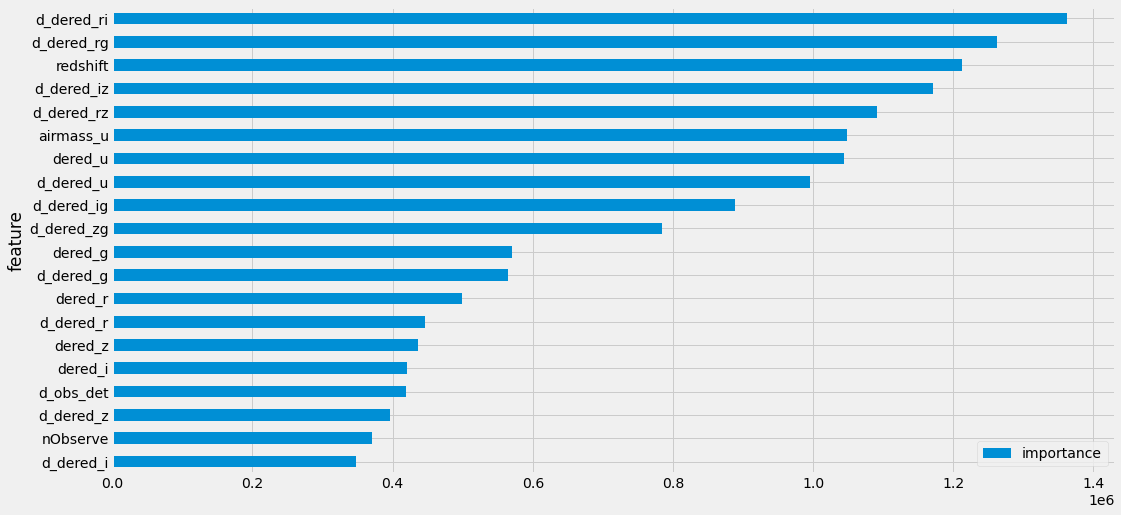

In [14]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [15]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [16]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [17]:
sub[target_col].value_counts()

2    40723
0    29976
1     9301
Name: class, dtype: int64

In [18]:
sub.to_csv(sub_file)